In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install transformers sentencepiece

     |████████████████████████████████| 1.8MB 5.6MB/s 
     |████████████████████████████████| 1.2MB 49.9MB/s 
     |████████████████████████████████| 2.9MB 49.3MB/s 
     |████████████████████████████████| 890kB 53.8MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.43-cp36-none-any.whl size=893261 sha256=0f3c6b33f81281984a00ffb5828f84c5b86a740266ee3f5d2fcf0edfe2b8a2cb
  Stored in directory: /root/.cache/pip/wheels/29/3c/fd/7ce5c3f0666dab31a50123635e6fb5e19ceb42ce38d4e58f45
Successfully built sacremoses


In [ ]:
# Importing stock ml libraries
import numpy as np
import pandas as pd
from tqdm import tqdm
from sklearn import metrics
import transformers
import torch
from torch.utils.data import Dataset, DataLoader, RandomSampler, SequentialSampler
from transformers import AutoTokenizer, AutoModelForSequenceClassification, AutoModel

In [ ]:
# # Setting up the device for GPU usage

from torch import cuda
device = 'cuda' if cuda.is_available() else 'cpu'

In [ ]:
train = pd.read_csv('drive/MyDrive/Datasets/mal_full_offensive_train.csv', sep='\t', names=['sent', 'label', 'other'])
train = train[["sent","label"]]

val = pd.read_csv('drive/MyDrive/Datasets/mal_full_offensive_dev.csv', sep='\t', names=['sent', 'label', 'other'])
val = val[["sent","label"]]

In [ ]:
n_classes = train['label'].nunique()
n_classes

5

In [ ]:
train['label'].unique()

array(['Not_offensive', 'Offensive_Targeted_Insult_Individual',
       'not-malayalam', 'Offensive_Targeted_Insult_Group',
       'Offensive_Untargetede'], dtype=object)

In [ ]:
# dict_ = {
#     'Not_offensive': 0,
#     'Offensive_Targeted_Insult_Individual': 1,
#     'not-Kannada': 2,
#     'Offensive_Targeted_Insult_Group': 3,
#     'Offensive_Untargetede': 4,
#     'Offensive_Targeted_Insult_Other': 5
# }

dict_ = {
    'Not_offensive': 0,
    'Offensive_Targeted_Insult_Individual': 1,
    'not-malayalam': 2,
    'Offensive_Targeted_Insult_Group': 3,
    'Offensive_Untargetede': 4,
}

In [ ]:
train['label'] = train['label'].apply(lambda x: dict_[x])
val['label'] = val['label'].apply(lambda x: dict_[x])

In [ ]:
# Sections of config

# Defining some key variables that will be used later on in the training
MAX_LEN = 200
TRAIN_BATCH_SIZE = 32
VALID_BATCH_SIZE = 16
EPOCHS = 5
LEARNING_RATE = 1e-05
tokenizer = AutoTokenizer.from_pretrained('ai4bharat/indic-bert')

In [ ]:
class CustomDataset(Dataset):

    def __init__(self, dataframe, tokenizer, max_len):
        self.tokenizer = tokenizer
        self.data = dataframe
        self.sent = dataframe.sent
        self.targets = dataframe.label
        self.max_len = max_len

    def __len__(self):
        return len(self.sent)

    def __getitem__(self, index):
        sent = str(self.sent[index])
        sent = " ".join(sent.split())

        inputs = self.tokenizer.encode_plus(
            sent,
            None,
            add_special_tokens=True,
            max_length=self.max_len,
            pad_to_max_length=True,
            return_token_type_ids=True
        )
        ids = inputs['input_ids']
        mask = inputs['attention_mask']
        token_type_ids = inputs["token_type_ids"]


        return {
            'ids': torch.tensor(ids, dtype=torch.long),
            'mask': torch.tensor(mask, dtype=torch.long),
            'token_type_ids': torch.tensor(token_type_ids, dtype=torch.long),
            'targets': torch.tensor(self.targets[index], dtype=torch.long)
        }

In [ ]:
# Creating the dataset and dataloader for the neural network

# train_size = 0.8
# train_dataset=df.sample(frac=train_size,random_state=200)
# test_dataset=df.drop(train_dataset.index).reset_index(drop=True)
# train_dataset = train_dataset.reset_index(drop=True)


# print("FULL Dataset: {}".format(df.shape))
# print("TRAIN Dataset: {}".format(train_dataset.shape))
# print("TEST Dataset: {}".format(test_dataset.shape))

training_set = CustomDataset(train, tokenizer, MAX_LEN)
testing_set = CustomDataset(val, tokenizer, MAX_LEN)

In [ ]:
train_params = {'batch_size': TRAIN_BATCH_SIZE,
                'shuffle': True,
                'num_workers': 0
                }

test_params = {'batch_size': VALID_BATCH_SIZE,
                'shuffle': True,
                'num_workers': 0
                }

training_loader = DataLoader(training_set, **train_params)
testing_loader = DataLoader(testing_set, **test_params)

In [ ]:
class AlbertClass(torch.nn.Module):
    def __init__(self):
        super(AlbertClass, self).__init__()
        self.l1 = AutoModel.from_pretrained("ai4bharat/indic-bert")
        self.pre_classifier = torch.nn.Linear(768, 768)
        self.dropout = torch.nn.Dropout(0.3)
        self.classifier = torch.nn.Linear(768, n_classes)

    def forward(self, input_ids, attention_mask, token_type_ids):
        output_1 = self.l1(input_ids=input_ids, attention_mask=attention_mask, token_type_ids=token_type_ids)
        pooler = self.pre_classifier(output_1['pooler_output'])
        pooler = torch.nn.ReLU()(pooler)
        pooler = self.dropout(pooler)
        output = self.classifier(pooler)
        return output

model = AlbertClass()
model.to(device)
print('Loaded!')

Loaded!


In [ ]:
# weight = None
# weight = (torch.tensor([1/3382,1/486,1/1407,1/327,1/212,1/122])).cuda()

weight = (torch.tensor([1/10382,1/171,1/882,1/106,1/154])).cuda()

In [ ]:
loss_function = torch.nn.CrossEntropyLoss(weight = weight)
optimizer = torch.optim.Adam(params =  model.parameters(), lr=LEARNING_RATE)

In [ ]:
def calcuate_accuracy(preds, targets):
    n_correct = (preds==targets).sum().item()
    return n_correct

In [ ]:
losslsit = []
acclist = []

In [ ]:
def train(epoch):
    tr_loss = 0
    n_correct = 0
    nb_tr_steps = 0
    nb_tr_examples = 0
    model.train()
    for _,data in tqdm(enumerate(training_loader, 0)):
        ids = data['ids'].to(device, dtype = torch.long)
        mask = data['mask'].to(device, dtype = torch.long)
        token_type_ids = data['token_type_ids'].to(device, dtype = torch.long)
        targets = data['targets'].to(device, dtype = torch.long)

        outputs = model(ids, mask, token_type_ids)
        loss = loss_function(outputs, targets)
        print(loss)
        tr_loss += loss.item()
        big_val, big_idx = torch.max(outputs.data, dim=1)
        n_correct += calcuate_accuracy(big_idx, targets)
        nb_tr_steps += 1
        nb_tr_examples+=targets.size(0)
        #print(targets)
        #print(big_idx)
        optimizer.zero_grad()
        loss.backward()
        # # When using GPU
        optimizer.step()
    print(f'The Total Accuracy for Epoch {epoch} : {(n_correct*100)/nb_tr_examples}')
    epoch_loss = tr_loss/nb_tr_steps
    epoch_accu = (n_correct*100)/nb_tr_examples
    losslsit.append(float(epoch_loss))
    acclist.append(float(epoch_accu))
    print(f"Training Loss Epoch: {epoch_loss}")
    print(f"Training Accuracy Epoch: {epoch_accu}")

In [ ]:
!nvidia-smi

Sat Jan 30 16:28:39 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   32C    P0    30W / 250W |    971MiB / 16280MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
EPOCHS=5

for epoch in range(EPOCHS):
    train(epoch)

0it [00:00, ?it/s]/usr/local/lib/python3.6/dist-packages/transformers/tokenization_utils_base.py:2143: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


tensor(0.0360, device='cuda:0', grad_fn=<NllLossBackward>)


1it [00:00,  1.67it/s]

tensor(0.1414, device='cuda:0', grad_fn=<NllLossBackward>)


2it [00:01,  1.69it/s]

tensor(0.0326, device='cuda:0', grad_fn=<NllLossBackward>)


3it [00:01,  1.70it/s]

tensor(0.0188, device='cuda:0', grad_fn=<NllLossBackward>)


4it [00:02,  1.71it/s]

tensor(0.1751, device='cuda:0', grad_fn=<NllLossBackward>)


5it [00:02,  1.72it/s]

tensor(0.0602, device='cuda:0', grad_fn=<NllLossBackward>)


6it [00:03,  1.72it/s]

tensor(0.1140, device='cuda:0', grad_fn=<NllLossBackward>)


7it [00:04,  1.73it/s]

tensor(0.2689, device='cuda:0', grad_fn=<NllLossBackward>)


8it [00:04,  1.73it/s]

tensor(0.0535, device='cuda:0', grad_fn=<NllLossBackward>)


9it [00:05,  1.73it/s]

tensor(0.0857, device='cuda:0', grad_fn=<NllLossBackward>)


10it [00:05,  1.73it/s]

tensor(0.0637, device='cuda:0', grad_fn=<NllLossBackward>)


11it [00:06,  1.73it/s]

tensor(0.0512, device='cuda:0', grad_fn=<NllLossBackward>)


12it [00:06,  1.73it/s]

tensor(0.1446, device='cuda:0', grad_fn=<NllLossBackward>)


13it [00:07,  1.73it/s]

tensor(0.0935, device='cuda:0', grad_fn=<NllLossBackward>)


14it [00:08,  1.73it/s]

tensor(0.0969, device='cuda:0', grad_fn=<NllLossBackward>)


15it [00:08,  1.73it/s]

tensor(0.1896, device='cuda:0', grad_fn=<NllLossBackward>)


16it [00:09,  1.73it/s]

tensor(0.1473, device='cuda:0', grad_fn=<NllLossBackward>)


17it [00:09,  1.73it/s]

tensor(0.1995, device='cuda:0', grad_fn=<NllLossBackward>)


18it [00:10,  1.73it/s]

tensor(0.1698, device='cuda:0', grad_fn=<NllLossBackward>)


19it [00:10,  1.73it/s]

tensor(0.1295, device='cuda:0', grad_fn=<NllLossBackward>)


20it [00:11,  1.73it/s]

tensor(0.1486, device='cuda:0', grad_fn=<NllLossBackward>)


21it [00:12,  1.73it/s]

tensor(0.1011, device='cuda:0', grad_fn=<NllLossBackward>)


22it [00:12,  1.73it/s]

tensor(0.0204, device='cuda:0', grad_fn=<NllLossBackward>)


23it [00:13,  1.73it/s]

tensor(0.2642, device='cuda:0', grad_fn=<NllLossBackward>)


24it [00:13,  1.73it/s]

tensor(0.0847, device='cuda:0', grad_fn=<NllLossBackward>)


25it [00:14,  1.73it/s]

tensor(0.1440, device='cuda:0', grad_fn=<NllLossBackward>)


26it [00:15,  1.73it/s]

tensor(0.4708, device='cuda:0', grad_fn=<NllLossBackward>)


27it [00:15,  1.73it/s]

tensor(0.0173, device='cuda:0', grad_fn=<NllLossBackward>)


28it [00:16,  1.73it/s]

tensor(0.0862, device='cuda:0', grad_fn=<NllLossBackward>)


29it [00:16,  1.73it/s]

tensor(0.1301, device='cuda:0', grad_fn=<NllLossBackward>)


30it [00:17,  1.74it/s]

tensor(0.3314, device='cuda:0', grad_fn=<NllLossBackward>)


31it [00:17,  1.73it/s]

tensor(0.0300, device='cuda:0', grad_fn=<NllLossBackward>)


32it [00:18,  1.73it/s]

tensor(0.0659, device='cuda:0', grad_fn=<NllLossBackward>)


33it [00:19,  1.73it/s]

tensor(0.6583, device='cuda:0', grad_fn=<NllLossBackward>)


34it [00:19,  1.73it/s]

tensor(0.2087, device='cuda:0', grad_fn=<NllLossBackward>)


35it [00:20,  1.73it/s]

tensor(0.0525, device='cuda:0', grad_fn=<NllLossBackward>)


36it [00:20,  1.73it/s]

tensor(0.2002, device='cuda:0', grad_fn=<NllLossBackward>)


37it [00:21,  1.73it/s]

tensor(0.0931, device='cuda:0', grad_fn=<NllLossBackward>)


38it [00:21,  1.73it/s]

tensor(0.0945, device='cuda:0', grad_fn=<NllLossBackward>)


39it [00:22,  1.73it/s]

tensor(0.1308, device='cuda:0', grad_fn=<NllLossBackward>)


40it [00:23,  1.73it/s]

tensor(0.0737, device='cuda:0', grad_fn=<NllLossBackward>)


41it [00:23,  1.73it/s]

tensor(0.0939, device='cuda:0', grad_fn=<NllLossBackward>)


42it [00:24,  1.73it/s]

tensor(0.7527, device='cuda:0', grad_fn=<NllLossBackward>)


43it [00:24,  1.73it/s]

tensor(0.0794, device='cuda:0', grad_fn=<NllLossBackward>)


44it [00:25,  1.73it/s]

tensor(0.0932, device='cuda:0', grad_fn=<NllLossBackward>)


45it [00:26,  1.73it/s]

tensor(0.0845, device='cuda:0', grad_fn=<NllLossBackward>)


46it [00:26,  1.73it/s]

tensor(0.0709, device='cuda:0', grad_fn=<NllLossBackward>)


47it [00:27,  1.73it/s]

tensor(0.0474, device='cuda:0', grad_fn=<NllLossBackward>)


48it [00:27,  1.73it/s]

tensor(0.1293, device='cuda:0', grad_fn=<NllLossBackward>)


49it [00:28,  1.73it/s]

tensor(0.0472, device='cuda:0', grad_fn=<NllLossBackward>)


50it [00:28,  1.72it/s]

tensor(0.0246, device='cuda:0', grad_fn=<NllLossBackward>)


51it [00:29,  1.73it/s]

tensor(0.2053, device='cuda:0', grad_fn=<NllLossBackward>)


52it [00:30,  1.73it/s]

tensor(0.0620, device='cuda:0', grad_fn=<NllLossBackward>)


53it [00:30,  1.73it/s]

tensor(0.1565, device='cuda:0', grad_fn=<NllLossBackward>)


54it [00:31,  1.73it/s]

tensor(0.3490, device='cuda:0', grad_fn=<NllLossBackward>)


55it [00:31,  1.73it/s]

tensor(0.0853, device='cuda:0', grad_fn=<NllLossBackward>)


56it [00:32,  1.73it/s]

tensor(0.1990, device='cuda:0', grad_fn=<NllLossBackward>)


57it [00:32,  1.73it/s]

tensor(0.1025, device='cuda:0', grad_fn=<NllLossBackward>)


58it [00:33,  1.73it/s]

tensor(0.0870, device='cuda:0', grad_fn=<NllLossBackward>)


59it [00:34,  1.73it/s]

tensor(0.0790, device='cuda:0', grad_fn=<NllLossBackward>)


60it [00:34,  1.73it/s]

tensor(0.0449, device='cuda:0', grad_fn=<NllLossBackward>)


61it [00:35,  1.73it/s]

tensor(0.2257, device='cuda:0', grad_fn=<NllLossBackward>)


62it [00:35,  1.73it/s]

tensor(0.1313, device='cuda:0', grad_fn=<NllLossBackward>)


63it [00:36,  1.73it/s]

tensor(0.0848, device='cuda:0', grad_fn=<NllLossBackward>)


64it [00:37,  1.73it/s]

tensor(0.2132, device='cuda:0', grad_fn=<NllLossBackward>)


65it [00:37,  1.73it/s]

tensor(0.0871, device='cuda:0', grad_fn=<NllLossBackward>)


66it [00:38,  1.73it/s]

tensor(0.2708, device='cuda:0', grad_fn=<NllLossBackward>)


67it [00:38,  1.73it/s]

tensor(0.0225, device='cuda:0', grad_fn=<NllLossBackward>)


68it [00:39,  1.73it/s]

tensor(0.0847, device='cuda:0', grad_fn=<NllLossBackward>)


69it [00:39,  1.73it/s]

tensor(0.0283, device='cuda:0', grad_fn=<NllLossBackward>)


70it [00:40,  1.73it/s]

tensor(0.0784, device='cuda:0', grad_fn=<NllLossBackward>)


71it [00:41,  1.73it/s]

tensor(0.1535, device='cuda:0', grad_fn=<NllLossBackward>)


72it [00:41,  1.73it/s]

tensor(0.1829, device='cuda:0', grad_fn=<NllLossBackward>)


73it [00:42,  1.73it/s]

tensor(0.1411, device='cuda:0', grad_fn=<NllLossBackward>)


74it [00:42,  1.73it/s]

tensor(0.3890, device='cuda:0', grad_fn=<NllLossBackward>)


75it [00:43,  1.73it/s]

tensor(0.0623, device='cuda:0', grad_fn=<NllLossBackward>)


76it [00:43,  1.73it/s]

tensor(0.0241, device='cuda:0', grad_fn=<NllLossBackward>)


77it [00:44,  1.73it/s]

tensor(0.1131, device='cuda:0', grad_fn=<NllLossBackward>)


78it [00:45,  1.73it/s]

tensor(0.0773, device='cuda:0', grad_fn=<NllLossBackward>)


79it [00:45,  1.73it/s]

tensor(0.0384, device='cuda:0', grad_fn=<NllLossBackward>)


80it [00:46,  1.72it/s]

tensor(0.1197, device='cuda:0', grad_fn=<NllLossBackward>)


81it [00:46,  1.72it/s]

tensor(0.1290, device='cuda:0', grad_fn=<NllLossBackward>)


82it [00:47,  1.73it/s]

tensor(0.1256, device='cuda:0', grad_fn=<NllLossBackward>)


83it [00:47,  1.73it/s]

tensor(0.0816, device='cuda:0', grad_fn=<NllLossBackward>)


84it [00:48,  1.73it/s]

tensor(0.0820, device='cuda:0', grad_fn=<NllLossBackward>)


85it [00:49,  1.73it/s]

tensor(0.1379, device='cuda:0', grad_fn=<NllLossBackward>)


86it [00:49,  1.73it/s]

tensor(0.3085, device='cuda:0', grad_fn=<NllLossBackward>)


87it [00:50,  1.73it/s]

tensor(0.1415, device='cuda:0', grad_fn=<NllLossBackward>)


88it [00:50,  1.73it/s]

tensor(0.5801, device='cuda:0', grad_fn=<NllLossBackward>)


89it [00:51,  1.73it/s]

tensor(0.0880, device='cuda:0', grad_fn=<NllLossBackward>)


90it [00:52,  1.73it/s]

tensor(0.0144, device='cuda:0', grad_fn=<NllLossBackward>)


91it [00:52,  1.73it/s]

tensor(0.1193, device='cuda:0', grad_fn=<NllLossBackward>)


92it [00:53,  1.73it/s]

tensor(0.1493, device='cuda:0', grad_fn=<NllLossBackward>)


93it [00:53,  1.73it/s]

tensor(0.5014, device='cuda:0', grad_fn=<NllLossBackward>)


94it [00:54,  1.73it/s]

tensor(0.0419, device='cuda:0', grad_fn=<NllLossBackward>)


95it [00:54,  1.73it/s]

tensor(0.0974, device='cuda:0', grad_fn=<NllLossBackward>)


96it [00:55,  1.73it/s]

tensor(0.0161, device='cuda:0', grad_fn=<NllLossBackward>)


97it [00:56,  1.73it/s]

tensor(0.0610, device='cuda:0', grad_fn=<NllLossBackward>)


98it [00:56,  1.73it/s]

tensor(0.1235, device='cuda:0', grad_fn=<NllLossBackward>)


99it [00:57,  1.73it/s]

tensor(0.0965, device='cuda:0', grad_fn=<NllLossBackward>)


100it [00:57,  1.73it/s]

tensor(0.1873, device='cuda:0', grad_fn=<NllLossBackward>)


101it [00:58,  1.73it/s]

tensor(0.2769, device='cuda:0', grad_fn=<NllLossBackward>)


102it [00:58,  1.73it/s]

tensor(0.1334, device='cuda:0', grad_fn=<NllLossBackward>)


103it [00:59,  1.73it/s]

tensor(0.0370, device='cuda:0', grad_fn=<NllLossBackward>)


104it [01:00,  1.73it/s]

tensor(0.0269, device='cuda:0', grad_fn=<NllLossBackward>)


105it [01:00,  1.73it/s]

tensor(0.0745, device='cuda:0', grad_fn=<NllLossBackward>)


106it [01:01,  1.73it/s]

tensor(0.0589, device='cuda:0', grad_fn=<NllLossBackward>)


107it [01:01,  1.73it/s]

tensor(0.1908, device='cuda:0', grad_fn=<NllLossBackward>)


108it [01:02,  1.73it/s]

tensor(0.3730, device='cuda:0', grad_fn=<NllLossBackward>)


109it [01:03,  1.73it/s]

tensor(0.1593, device='cuda:0', grad_fn=<NllLossBackward>)


110it [01:03,  1.73it/s]

tensor(0.1223, device='cuda:0', grad_fn=<NllLossBackward>)


111it [01:04,  1.73it/s]

tensor(0.0848, device='cuda:0', grad_fn=<NllLossBackward>)


112it [01:04,  1.73it/s]

tensor(0.1394, device='cuda:0', grad_fn=<NllLossBackward>)


113it [01:05,  1.73it/s]

tensor(0.0227, device='cuda:0', grad_fn=<NllLossBackward>)


114it [01:05,  1.73it/s]

tensor(0.0627, device='cuda:0', grad_fn=<NllLossBackward>)


115it [01:06,  1.73it/s]

tensor(0.1439, device='cuda:0', grad_fn=<NllLossBackward>)


116it [01:07,  1.73it/s]

tensor(0.1239, device='cuda:0', grad_fn=<NllLossBackward>)


117it [01:07,  1.73it/s]

tensor(0.0168, device='cuda:0', grad_fn=<NllLossBackward>)


118it [01:08,  1.73it/s]

tensor(0.1600, device='cuda:0', grad_fn=<NllLossBackward>)


119it [01:08,  1.73it/s]

tensor(0.0584, device='cuda:0', grad_fn=<NllLossBackward>)


120it [01:09,  1.73it/s]

tensor(0.0480, device='cuda:0', grad_fn=<NllLossBackward>)


121it [01:09,  1.73it/s]

tensor(0.0184, device='cuda:0', grad_fn=<NllLossBackward>)


122it [01:10,  1.73it/s]

tensor(0.0292, device='cuda:0', grad_fn=<NllLossBackward>)


123it [01:11,  1.73it/s]

tensor(1.4650, device='cuda:0', grad_fn=<NllLossBackward>)


124it [01:11,  1.73it/s]

tensor(0.5964, device='cuda:0', grad_fn=<NllLossBackward>)


125it [01:12,  1.73it/s]

tensor(0.0127, device='cuda:0', grad_fn=<NllLossBackward>)


126it [01:12,  1.73it/s]

tensor(0.0282, device='cuda:0', grad_fn=<NllLossBackward>)


127it [01:13,  1.73it/s]

tensor(0.3319, device='cuda:0', grad_fn=<NllLossBackward>)


128it [01:14,  1.73it/s]

tensor(0.0254, device='cuda:0', grad_fn=<NllLossBackward>)


129it [01:14,  1.73it/s]

tensor(0.4479, device='cuda:0', grad_fn=<NllLossBackward>)


130it [01:15,  1.73it/s]

tensor(0.1304, device='cuda:0', grad_fn=<NllLossBackward>)


131it [01:15,  1.72it/s]

tensor(0.1024, device='cuda:0', grad_fn=<NllLossBackward>)


132it [01:16,  1.72it/s]

tensor(0.0245, device='cuda:0', grad_fn=<NllLossBackward>)


133it [01:16,  1.73it/s]

tensor(0.1457, device='cuda:0', grad_fn=<NllLossBackward>)


134it [01:17,  1.73it/s]

tensor(0.1886, device='cuda:0', grad_fn=<NllLossBackward>)


135it [01:18,  1.73it/s]

tensor(0.0694, device='cuda:0', grad_fn=<NllLossBackward>)


136it [01:18,  1.72it/s]

tensor(0.0425, device='cuda:0', grad_fn=<NllLossBackward>)


137it [01:19,  1.73it/s]

tensor(0.1384, device='cuda:0', grad_fn=<NllLossBackward>)


138it [01:19,  1.72it/s]

tensor(0.5543, device='cuda:0', grad_fn=<NllLossBackward>)


139it [01:20,  1.73it/s]

tensor(0.1995, device='cuda:0', grad_fn=<NllLossBackward>)


140it [01:20,  1.73it/s]

tensor(0.3678, device='cuda:0', grad_fn=<NllLossBackward>)


141it [01:21,  1.73it/s]

tensor(0.3171, device='cuda:0', grad_fn=<NllLossBackward>)


142it [01:22,  1.73it/s]

tensor(0.1002, device='cuda:0', grad_fn=<NllLossBackward>)


143it [01:22,  1.73it/s]

tensor(0.1681, device='cuda:0', grad_fn=<NllLossBackward>)


144it [01:23,  1.73it/s]

tensor(0.2611, device='cuda:0', grad_fn=<NllLossBackward>)


145it [01:23,  1.73it/s]

tensor(0.0301, device='cuda:0', grad_fn=<NllLossBackward>)


146it [01:24,  1.73it/s]

tensor(0.1561, device='cuda:0', grad_fn=<NllLossBackward>)


147it [01:25,  1.73it/s]

tensor(0.0438, device='cuda:0', grad_fn=<NllLossBackward>)


148it [01:25,  1.73it/s]

tensor(0.0884, device='cuda:0', grad_fn=<NllLossBackward>)


149it [01:26,  1.73it/s]

tensor(0.1305, device='cuda:0', grad_fn=<NllLossBackward>)


150it [01:26,  1.73it/s]

tensor(0.1059, device='cuda:0', grad_fn=<NllLossBackward>)


151it [01:27,  1.73it/s]

tensor(0.0731, device='cuda:0', grad_fn=<NllLossBackward>)


152it [01:27,  1.73it/s]

tensor(0.1622, device='cuda:0', grad_fn=<NllLossBackward>)


153it [01:28,  1.73it/s]

tensor(0.1581, device='cuda:0', grad_fn=<NllLossBackward>)


154it [01:29,  1.73it/s]

tensor(0.9174, device='cuda:0', grad_fn=<NllLossBackward>)


155it [01:29,  1.73it/s]

tensor(0.0473, device='cuda:0', grad_fn=<NllLossBackward>)


156it [01:30,  1.73it/s]

tensor(0.1108, device='cuda:0', grad_fn=<NllLossBackward>)


157it [01:30,  1.73it/s]

tensor(0.4909, device='cuda:0', grad_fn=<NllLossBackward>)


158it [01:31,  1.73it/s]

tensor(0.1657, device='cuda:0', grad_fn=<NllLossBackward>)


159it [01:31,  1.73it/s]

tensor(0.0155, device='cuda:0', grad_fn=<NllLossBackward>)


160it [01:32,  1.73it/s]

tensor(0.0857, device='cuda:0', grad_fn=<NllLossBackward>)


161it [01:33,  1.73it/s]

tensor(0.2681, device='cuda:0', grad_fn=<NllLossBackward>)


162it [01:33,  1.73it/s]

tensor(0.0598, device='cuda:0', grad_fn=<NllLossBackward>)


163it [01:34,  1.73it/s]

tensor(0.2639, device='cuda:0', grad_fn=<NllLossBackward>)


164it [01:34,  1.72it/s]

tensor(0.0336, device='cuda:0', grad_fn=<NllLossBackward>)


165it [01:35,  1.72it/s]

tensor(0.3379, device='cuda:0', grad_fn=<NllLossBackward>)


166it [01:36,  1.73it/s]

tensor(0.0628, device='cuda:0', grad_fn=<NllLossBackward>)


167it [01:36,  1.73it/s]

tensor(0.1641, device='cuda:0', grad_fn=<NllLossBackward>)


168it [01:37,  1.73it/s]

tensor(0.1267, device='cuda:0', grad_fn=<NllLossBackward>)


169it [01:37,  1.73it/s]

tensor(0.2389, device='cuda:0', grad_fn=<NllLossBackward>)


170it [01:38,  1.73it/s]

tensor(0.2493, device='cuda:0', grad_fn=<NllLossBackward>)


171it [01:38,  1.73it/s]

tensor(0.1231, device='cuda:0', grad_fn=<NllLossBackward>)


172it [01:39,  1.73it/s]

tensor(0.1208, device='cuda:0', grad_fn=<NllLossBackward>)


173it [01:40,  1.73it/s]

tensor(0.0251, device='cuda:0', grad_fn=<NllLossBackward>)


174it [01:40,  1.73it/s]

tensor(0.1082, device='cuda:0', grad_fn=<NllLossBackward>)


175it [01:41,  1.73it/s]

tensor(1.4234, device='cuda:0', grad_fn=<NllLossBackward>)


176it [01:41,  1.73it/s]

tensor(0.0497, device='cuda:0', grad_fn=<NllLossBackward>)


177it [01:42,  1.73it/s]

tensor(0.0450, device='cuda:0', grad_fn=<NllLossBackward>)


178it [01:42,  1.73it/s]

tensor(0.2358, device='cuda:0', grad_fn=<NllLossBackward>)


179it [01:43,  1.73it/s]

tensor(0.0418, device='cuda:0', grad_fn=<NllLossBackward>)


180it [01:44,  1.73it/s]

tensor(0.2095, device='cuda:0', grad_fn=<NllLossBackward>)


181it [01:44,  1.73it/s]

tensor(0.1502, device='cuda:0', grad_fn=<NllLossBackward>)


182it [01:45,  1.73it/s]

tensor(0.0349, device='cuda:0', grad_fn=<NllLossBackward>)


183it [01:45,  1.73it/s]

tensor(0.1360, device='cuda:0', grad_fn=<NllLossBackward>)


184it [01:46,  1.73it/s]

tensor(0.0696, device='cuda:0', grad_fn=<NllLossBackward>)


185it [01:46,  1.73it/s]

tensor(0.2095, device='cuda:0', grad_fn=<NllLossBackward>)


186it [01:47,  1.73it/s]

tensor(0.0443, device='cuda:0', grad_fn=<NllLossBackward>)


187it [01:48,  1.73it/s]

tensor(0.0799, device='cuda:0', grad_fn=<NllLossBackward>)


188it [01:48,  1.72it/s]

tensor(0.0455, device='cuda:0', grad_fn=<NllLossBackward>)


189it [01:49,  1.73it/s]

tensor(0.0370, device='cuda:0', grad_fn=<NllLossBackward>)


190it [01:49,  1.73it/s]

tensor(0.0948, device='cuda:0', grad_fn=<NllLossBackward>)


191it [01:50,  1.73it/s]

tensor(0.0291, device='cuda:0', grad_fn=<NllLossBackward>)


192it [01:51,  1.73it/s]

tensor(0.2435, device='cuda:0', grad_fn=<NllLossBackward>)


193it [01:51,  1.73it/s]

tensor(0.1025, device='cuda:0', grad_fn=<NllLossBackward>)


194it [01:52,  1.72it/s]

tensor(0.0871, device='cuda:0', grad_fn=<NllLossBackward>)


195it [01:52,  1.72it/s]

tensor(0.0274, device='cuda:0', grad_fn=<NllLossBackward>)


196it [01:53,  1.73it/s]

tensor(0.0170, device='cuda:0', grad_fn=<NllLossBackward>)


197it [01:53,  1.73it/s]

tensor(0.0972, device='cuda:0', grad_fn=<NllLossBackward>)


198it [01:54,  1.73it/s]

tensor(0.0765, device='cuda:0', grad_fn=<NllLossBackward>)


199it [01:55,  1.73it/s]

tensor(0.0436, device='cuda:0', grad_fn=<NllLossBackward>)


200it [01:55,  1.73it/s]

tensor(0.1539, device='cuda:0', grad_fn=<NllLossBackward>)


201it [01:56,  1.73it/s]

tensor(0.1670, device='cuda:0', grad_fn=<NllLossBackward>)


202it [01:56,  1.72it/s]

tensor(0.0149, device='cuda:0', grad_fn=<NllLossBackward>)


203it [01:57,  1.73it/s]

tensor(1.4961, device='cuda:0', grad_fn=<NllLossBackward>)


204it [01:57,  1.73it/s]

tensor(0.1202, device='cuda:0', grad_fn=<NllLossBackward>)


205it [01:58,  1.73it/s]

tensor(0.1148, device='cuda:0', grad_fn=<NllLossBackward>)


206it [01:59,  1.73it/s]

tensor(0.2198, device='cuda:0', grad_fn=<NllLossBackward>)


207it [01:59,  1.73it/s]

tensor(0.3701, device='cuda:0', grad_fn=<NllLossBackward>)


208it [02:00,  1.73it/s]

tensor(0.0447, device='cuda:0', grad_fn=<NllLossBackward>)


209it [02:00,  1.73it/s]

tensor(0.0233, device='cuda:0', grad_fn=<NllLossBackward>)


210it [02:01,  1.73it/s]

tensor(0.1456, device='cuda:0', grad_fn=<NllLossBackward>)


211it [02:02,  1.73it/s]

tensor(0.0269, device='cuda:0', grad_fn=<NllLossBackward>)


212it [02:02,  1.73it/s]

tensor(0.5419, device='cuda:0', grad_fn=<NllLossBackward>)


213it [02:03,  1.73it/s]

tensor(1.1373, device='cuda:0', grad_fn=<NllLossBackward>)


214it [02:03,  1.73it/s]

tensor(0.1972, device='cuda:0', grad_fn=<NllLossBackward>)


215it [02:04,  1.73it/s]

tensor(0.1147, device='cuda:0', grad_fn=<NllLossBackward>)


216it [02:04,  1.73it/s]

tensor(0.1349, device='cuda:0', grad_fn=<NllLossBackward>)


217it [02:05,  1.73it/s]

tensor(1.6220, device='cuda:0', grad_fn=<NllLossBackward>)


218it [02:06,  1.72it/s]

tensor(0.1635, device='cuda:0', grad_fn=<NllLossBackward>)


219it [02:06,  1.73it/s]

tensor(0.4159, device='cuda:0', grad_fn=<NllLossBackward>)


220it [02:07,  1.73it/s]

tensor(0.0771, device='cuda:0', grad_fn=<NllLossBackward>)


221it [02:07,  1.73it/s]

tensor(0.0937, device='cuda:0', grad_fn=<NllLossBackward>)


222it [02:08,  1.73it/s]

tensor(0.1707, device='cuda:0', grad_fn=<NllLossBackward>)


223it [02:08,  1.72it/s]

tensor(0.2122, device='cuda:0', grad_fn=<NllLossBackward>)


224it [02:09,  1.72it/s]

tensor(0.1331, device='cuda:0', grad_fn=<NllLossBackward>)


225it [02:10,  1.72it/s]

tensor(0.1671, device='cuda:0', grad_fn=<NllLossBackward>)


226it [02:10,  1.72it/s]

tensor(0.1138, device='cuda:0', grad_fn=<NllLossBackward>)


227it [02:11,  1.73it/s]

tensor(0.1309, device='cuda:0', grad_fn=<NllLossBackward>)


228it [02:11,  1.73it/s]

tensor(0.4106, device='cuda:0', grad_fn=<NllLossBackward>)


229it [02:12,  1.73it/s]

tensor(0.2046, device='cuda:0', grad_fn=<NllLossBackward>)


230it [02:13,  1.73it/s]

tensor(0.1976, device='cuda:0', grad_fn=<NllLossBackward>)


231it [02:13,  1.73it/s]

tensor(0.0499, device='cuda:0', grad_fn=<NllLossBackward>)


232it [02:14,  1.73it/s]

tensor(0.2810, device='cuda:0', grad_fn=<NllLossBackward>)


233it [02:14,  1.73it/s]

tensor(0.3876, device='cuda:0', grad_fn=<NllLossBackward>)


234it [02:15,  1.73it/s]

tensor(0.4901, device='cuda:0', grad_fn=<NllLossBackward>)


235it [02:15,  1.73it/s]

tensor(0.2613, device='cuda:0', grad_fn=<NllLossBackward>)


236it [02:16,  1.73it/s]

tensor(0.1376, device='cuda:0', grad_fn=<NllLossBackward>)


237it [02:17,  1.73it/s]

tensor(0.6061, device='cuda:0', grad_fn=<NllLossBackward>)


238it [02:17,  1.73it/s]

tensor(0.0372, device='cuda:0', grad_fn=<NllLossBackward>)


239it [02:18,  1.73it/s]

tensor(0.0888, device='cuda:0', grad_fn=<NllLossBackward>)


240it [02:18,  1.73it/s]

tensor(0.0857, device='cuda:0', grad_fn=<NllLossBackward>)


241it [02:19,  1.73it/s]

tensor(0.2411, device='cuda:0', grad_fn=<NllLossBackward>)


242it [02:19,  1.73it/s]

tensor(0.0332, device='cuda:0', grad_fn=<NllLossBackward>)


243it [02:20,  1.72it/s]

tensor(0.0923, device='cuda:0', grad_fn=<NllLossBackward>)


244it [02:21,  1.72it/s]

tensor(0.1788, device='cuda:0', grad_fn=<NllLossBackward>)


245it [02:21,  1.72it/s]

tensor(0.1302, device='cuda:0', grad_fn=<NllLossBackward>)


246it [02:22,  1.73it/s]

tensor(0.9323, device='cuda:0', grad_fn=<NllLossBackward>)


247it [02:22,  1.73it/s]

tensor(0.1574, device='cuda:0', grad_fn=<NllLossBackward>)


248it [02:23,  1.72it/s]

tensor(0.0856, device='cuda:0', grad_fn=<NllLossBackward>)


249it [02:24,  1.72it/s]

tensor(0.1326, device='cuda:0', grad_fn=<NllLossBackward>)


250it [02:24,  1.73it/s]

tensor(0.0861, device='cuda:0', grad_fn=<NllLossBackward>)


251it [02:25,  1.73it/s]

tensor(0.1401, device='cuda:0', grad_fn=<NllLossBackward>)


252it [02:25,  1.73it/s]

tensor(0.1367, device='cuda:0', grad_fn=<NllLossBackward>)


253it [02:26,  1.73it/s]

tensor(0.1979, device='cuda:0', grad_fn=<NllLossBackward>)


254it [02:26,  1.72it/s]

tensor(0.2705, device='cuda:0', grad_fn=<NllLossBackward>)


255it [02:27,  1.72it/s]

tensor(0.2528, device='cuda:0', grad_fn=<NllLossBackward>)


256it [02:28,  1.72it/s]

tensor(0.0945, device='cuda:0', grad_fn=<NllLossBackward>)


257it [02:28,  1.72it/s]

tensor(0.1024, device='cuda:0', grad_fn=<NllLossBackward>)


258it [02:29,  1.72it/s]

tensor(0.1025, device='cuda:0', grad_fn=<NllLossBackward>)


259it [02:29,  1.72it/s]

tensor(0.0251, device='cuda:0', grad_fn=<NllLossBackward>)


260it [02:30,  1.72it/s]

tensor(0.1508, device='cuda:0', grad_fn=<NllLossBackward>)


261it [02:31,  1.72it/s]

tensor(0.0476, device='cuda:0', grad_fn=<NllLossBackward>)


262it [02:31,  1.72it/s]

tensor(0.1786, device='cuda:0', grad_fn=<NllLossBackward>)


263it [02:32,  1.73it/s]

tensor(0.0826, device='cuda:0', grad_fn=<NllLossBackward>)


264it [02:32,  1.72it/s]

tensor(0.2615, device='cuda:0', grad_fn=<NllLossBackward>)


265it [02:33,  1.73it/s]

tensor(0.1204, device='cuda:0', grad_fn=<NllLossBackward>)


266it [02:33,  1.73it/s]

tensor(0.0297, device='cuda:0', grad_fn=<NllLossBackward>)


267it [02:34,  1.72it/s]

tensor(0.9482, device='cuda:0', grad_fn=<NllLossBackward>)


268it [02:35,  1.72it/s]

tensor(0.1431, device='cuda:0', grad_fn=<NllLossBackward>)


269it [02:35,  1.72it/s]

tensor(0.1944, device='cuda:0', grad_fn=<NllLossBackward>)


270it [02:36,  1.72it/s]

tensor(0.0619, device='cuda:0', grad_fn=<NllLossBackward>)


271it [02:36,  1.72it/s]

tensor(0.1089, device='cuda:0', grad_fn=<NllLossBackward>)


272it [02:37,  1.73it/s]

tensor(0.2061, device='cuda:0', grad_fn=<NllLossBackward>)


273it [02:37,  1.73it/s]

tensor(0.0898, device='cuda:0', grad_fn=<NllLossBackward>)


274it [02:38,  1.73it/s]

tensor(0.2538, device='cuda:0', grad_fn=<NllLossBackward>)


275it [02:39,  1.73it/s]

tensor(0.2507, device='cuda:0', grad_fn=<NllLossBackward>)


276it [02:39,  1.73it/s]

tensor(0.0636, device='cuda:0', grad_fn=<NllLossBackward>)


277it [02:40,  1.73it/s]

tensor(0.0687, device='cuda:0', grad_fn=<NllLossBackward>)


278it [02:40,  1.73it/s]

tensor(0.1607, device='cuda:0', grad_fn=<NllLossBackward>)


279it [02:41,  1.73it/s]

tensor(0.4331, device='cuda:0', grad_fn=<NllLossBackward>)


280it [02:42,  1.73it/s]

tensor(0.1316, device='cuda:0', grad_fn=<NllLossBackward>)


281it [02:42,  1.73it/s]

tensor(0.2745, device='cuda:0', grad_fn=<NllLossBackward>)


282it [02:43,  1.73it/s]

tensor(0.0255, device='cuda:0', grad_fn=<NllLossBackward>)


283it [02:43,  1.73it/s]

tensor(0.0202, device='cuda:0', grad_fn=<NllLossBackward>)


284it [02:44,  1.73it/s]

tensor(0.1251, device='cuda:0', grad_fn=<NllLossBackward>)


285it [02:44,  1.72it/s]

tensor(0.0528, device='cuda:0', grad_fn=<NllLossBackward>)


286it [02:45,  1.73it/s]

tensor(0.0313, device='cuda:0', grad_fn=<NllLossBackward>)


287it [02:46,  1.72it/s]

tensor(0.1852, device='cuda:0', grad_fn=<NllLossBackward>)


288it [02:46,  1.72it/s]

tensor(0.0528, device='cuda:0', grad_fn=<NllLossBackward>)


289it [02:47,  1.72it/s]

tensor(0.3640, device='cuda:0', grad_fn=<NllLossBackward>)


290it [02:47,  1.72it/s]

tensor(0.0979, device='cuda:0', grad_fn=<NllLossBackward>)


291it [02:48,  1.72it/s]

tensor(0.0407, device='cuda:0', grad_fn=<NllLossBackward>)


292it [02:48,  1.72it/s]

tensor(0.0456, device='cuda:0', grad_fn=<NllLossBackward>)


293it [02:49,  1.72it/s]

tensor(0.0596, device='cuda:0', grad_fn=<NllLossBackward>)


294it [02:50,  1.72it/s]

tensor(0.1202, device='cuda:0', grad_fn=<NllLossBackward>)


295it [02:50,  1.73it/s]

tensor(0.1450, device='cuda:0', grad_fn=<NllLossBackward>)


296it [02:51,  1.73it/s]

tensor(0.0422, device='cuda:0', grad_fn=<NllLossBackward>)


297it [02:51,  1.73it/s]

tensor(0.3996, device='cuda:0', grad_fn=<NllLossBackward>)


298it [02:52,  1.72it/s]

tensor(0.0628, device='cuda:0', grad_fn=<NllLossBackward>)


299it [02:53,  1.72it/s]

tensor(0.0335, device='cuda:0', grad_fn=<NllLossBackward>)


300it [02:53,  1.72it/s]

tensor(0.0388, device='cuda:0', grad_fn=<NllLossBackward>)


301it [02:54,  1.72it/s]

tensor(0.1112, device='cuda:0', grad_fn=<NllLossBackward>)


302it [02:54,  1.72it/s]

tensor(0.0711, device='cuda:0', grad_fn=<NllLossBackward>)


303it [02:55,  1.72it/s]

tensor(0.2857, device='cuda:0', grad_fn=<NllLossBackward>)


304it [02:55,  1.72it/s]

tensor(0.4008, device='cuda:0', grad_fn=<NllLossBackward>)


305it [02:56,  1.72it/s]

tensor(0.1551, device='cuda:0', grad_fn=<NllLossBackward>)


306it [02:57,  1.72it/s]

tensor(0.4378, device='cuda:0', grad_fn=<NllLossBackward>)


307it [02:57,  1.72it/s]

tensor(0.1154, device='cuda:0', grad_fn=<NllLossBackward>)


308it [02:58,  1.72it/s]

tensor(0.2019, device='cuda:0', grad_fn=<NllLossBackward>)


309it [02:58,  1.72it/s]

tensor(0.1679, device='cuda:0', grad_fn=<NllLossBackward>)


310it [02:59,  1.72it/s]

tensor(0.0358, device='cuda:0', grad_fn=<NllLossBackward>)


311it [03:00,  1.72it/s]

tensor(0.2005, device='cuda:0', grad_fn=<NllLossBackward>)


312it [03:00,  1.72it/s]

tensor(0.1436, device='cuda:0', grad_fn=<NllLossBackward>)


313it [03:01,  1.72it/s]

tensor(0.0464, device='cuda:0', grad_fn=<NllLossBackward>)


314it [03:01,  1.72it/s]

tensor(0.1182, device='cuda:0', grad_fn=<NllLossBackward>)


315it [03:02,  1.72it/s]

tensor(0.1298, device='cuda:0', grad_fn=<NllLossBackward>)


316it [03:02,  1.72it/s]

tensor(0.1145, device='cuda:0', grad_fn=<NllLossBackward>)


317it [03:03,  1.72it/s]

tensor(0.1067, device='cuda:0', grad_fn=<NllLossBackward>)


318it [03:04,  1.72it/s]

tensor(0.2467, device='cuda:0', grad_fn=<NllLossBackward>)


319it [03:04,  1.72it/s]

tensor(0.1700, device='cuda:0', grad_fn=<NllLossBackward>)


320it [03:05,  1.72it/s]

tensor(0.0722, device='cuda:0', grad_fn=<NllLossBackward>)


321it [03:05,  1.73it/s]

tensor(0.0475, device='cuda:0', grad_fn=<NllLossBackward>)


322it [03:06,  1.73it/s]

tensor(0.0270, device='cuda:0', grad_fn=<NllLossBackward>)


323it [03:06,  1.72it/s]

tensor(0.0998, device='cuda:0', grad_fn=<NllLossBackward>)


324it [03:07,  1.72it/s]

tensor(0.1474, device='cuda:0', grad_fn=<NllLossBackward>)


325it [03:08,  1.73it/s]

tensor(1.4820, device='cuda:0', grad_fn=<NllLossBackward>)


326it [03:08,  1.72it/s]

tensor(0.7200, device='cuda:0', grad_fn=<NllLossBackward>)


327it [03:09,  1.73it/s]

tensor(0.1648, device='cuda:0', grad_fn=<NllLossBackward>)


328it [03:09,  1.72it/s]

tensor(0.0336, device='cuda:0', grad_fn=<NllLossBackward>)


329it [03:10,  1.72it/s]

tensor(0.6798, device='cuda:0', grad_fn=<NllLossBackward>)


330it [03:11,  1.72it/s]

tensor(0.0142, device='cuda:0', grad_fn=<NllLossBackward>)


331it [03:11,  1.72it/s]

tensor(0.2554, device='cuda:0', grad_fn=<NllLossBackward>)


332it [03:12,  1.72it/s]

tensor(0.1460, device='cuda:0', grad_fn=<NllLossBackward>)


333it [03:12,  1.72it/s]

tensor(0.1128, device='cuda:0', grad_fn=<NllLossBackward>)


334it [03:13,  1.71it/s]

tensor(0.0768, device='cuda:0', grad_fn=<NllLossBackward>)


335it [03:13,  1.72it/s]

tensor(0.0492, device='cuda:0', grad_fn=<NllLossBackward>)


336it [03:14,  1.72it/s]

tensor(0.1319, device='cuda:0', grad_fn=<NllLossBackward>)


337it [03:15,  1.72it/s]

tensor(0.3483, device='cuda:0', grad_fn=<NllLossBackward>)


338it [03:15,  1.72it/s]

tensor(0.0837, device='cuda:0', grad_fn=<NllLossBackward>)


339it [03:16,  1.72it/s]

tensor(0.0731, device='cuda:0', grad_fn=<NllLossBackward>)


340it [03:16,  1.72it/s]

tensor(0.1349, device='cuda:0', grad_fn=<NllLossBackward>)


341it [03:17,  1.72it/s]

tensor(0.0134, device='cuda:0', grad_fn=<NllLossBackward>)


342it [03:18,  1.72it/s]

tensor(0.0437, device='cuda:0', grad_fn=<NllLossBackward>)


343it [03:18,  1.72it/s]

tensor(0.0898, device='cuda:0', grad_fn=<NllLossBackward>)


344it [03:19,  1.72it/s]

tensor(0.1790, device='cuda:0', grad_fn=<NllLossBackward>)


345it [03:19,  1.72it/s]

tensor(0.1286, device='cuda:0', grad_fn=<NllLossBackward>)


346it [03:20,  1.72it/s]

tensor(0.0217, device='cuda:0', grad_fn=<NllLossBackward>)


347it [03:20,  1.72it/s]

tensor(0.1638, device='cuda:0', grad_fn=<NllLossBackward>)


348it [03:21,  1.72it/s]

tensor(1.2431, device='cuda:0', grad_fn=<NllLossBackward>)


349it [03:22,  1.72it/s]

tensor(0.0608, device='cuda:0', grad_fn=<NllLossBackward>)


350it [03:22,  1.72it/s]

tensor(0.0776, device='cuda:0', grad_fn=<NllLossBackward>)


351it [03:23,  1.72it/s]

tensor(0.2892, device='cuda:0', grad_fn=<NllLossBackward>)


352it [03:23,  1.72it/s]

tensor(0.0776, device='cuda:0', grad_fn=<NllLossBackward>)


353it [03:24,  1.71it/s]

tensor(0.4281, device='cuda:0', grad_fn=<NllLossBackward>)


354it [03:25,  1.71it/s]

tensor(0.1725, device='cuda:0', grad_fn=<NllLossBackward>)


355it [03:25,  1.72it/s]

tensor(0.1649, device='cuda:0', grad_fn=<NllLossBackward>)


356it [03:26,  1.72it/s]

tensor(0.0350, device='cuda:0', grad_fn=<NllLossBackward>)


357it [03:26,  1.72it/s]

tensor(0.0492, device='cuda:0', grad_fn=<NllLossBackward>)


358it [03:27,  1.72it/s]

tensor(0.1415, device='cuda:0', grad_fn=<NllLossBackward>)


359it [03:27,  1.72it/s]

tensor(0.0729, device='cuda:0', grad_fn=<NllLossBackward>)


360it [03:28,  1.72it/s]

tensor(0.1020, device='cuda:0', grad_fn=<NllLossBackward>)


361it [03:29,  1.72it/s]

tensor(0.1438, device='cuda:0', grad_fn=<NllLossBackward>)


362it [03:29,  1.72it/s]

tensor(1.7225, device='cuda:0', grad_fn=<NllLossBackward>)


363it [03:30,  1.72it/s]

tensor(0.0809, device='cuda:0', grad_fn=<NllLossBackward>)


364it [03:30,  1.72it/s]

tensor(0.0729, device='cuda:0', grad_fn=<NllLossBackward>)


365it [03:31,  1.72it/s]

tensor(0.1980, device='cuda:0', grad_fn=<NllLossBackward>)


366it [03:31,  1.72it/s]

tensor(0.0472, device='cuda:0', grad_fn=<NllLossBackward>)


367it [03:32,  1.72it/s]

tensor(0.3034, device='cuda:0', grad_fn=<NllLossBackward>)


368it [03:33,  1.72it/s]

tensor(0.1297, device='cuda:0', grad_fn=<NllLossBackward>)


369it [03:33,  1.72it/s]

tensor(1.0163, device='cuda:0', grad_fn=<NllLossBackward>)


370it [03:34,  1.72it/s]

tensor(0.1532, device='cuda:0', grad_fn=<NllLossBackward>)


371it [03:34,  1.73it/s]

tensor(0.0686, device='cuda:0', grad_fn=<NllLossBackward>)


372it [03:35,  1.73it/s]

tensor(0.1682, device='cuda:0', grad_fn=<NllLossBackward>)


373it [03:36,  1.72it/s]

tensor(2.1664, device='cuda:0', grad_fn=<NllLossBackward>)


374it [03:36,  1.72it/s]

tensor(1.1150, device='cuda:0', grad_fn=<NllLossBackward>)


375it [03:37,  1.72it/s]

tensor(0.1187, device='cuda:0', grad_fn=<NllLossBackward>)


376it [03:37,  1.72it/s]

tensor(0.0472, device='cuda:0', grad_fn=<NllLossBackward>)


377it [03:38,  1.72it/s]

tensor(1.2512, device='cuda:0', grad_fn=<NllLossBackward>)


378it [03:38,  1.72it/s]

tensor(0.3052, device='cuda:0', grad_fn=<NllLossBackward>)


379it [03:39,  1.72it/s]

tensor(0.0985, device='cuda:0', grad_fn=<NllLossBackward>)


380it [03:40,  1.72it/s]

tensor(0.0511, device='cuda:0', grad_fn=<NllLossBackward>)


381it [03:40,  1.72it/s]

tensor(0.1596, device='cuda:0', grad_fn=<NllLossBackward>)


382it [03:41,  1.72it/s]

tensor(0.1284, device='cuda:0', grad_fn=<NllLossBackward>)


383it [03:41,  1.72it/s]

tensor(0.2595, device='cuda:0', grad_fn=<NllLossBackward>)


384it [03:42,  1.72it/s]

tensor(0.3210, device='cuda:0', grad_fn=<NllLossBackward>)


385it [03:43,  1.72it/s]

tensor(0.5721, device='cuda:0', grad_fn=<NllLossBackward>)


386it [03:43,  1.72it/s]

tensor(1.3543, device='cuda:0', grad_fn=<NllLossBackward>)


387it [03:44,  1.73it/s]

tensor(1.3964, device='cuda:0', grad_fn=<NllLossBackward>)


388it [03:44,  1.72it/s]

tensor(0.2658, device='cuda:0', grad_fn=<NllLossBackward>)


389it [03:45,  1.72it/s]

tensor(1.1304, device='cuda:0', grad_fn=<NllLossBackward>)


390it [03:45,  1.72it/s]

tensor(0.8893, device='cuda:0', grad_fn=<NllLossBackward>)


391it [03:46,  1.72it/s]

tensor(0.4565, device='cuda:0', grad_fn=<NllLossBackward>)


392it [03:47,  1.72it/s]

tensor(0.3350, device='cuda:0', grad_fn=<NllLossBackward>)


393it [03:47,  1.72it/s]

tensor(0.2278, device='cuda:0', grad_fn=<NllLossBackward>)


394it [03:48,  1.72it/s]

tensor(0.2848, device='cuda:0', grad_fn=<NllLossBackward>)


395it [03:48,  1.72it/s]

tensor(0.6866, device='cuda:0', grad_fn=<NllLossBackward>)


396it [03:49,  1.72it/s]

tensor(0.0789, device='cuda:0', grad_fn=<NllLossBackward>)


397it [03:49,  1.73it/s]

tensor(0.1815, device='cuda:0', grad_fn=<NllLossBackward>)


398it [03:50,  1.72it/s]

tensor(0.1611, device='cuda:0', grad_fn=<NllLossBackward>)


399it [03:51,  1.72it/s]

tensor(0.1007, device='cuda:0', grad_fn=<NllLossBackward>)


400it [03:51,  1.72it/s]

tensor(1.1436, device='cuda:0', grad_fn=<NllLossBackward>)


401it [03:52,  1.72it/s]

tensor(0.5790, device='cuda:0', grad_fn=<NllLossBackward>)


402it [03:52,  1.72it/s]

tensor(0.1211, device='cuda:0', grad_fn=<NllLossBackward>)


403it [03:53,  1.72it/s]

tensor(0.2373, device='cuda:0', grad_fn=<NllLossBackward>)


404it [03:54,  1.72it/s]

tensor(0.0716, device='cuda:0', grad_fn=<NllLossBackward>)


405it [03:54,  1.72it/s]

tensor(0.3879, device='cuda:0', grad_fn=<NllLossBackward>)


406it [03:55,  1.72it/s]

tensor(0.1434, device='cuda:0', grad_fn=<NllLossBackward>)


407it [03:55,  1.72it/s]

tensor(0.2500, device='cuda:0', grad_fn=<NllLossBackward>)


408it [03:56,  1.72it/s]

tensor(0.2146, device='cuda:0', grad_fn=<NllLossBackward>)


409it [03:56,  1.72it/s]

tensor(1.2259, device='cuda:0', grad_fn=<NllLossBackward>)


410it [03:57,  1.72it/s]

tensor(0.1197, device='cuda:0', grad_fn=<NllLossBackward>)


411it [03:58,  1.72it/s]

tensor(0.7567, device='cuda:0', grad_fn=<NllLossBackward>)


412it [03:58,  1.72it/s]

tensor(0.2214, device='cuda:0', grad_fn=<NllLossBackward>)


413it [03:59,  1.72it/s]

tensor(0.2873, device='cuda:0', grad_fn=<NllLossBackward>)


414it [03:59,  1.72it/s]

tensor(0.3427, device='cuda:0', grad_fn=<NllLossBackward>)


415it [04:00,  1.72it/s]

tensor(0.0510, device='cuda:0', grad_fn=<NllLossBackward>)


416it [04:01,  1.72it/s]

tensor(0.1818, device='cuda:0', grad_fn=<NllLossBackward>)


417it [04:01,  1.72it/s]

tensor(0.0945, device='cuda:0', grad_fn=<NllLossBackward>)


418it [04:02,  1.72it/s]

tensor(0.2574, device='cuda:0', grad_fn=<NllLossBackward>)


419it [04:02,  1.73it/s]

tensor(0.5601, device='cuda:0', grad_fn=<NllLossBackward>)


420it [04:03,  1.72it/s]

tensor(0.1819, device='cuda:0', grad_fn=<NllLossBackward>)


421it [04:03,  1.72it/s]

tensor(0.3154, device='cuda:0', grad_fn=<NllLossBackward>)


422it [04:04,  1.72it/s]

tensor(0.0938, device='cuda:0', grad_fn=<NllLossBackward>)


423it [04:05,  1.72it/s]

tensor(0.0463, device='cuda:0', grad_fn=<NllLossBackward>)


424it [04:05,  1.72it/s]

tensor(0.2181, device='cuda:0', grad_fn=<NllLossBackward>)


425it [04:06,  1.72it/s]

tensor(0.0913, device='cuda:0', grad_fn=<NllLossBackward>)


426it [04:06,  1.72it/s]

tensor(0.0826, device='cuda:0', grad_fn=<NllLossBackward>)


427it [04:07,  1.72it/s]

tensor(0.3286, device='cuda:0', grad_fn=<NllLossBackward>)


428it [04:07,  1.72it/s]

tensor(0.1383, device='cuda:0', grad_fn=<NllLossBackward>)


429it [04:08,  1.72it/s]

tensor(0.1265, device='cuda:0', grad_fn=<NllLossBackward>)


430it [04:09,  1.72it/s]

tensor(0.1427, device='cuda:0', grad_fn=<NllLossBackward>)


431it [04:09,  1.72it/s]

tensor(0.1316, device='cuda:0', grad_fn=<NllLossBackward>)


432it [04:10,  1.72it/s]

tensor(0.5550, device='cuda:0', grad_fn=<NllLossBackward>)


433it [04:10,  1.72it/s]

tensor(0.5391, device='cuda:0', grad_fn=<NllLossBackward>)


434it [04:11,  1.72it/s]

tensor(0.3237, device='cuda:0', grad_fn=<NllLossBackward>)


435it [04:12,  1.72it/s]

tensor(0.1810, device='cuda:0', grad_fn=<NllLossBackward>)


436it [04:12,  1.72it/s]

tensor(0.1311, device='cuda:0', grad_fn=<NllLossBackward>)


437it [04:13,  1.72it/s]

tensor(0.6928, device='cuda:0', grad_fn=<NllLossBackward>)


438it [04:13,  1.72it/s]

tensor(0.2562, device='cuda:0', grad_fn=<NllLossBackward>)


439it [04:14,  1.72it/s]

tensor(0.1417, device='cuda:0', grad_fn=<NllLossBackward>)


440it [04:14,  1.72it/s]

tensor(0.3362, device='cuda:0', grad_fn=<NllLossBackward>)


441it [04:15,  1.72it/s]

tensor(0.1630, device='cuda:0', grad_fn=<NllLossBackward>)


442it [04:16,  1.72it/s]

tensor(0.1562, device='cuda:0', grad_fn=<NllLossBackward>)


443it [04:16,  1.72it/s]

tensor(0.1565, device='cuda:0', grad_fn=<NllLossBackward>)


444it [04:17,  1.72it/s]

tensor(0.8972, device='cuda:0', grad_fn=<NllLossBackward>)


445it [04:17,  1.72it/s]

tensor(0.8543, device='cuda:0', grad_fn=<NllLossBackward>)


446it [04:18,  1.72it/s]

tensor(0.1836, device='cuda:0', grad_fn=<NllLossBackward>)


447it [04:19,  1.72it/s]

tensor(0.9552, device='cuda:0', grad_fn=<NllLossBackward>)


448it [04:19,  1.72it/s]

tensor(0.4107, device='cuda:0', grad_fn=<NllLossBackward>)


449it [04:20,  1.72it/s]

tensor(0.1880, device='cuda:0', grad_fn=<NllLossBackward>)


450it [04:20,  1.72it/s]

tensor(0.0847, device='cuda:0', grad_fn=<NllLossBackward>)


451it [04:21,  1.72it/s]

tensor(0.7235, device='cuda:0', grad_fn=<NllLossBackward>)


452it [04:21,  1.72it/s]

tensor(0.8502, device='cuda:0', grad_fn=<NllLossBackward>)


453it [04:22,  1.73it/s]

tensor(1.8567, device='cuda:0', grad_fn=<NllLossBackward>)


454it [04:23,  1.72it/s]

tensor(0.1967, device='cuda:0', grad_fn=<NllLossBackward>)


455it [04:23,  1.72it/s]

tensor(0.1602, device='cuda:0', grad_fn=<NllLossBackward>)


456it [04:24,  1.72it/s]

tensor(0.0928, device='cuda:0', grad_fn=<NllLossBackward>)


457it [04:24,  1.72it/s]

tensor(0.1243, device='cuda:0', grad_fn=<NllLossBackward>)


458it [04:25,  1.72it/s]

tensor(0.0369, device='cuda:0', grad_fn=<NllLossBackward>)


459it [04:25,  1.72it/s]

tensor(0.1410, device='cuda:0', grad_fn=<NllLossBackward>)


460it [04:26,  1.72it/s]

tensor(0.1238, device='cuda:0', grad_fn=<NllLossBackward>)


461it [04:27,  1.72it/s]

tensor(0.0567, device='cuda:0', grad_fn=<NllLossBackward>)


462it [04:27,  1.72it/s]

tensor(0.5703, device='cuda:0', grad_fn=<NllLossBackward>)


463it [04:28,  1.72it/s]

tensor(0.3213, device='cuda:0', grad_fn=<NllLossBackward>)


464it [04:28,  1.72it/s]

tensor(0.6518, device='cuda:0', grad_fn=<NllLossBackward>)


465it [04:29,  1.72it/s]

tensor(0.2148, device='cuda:0', grad_fn=<NllLossBackward>)


466it [04:30,  1.72it/s]

tensor(0.1116, device='cuda:0', grad_fn=<NllLossBackward>)


467it [04:30,  1.72it/s]

tensor(0.4373, device='cuda:0', grad_fn=<NllLossBackward>)


468it [04:31,  1.72it/s]

tensor(0.1412, device='cuda:0', grad_fn=<NllLossBackward>)


469it [04:31,  1.72it/s]

tensor(0.5043, device='cuda:0', grad_fn=<NllLossBackward>)


470it [04:32,  1.72it/s]

tensor(0.7051, device='cuda:0', grad_fn=<NllLossBackward>)


471it [04:32,  1.72it/s]

tensor(0.3402, device='cuda:0', grad_fn=<NllLossBackward>)


472it [04:33,  1.72it/s]

tensor(0.1281, device='cuda:0', grad_fn=<NllLossBackward>)


473it [04:34,  1.72it/s]

tensor(0.0701, device='cuda:0', grad_fn=<NllLossBackward>)


474it [04:34,  1.72it/s]

tensor(0.0694, device='cuda:0', grad_fn=<NllLossBackward>)


475it [04:35,  1.72it/s]

tensor(0.1092, device='cuda:0', grad_fn=<NllLossBackward>)


476it [04:35,  1.72it/s]

tensor(0.1802, device='cuda:0', grad_fn=<NllLossBackward>)


477it [04:36,  1.72it/s]

tensor(0.9672, device='cuda:0', grad_fn=<NllLossBackward>)


478it [04:37,  1.71it/s]

tensor(0.0674, device='cuda:0', grad_fn=<NllLossBackward>)


479it [04:37,  1.72it/s]

tensor(1.1535, device='cuda:0', grad_fn=<NllLossBackward>)


480it [04:38,  1.72it/s]

tensor(0.1400, device='cuda:0', grad_fn=<NllLossBackward>)


481it [04:38,  1.72it/s]

tensor(0.0854, device='cuda:0', grad_fn=<NllLossBackward>)


482it [04:39,  1.72it/s]

tensor(0.6647, device='cuda:0', grad_fn=<NllLossBackward>)


483it [04:39,  1.72it/s]

tensor(0.0951, device='cuda:0', grad_fn=<NllLossBackward>)


484it [04:40,  1.72it/s]

tensor(0.2123, device='cuda:0', grad_fn=<NllLossBackward>)


485it [04:41,  1.72it/s]

tensor(0.2212, device='cuda:0', grad_fn=<NllLossBackward>)


486it [04:41,  1.71it/s]

tensor(0.1211, device='cuda:0', grad_fn=<NllLossBackward>)


487it [04:42,  1.72it/s]

tensor(0.1576, device='cuda:0', grad_fn=<NllLossBackward>)


488it [04:42,  1.72it/s]

tensor(0.0462, device='cuda:0', grad_fn=<NllLossBackward>)


489it [04:43,  1.72it/s]

tensor(0.3133, device='cuda:0', grad_fn=<NllLossBackward>)


490it [04:44,  1.72it/s]

tensor(0.0731, device='cuda:0', grad_fn=<NllLossBackward>)


491it [04:44,  1.72it/s]

tensor(1.2950, device='cuda:0', grad_fn=<NllLossBackward>)


492it [04:45,  1.72it/s]

tensor(0.0234, device='cuda:0', grad_fn=<NllLossBackward>)


493it [04:45,  1.72it/s]

tensor(1.4289, device='cuda:0', grad_fn=<NllLossBackward>)


494it [04:46,  1.72it/s]

tensor(0.5137, device='cuda:0', grad_fn=<NllLossBackward>)


495it [04:46,  1.72it/s]

tensor(0.0283, device='cuda:0', grad_fn=<NllLossBackward>)


496it [04:47,  1.72it/s]

tensor(0.5392, device='cuda:0', grad_fn=<NllLossBackward>)


497it [04:48,  1.72it/s]

tensor(0.4184, device='cuda:0', grad_fn=<NllLossBackward>)


498it [04:48,  1.72it/s]

tensor(0.5796, device='cuda:0', grad_fn=<NllLossBackward>)


499it [04:49,  1.72it/s]

tensor(0.3309, device='cuda:0', grad_fn=<NllLossBackward>)


501it [04:50,  1.73it/s]
0it [00:00, ?it/s]

tensor(0.0222, device='cuda:0', grad_fn=<NllLossBackward>)
The Total Accuracy for Epoch 0 : 93.6789506558401
Training Loss Epoch: 0.23281334578143265
Training Accuracy Epoch: 93.6789506558401
tensor(0.1474, device='cuda:0', grad_fn=<NllLossBackward>)


1it [00:00,  1.73it/s]

tensor(0.1507, device='cuda:0', grad_fn=<NllLossBackward>)


2it [00:01,  1.73it/s]

tensor(0.1443, device='cuda:0', grad_fn=<NllLossBackward>)


3it [00:01,  1.72it/s]

tensor(0.1516, device='cuda:0', grad_fn=<NllLossBackward>)


4it [00:02,  1.72it/s]

tensor(0.0685, device='cuda:0', grad_fn=<NllLossBackward>)


5it [00:02,  1.72it/s]

tensor(0.1411, device='cuda:0', grad_fn=<NllLossBackward>)


6it [00:03,  1.72it/s]

tensor(0.0213, device='cuda:0', grad_fn=<NllLossBackward>)


7it [00:04,  1.72it/s]

tensor(0.1520, device='cuda:0', grad_fn=<NllLossBackward>)


8it [00:04,  1.72it/s]

tensor(0.1013, device='cuda:0', grad_fn=<NllLossBackward>)


9it [00:05,  1.72it/s]

tensor(0.0159, device='cuda:0', grad_fn=<NllLossBackward>)


10it [00:05,  1.72it/s]

tensor(0.0237, device='cuda:0', grad_fn=<NllLossBackward>)


11it [00:06,  1.72it/s]

tensor(0.1295, device='cuda:0', grad_fn=<NllLossBackward>)


12it [00:06,  1.72it/s]

tensor(0.0771, device='cuda:0', grad_fn=<NllLossBackward>)


13it [00:07,  1.72it/s]

tensor(0.0742, device='cuda:0', grad_fn=<NllLossBackward>)


14it [00:08,  1.72it/s]

tensor(0.0869, device='cuda:0', grad_fn=<NllLossBackward>)


15it [00:08,  1.72it/s]

tensor(0.1622, device='cuda:0', grad_fn=<NllLossBackward>)


16it [00:09,  1.72it/s]

tensor(0.0656, device='cuda:0', grad_fn=<NllLossBackward>)


17it [00:09,  1.72it/s]

tensor(0.0706, device='cuda:0', grad_fn=<NllLossBackward>)


18it [00:10,  1.72it/s]

tensor(0.0479, device='cuda:0', grad_fn=<NllLossBackward>)


19it [00:11,  1.72it/s]

tensor(0.1650, device='cuda:0', grad_fn=<NllLossBackward>)


20it [00:11,  1.72it/s]

tensor(0.0267, device='cuda:0', grad_fn=<NllLossBackward>)


21it [00:12,  1.72it/s]

tensor(0.2385, device='cuda:0', grad_fn=<NllLossBackward>)


22it [00:12,  1.72it/s]

tensor(0.0377, device='cuda:0', grad_fn=<NllLossBackward>)


23it [00:13,  1.72it/s]

tensor(0.4081, device='cuda:0', grad_fn=<NllLossBackward>)


24it [00:13,  1.72it/s]

tensor(0.1393, device='cuda:0', grad_fn=<NllLossBackward>)


25it [00:14,  1.72it/s]

tensor(0.1060, device='cuda:0', grad_fn=<NllLossBackward>)


26it [00:15,  1.72it/s]

tensor(0.0298, device='cuda:0', grad_fn=<NllLossBackward>)


27it [00:15,  1.72it/s]

tensor(0.2865, device='cuda:0', grad_fn=<NllLossBackward>)


28it [00:16,  1.72it/s]

tensor(0.1614, device='cuda:0', grad_fn=<NllLossBackward>)


29it [00:16,  1.72it/s]

tensor(0.0380, device='cuda:0', grad_fn=<NllLossBackward>)


30it [00:17,  1.72it/s]

tensor(0.2037, device='cuda:0', grad_fn=<NllLossBackward>)


31it [00:18,  1.72it/s]

tensor(0.0146, device='cuda:0', grad_fn=<NllLossBackward>)


32it [00:18,  1.72it/s]

tensor(0.1184, device='cuda:0', grad_fn=<NllLossBackward>)


33it [00:19,  1.72it/s]

tensor(0.3231, device='cuda:0', grad_fn=<NllLossBackward>)


34it [00:19,  1.72it/s]

tensor(0.1073, device='cuda:0', grad_fn=<NllLossBackward>)


35it [00:20,  1.72it/s]

tensor(0.2711, device='cuda:0', grad_fn=<NllLossBackward>)


36it [00:20,  1.72it/s]

tensor(0.0505, device='cuda:0', grad_fn=<NllLossBackward>)


37it [00:21,  1.72it/s]

tensor(0.0640, device='cuda:0', grad_fn=<NllLossBackward>)


38it [00:22,  1.72it/s]

tensor(0.0917, device='cuda:0', grad_fn=<NllLossBackward>)


39it [00:22,  1.72it/s]

tensor(0.0873, device='cuda:0', grad_fn=<NllLossBackward>)


40it [00:23,  1.72it/s]

tensor(0.0162, device='cuda:0', grad_fn=<NllLossBackward>)


41it [00:23,  1.72it/s]

tensor(0.0924, device='cuda:0', grad_fn=<NllLossBackward>)


42it [00:24,  1.72it/s]

tensor(0.0839, device='cuda:0', grad_fn=<NllLossBackward>)


43it [00:25,  1.72it/s]

tensor(0.0171, device='cuda:0', grad_fn=<NllLossBackward>)


44it [00:25,  1.72it/s]

tensor(0.1205, device='cuda:0', grad_fn=<NllLossBackward>)


45it [00:26,  1.72it/s]

tensor(0.4792, device='cuda:0', grad_fn=<NllLossBackward>)


46it [00:26,  1.72it/s]

tensor(0.2504, device='cuda:0', grad_fn=<NllLossBackward>)


47it [00:27,  1.72it/s]

tensor(0.0182, device='cuda:0', grad_fn=<NllLossBackward>)


48it [00:27,  1.72it/s]

tensor(0.0614, device='cuda:0', grad_fn=<NllLossBackward>)


49it [00:28,  1.72it/s]

tensor(0.0819, device='cuda:0', grad_fn=<NllLossBackward>)


50it [00:29,  1.72it/s]

tensor(1.3089, device='cuda:0', grad_fn=<NllLossBackward>)


51it [00:29,  1.72it/s]

tensor(0.0276, device='cuda:0', grad_fn=<NllLossBackward>)


52it [00:30,  1.72it/s]

tensor(0.0498, device='cuda:0', grad_fn=<NllLossBackward>)


53it [00:30,  1.72it/s]

tensor(0.0270, device='cuda:0', grad_fn=<NllLossBackward>)


54it [00:31,  1.72it/s]

tensor(0.1068, device='cuda:0', grad_fn=<NllLossBackward>)


55it [00:31,  1.72it/s]

tensor(0.2247, device='cuda:0', grad_fn=<NllLossBackward>)


56it [00:32,  1.72it/s]

tensor(0.0262, device='cuda:0', grad_fn=<NllLossBackward>)


57it [00:33,  1.72it/s]

tensor(0.4054, device='cuda:0', grad_fn=<NllLossBackward>)


58it [00:33,  1.72it/s]

tensor(0.2527, device='cuda:0', grad_fn=<NllLossBackward>)


59it [00:34,  1.72it/s]

tensor(0.1056, device='cuda:0', grad_fn=<NllLossBackward>)


60it [00:34,  1.72it/s]

tensor(0.1012, device='cuda:0', grad_fn=<NllLossBackward>)


61it [00:35,  1.72it/s]

tensor(1.4323, device='cuda:0', grad_fn=<NllLossBackward>)


62it [00:36,  1.72it/s]

tensor(0.0704, device='cuda:0', grad_fn=<NllLossBackward>)


63it [00:36,  1.72it/s]

tensor(0.1434, device='cuda:0', grad_fn=<NllLossBackward>)


64it [00:37,  1.72it/s]

tensor(0.1273, device='cuda:0', grad_fn=<NllLossBackward>)


65it [00:37,  1.72it/s]

tensor(0.1978, device='cuda:0', grad_fn=<NllLossBackward>)


66it [00:38,  1.72it/s]

tensor(0.2991, device='cuda:0', grad_fn=<NllLossBackward>)


67it [00:38,  1.72it/s]

tensor(0.4079, device='cuda:0', grad_fn=<NllLossBackward>)


68it [00:39,  1.72it/s]

tensor(0.1867, device='cuda:0', grad_fn=<NllLossBackward>)


69it [00:40,  1.72it/s]

tensor(0.3196, device='cuda:0', grad_fn=<NllLossBackward>)


70it [00:40,  1.72it/s]

tensor(0.0895, device='cuda:0', grad_fn=<NllLossBackward>)


71it [00:41,  1.72it/s]

tensor(0.0716, device='cuda:0', grad_fn=<NllLossBackward>)


72it [00:41,  1.72it/s]

tensor(0.1773, device='cuda:0', grad_fn=<NllLossBackward>)


73it [00:42,  1.72it/s]

tensor(0.5479, device='cuda:0', grad_fn=<NllLossBackward>)


74it [00:43,  1.72it/s]

tensor(0.1587, device='cuda:0', grad_fn=<NllLossBackward>)


75it [00:43,  1.72it/s]

tensor(0.2492, device='cuda:0', grad_fn=<NllLossBackward>)


76it [00:44,  1.73it/s]

tensor(0.1448, device='cuda:0', grad_fn=<NllLossBackward>)


77it [00:44,  1.73it/s]

tensor(0.1437, device='cuda:0', grad_fn=<NllLossBackward>)


78it [00:45,  1.73it/s]

tensor(0.0653, device='cuda:0', grad_fn=<NllLossBackward>)


79it [00:45,  1.72it/s]

tensor(0.1651, device='cuda:0', grad_fn=<NllLossBackward>)


80it [00:46,  1.72it/s]

tensor(0.2344, device='cuda:0', grad_fn=<NllLossBackward>)


81it [00:47,  1.72it/s]

tensor(0.2442, device='cuda:0', grad_fn=<NllLossBackward>)


82it [00:47,  1.72it/s]

tensor(0.0884, device='cuda:0', grad_fn=<NllLossBackward>)


83it [00:48,  1.72it/s]

tensor(0.0179, device='cuda:0', grad_fn=<NllLossBackward>)


84it [00:48,  1.72it/s]

tensor(0.0636, device='cuda:0', grad_fn=<NllLossBackward>)


85it [00:49,  1.72it/s]

tensor(0.4035, device='cuda:0', grad_fn=<NllLossBackward>)


86it [00:49,  1.72it/s]

tensor(1.0775, device='cuda:0', grad_fn=<NllLossBackward>)


87it [00:50,  1.72it/s]

tensor(0.1497, device='cuda:0', grad_fn=<NllLossBackward>)


88it [00:51,  1.72it/s]

tensor(0.0900, device='cuda:0', grad_fn=<NllLossBackward>)


89it [00:51,  1.72it/s]

tensor(0.1345, device='cuda:0', grad_fn=<NllLossBackward>)


90it [00:52,  1.72it/s]

tensor(0.2165, device='cuda:0', grad_fn=<NllLossBackward>)


91it [00:52,  1.71it/s]

tensor(0.0766, device='cuda:0', grad_fn=<NllLossBackward>)


92it [00:53,  1.72it/s]

tensor(0.1912, device='cuda:0', grad_fn=<NllLossBackward>)


93it [00:54,  1.72it/s]

tensor(0.0969, device='cuda:0', grad_fn=<NllLossBackward>)


94it [00:54,  1.72it/s]

tensor(0.0945, device='cuda:0', grad_fn=<NllLossBackward>)


95it [00:55,  1.72it/s]

tensor(0.0682, device='cuda:0', grad_fn=<NllLossBackward>)


96it [00:55,  1.72it/s]

tensor(0.0763, device='cuda:0', grad_fn=<NllLossBackward>)


97it [00:56,  1.72it/s]

tensor(0.0749, device='cuda:0', grad_fn=<NllLossBackward>)


98it [00:56,  1.72it/s]

tensor(0.1081, device='cuda:0', grad_fn=<NllLossBackward>)


99it [00:57,  1.72it/s]

tensor(0.0524, device='cuda:0', grad_fn=<NllLossBackward>)


100it [00:58,  1.72it/s]

tensor(0.0430, device='cuda:0', grad_fn=<NllLossBackward>)


101it [00:58,  1.72it/s]

tensor(0.0907, device='cuda:0', grad_fn=<NllLossBackward>)


102it [00:59,  1.72it/s]

tensor(0.0744, device='cuda:0', grad_fn=<NllLossBackward>)


103it [00:59,  1.72it/s]

tensor(0.3037, device='cuda:0', grad_fn=<NllLossBackward>)


104it [01:00,  1.72it/s]

tensor(0.2783, device='cuda:0', grad_fn=<NllLossBackward>)


105it [01:01,  1.72it/s]

tensor(0.2698, device='cuda:0', grad_fn=<NllLossBackward>)


106it [01:01,  1.72it/s]

tensor(0.1174, device='cuda:0', grad_fn=<NllLossBackward>)


107it [01:02,  1.72it/s]

tensor(0.2044, device='cuda:0', grad_fn=<NllLossBackward>)


108it [01:02,  1.72it/s]

tensor(0.0520, device='cuda:0', grad_fn=<NllLossBackward>)


109it [01:03,  1.72it/s]

tensor(0.0573, device='cuda:0', grad_fn=<NllLossBackward>)


110it [01:03,  1.72it/s]

tensor(0.2793, device='cuda:0', grad_fn=<NllLossBackward>)


111it [01:04,  1.72it/s]

tensor(0.0300, device='cuda:0', grad_fn=<NllLossBackward>)


112it [01:05,  1.72it/s]

tensor(0.3263, device='cuda:0', grad_fn=<NllLossBackward>)


113it [01:05,  1.72it/s]

tensor(0.0440, device='cuda:0', grad_fn=<NllLossBackward>)


114it [01:06,  1.72it/s]

tensor(0.0457, device='cuda:0', grad_fn=<NllLossBackward>)


115it [01:06,  1.72it/s]

tensor(0.1803, device='cuda:0', grad_fn=<NllLossBackward>)


116it [01:07,  1.72it/s]

tensor(0.7775, device='cuda:0', grad_fn=<NllLossBackward>)


117it [01:08,  1.72it/s]

tensor(0.1359, device='cuda:0', grad_fn=<NllLossBackward>)


118it [01:08,  1.72it/s]

tensor(0.3657, device='cuda:0', grad_fn=<NllLossBackward>)


119it [01:09,  1.72it/s]

tensor(0.0154, device='cuda:0', grad_fn=<NllLossBackward>)


120it [01:09,  1.72it/s]

tensor(0.1209, device='cuda:0', grad_fn=<NllLossBackward>)


121it [01:10,  1.72it/s]

tensor(0.0780, device='cuda:0', grad_fn=<NllLossBackward>)


122it [01:10,  1.72it/s]

tensor(0.0930, device='cuda:0', grad_fn=<NllLossBackward>)


123it [01:11,  1.72it/s]

tensor(0.1243, device='cuda:0', grad_fn=<NllLossBackward>)


124it [01:12,  1.72it/s]

tensor(0.0688, device='cuda:0', grad_fn=<NllLossBackward>)


125it [01:12,  1.72it/s]

tensor(0.1358, device='cuda:0', grad_fn=<NllLossBackward>)


126it [01:13,  1.72it/s]

tensor(0.1761, device='cuda:0', grad_fn=<NllLossBackward>)


127it [01:13,  1.72it/s]

tensor(0.2307, device='cuda:0', grad_fn=<NllLossBackward>)


128it [01:14,  1.72it/s]

tensor(0.0246, device='cuda:0', grad_fn=<NllLossBackward>)


129it [01:14,  1.72it/s]

tensor(0.0287, device='cuda:0', grad_fn=<NllLossBackward>)


130it [01:15,  1.72it/s]

tensor(0.1406, device='cuda:0', grad_fn=<NllLossBackward>)


131it [01:16,  1.72it/s]

tensor(0.1382, device='cuda:0', grad_fn=<NllLossBackward>)


132it [01:16,  1.71it/s]

tensor(0.1405, device='cuda:0', grad_fn=<NllLossBackward>)


133it [01:17,  1.71it/s]

tensor(0.1922, device='cuda:0', grad_fn=<NllLossBackward>)


134it [01:17,  1.71it/s]

tensor(0.1939, device='cuda:0', grad_fn=<NllLossBackward>)


135it [01:18,  1.71it/s]

tensor(0.3363, device='cuda:0', grad_fn=<NllLossBackward>)


136it [01:19,  1.71it/s]

tensor(0.1625, device='cuda:0', grad_fn=<NllLossBackward>)


137it [01:19,  1.72it/s]

tensor(0.0476, device='cuda:0', grad_fn=<NllLossBackward>)


138it [01:20,  1.72it/s]

tensor(0.1838, device='cuda:0', grad_fn=<NllLossBackward>)


139it [01:20,  1.71it/s]

tensor(0.0467, device='cuda:0', grad_fn=<NllLossBackward>)


140it [01:21,  1.72it/s]

tensor(0.0460, device='cuda:0', grad_fn=<NllLossBackward>)


141it [01:21,  1.72it/s]

tensor(0.3339, device='cuda:0', grad_fn=<NllLossBackward>)


142it [01:22,  1.71it/s]

tensor(0.0623, device='cuda:0', grad_fn=<NllLossBackward>)


143it [01:23,  1.72it/s]

tensor(0.2100, device='cuda:0', grad_fn=<NllLossBackward>)


144it [01:23,  1.72it/s]

tensor(0.1367, device='cuda:0', grad_fn=<NllLossBackward>)


145it [01:24,  1.72it/s]

tensor(0.8560, device='cuda:0', grad_fn=<NllLossBackward>)


146it [01:24,  1.72it/s]

tensor(0.0851, device='cuda:0', grad_fn=<NllLossBackward>)


147it [01:25,  1.72it/s]

tensor(0.1162, device='cuda:0', grad_fn=<NllLossBackward>)


148it [01:26,  1.72it/s]

tensor(0.0132, device='cuda:0', grad_fn=<NllLossBackward>)


149it [01:26,  1.72it/s]

tensor(0.6714, device='cuda:0', grad_fn=<NllLossBackward>)


150it [01:27,  1.72it/s]

tensor(0.0393, device='cuda:0', grad_fn=<NllLossBackward>)


151it [01:27,  1.72it/s]

tensor(0.0568, device='cuda:0', grad_fn=<NllLossBackward>)


152it [01:28,  1.72it/s]

tensor(0.1290, device='cuda:0', grad_fn=<NllLossBackward>)


153it [01:28,  1.72it/s]

tensor(0.1626, device='cuda:0', grad_fn=<NllLossBackward>)


154it [01:29,  1.72it/s]

tensor(0.0285, device='cuda:0', grad_fn=<NllLossBackward>)


155it [01:30,  1.72it/s]

tensor(0.0587, device='cuda:0', grad_fn=<NllLossBackward>)


156it [01:30,  1.72it/s]

tensor(0.1618, device='cuda:0', grad_fn=<NllLossBackward>)


157it [01:31,  1.72it/s]

tensor(0.1085, device='cuda:0', grad_fn=<NllLossBackward>)


158it [01:31,  1.72it/s]

tensor(0.1103, device='cuda:0', grad_fn=<NllLossBackward>)


159it [01:32,  1.71it/s]

tensor(0.3115, device='cuda:0', grad_fn=<NllLossBackward>)


160it [01:33,  1.72it/s]

tensor(0.5350, device='cuda:0', grad_fn=<NllLossBackward>)


161it [01:33,  1.72it/s]

tensor(0.4518, device='cuda:0', grad_fn=<NllLossBackward>)


162it [01:34,  1.72it/s]

tensor(0.0523, device='cuda:0', grad_fn=<NllLossBackward>)


163it [01:34,  1.72it/s]

tensor(0.1645, device='cuda:0', grad_fn=<NllLossBackward>)


164it [01:35,  1.72it/s]

tensor(0.0667, device='cuda:0', grad_fn=<NllLossBackward>)


165it [01:35,  1.72it/s]

tensor(0.0558, device='cuda:0', grad_fn=<NllLossBackward>)


166it [01:36,  1.71it/s]

tensor(0.2209, device='cuda:0', grad_fn=<NllLossBackward>)


167it [01:37,  1.71it/s]

tensor(0.3900, device='cuda:0', grad_fn=<NllLossBackward>)


168it [01:37,  1.72it/s]

tensor(0.0212, device='cuda:0', grad_fn=<NllLossBackward>)


169it [01:38,  1.72it/s]

tensor(0.0140, device='cuda:0', grad_fn=<NllLossBackward>)


170it [01:38,  1.72it/s]

tensor(0.1817, device='cuda:0', grad_fn=<NllLossBackward>)


171it [01:39,  1.72it/s]

tensor(0.1272, device='cuda:0', grad_fn=<NllLossBackward>)


172it [01:40,  1.72it/s]

tensor(0.0621, device='cuda:0', grad_fn=<NllLossBackward>)


173it [01:40,  1.72it/s]

tensor(0.0706, device='cuda:0', grad_fn=<NllLossBackward>)


174it [01:41,  1.72it/s]

tensor(0.1652, device='cuda:0', grad_fn=<NllLossBackward>)


175it [01:41,  1.72it/s]

tensor(0.1097, device='cuda:0', grad_fn=<NllLossBackward>)


176it [01:42,  1.72it/s]

tensor(0.1348, device='cuda:0', grad_fn=<NllLossBackward>)


177it [01:42,  1.72it/s]

tensor(0.0162, device='cuda:0', grad_fn=<NllLossBackward>)


178it [01:43,  1.72it/s]

tensor(0.0799, device='cuda:0', grad_fn=<NllLossBackward>)


179it [01:44,  1.72it/s]

tensor(0.0710, device='cuda:0', grad_fn=<NllLossBackward>)


180it [01:44,  1.72it/s]

tensor(0.0092, device='cuda:0', grad_fn=<NllLossBackward>)


181it [01:45,  1.72it/s]

tensor(0.0789, device='cuda:0', grad_fn=<NllLossBackward>)


182it [01:45,  1.72it/s]

tensor(0.0108, device='cuda:0', grad_fn=<NllLossBackward>)


183it [01:46,  1.72it/s]

tensor(0.1984, device='cuda:0', grad_fn=<NllLossBackward>)


184it [01:47,  1.71it/s]

tensor(0.0767, device='cuda:0', grad_fn=<NllLossBackward>)


185it [01:47,  1.72it/s]

tensor(0.1014, device='cuda:0', grad_fn=<NllLossBackward>)


186it [01:48,  1.71it/s]

tensor(0.0538, device='cuda:0', grad_fn=<NllLossBackward>)


187it [01:48,  1.72it/s]

tensor(0.9806, device='cuda:0', grad_fn=<NllLossBackward>)


188it [01:49,  1.72it/s]

tensor(0.2856, device='cuda:0', grad_fn=<NllLossBackward>)


189it [01:49,  1.72it/s]

tensor(0.5305, device='cuda:0', grad_fn=<NllLossBackward>)


190it [01:50,  1.72it/s]

tensor(0.0623, device='cuda:0', grad_fn=<NllLossBackward>)


191it [01:51,  1.72it/s]

tensor(0.1025, device='cuda:0', grad_fn=<NllLossBackward>)


192it [01:51,  1.72it/s]

tensor(0.2906, device='cuda:0', grad_fn=<NllLossBackward>)


193it [01:52,  1.72it/s]

tensor(0.1203, device='cuda:0', grad_fn=<NllLossBackward>)


194it [01:52,  1.72it/s]

tensor(0.0131, device='cuda:0', grad_fn=<NllLossBackward>)


195it [01:53,  1.72it/s]

tensor(0.1671, device='cuda:0', grad_fn=<NllLossBackward>)


196it [01:53,  1.72it/s]

tensor(0.1628, device='cuda:0', grad_fn=<NllLossBackward>)


197it [01:54,  1.71it/s]

tensor(0.3300, device='cuda:0', grad_fn=<NllLossBackward>)


198it [01:55,  1.72it/s]

tensor(0.0777, device='cuda:0', grad_fn=<NllLossBackward>)


199it [01:55,  1.72it/s]

tensor(0.1038, device='cuda:0', grad_fn=<NllLossBackward>)


200it [01:56,  1.72it/s]

tensor(0.0158, device='cuda:0', grad_fn=<NllLossBackward>)


201it [01:56,  1.72it/s]

tensor(0.1094, device='cuda:0', grad_fn=<NllLossBackward>)


202it [01:57,  1.72it/s]

tensor(0.4001, device='cuda:0', grad_fn=<NllLossBackward>)


203it [01:58,  1.72it/s]

tensor(0.4980, device='cuda:0', grad_fn=<NllLossBackward>)


204it [01:58,  1.72it/s]

tensor(0.3328, device='cuda:0', grad_fn=<NllLossBackward>)


205it [01:59,  1.72it/s]

tensor(0.0495, device='cuda:0', grad_fn=<NllLossBackward>)


206it [01:59,  1.72it/s]

tensor(0.0609, device='cuda:0', grad_fn=<NllLossBackward>)


207it [02:00,  1.72it/s]

tensor(0.1459, device='cuda:0', grad_fn=<NllLossBackward>)


208it [02:00,  1.72it/s]

tensor(0.0916, device='cuda:0', grad_fn=<NllLossBackward>)


209it [02:01,  1.72it/s]

tensor(0.1443, device='cuda:0', grad_fn=<NllLossBackward>)


210it [02:02,  1.71it/s]

tensor(0.1469, device='cuda:0', grad_fn=<NllLossBackward>)


211it [02:02,  1.72it/s]

tensor(0.0403, device='cuda:0', grad_fn=<NllLossBackward>)


212it [02:03,  1.72it/s]

tensor(1.1363, device='cuda:0', grad_fn=<NllLossBackward>)


213it [02:03,  1.72it/s]

tensor(0.0879, device='cuda:0', grad_fn=<NllLossBackward>)


214it [02:04,  1.72it/s]

tensor(0.0303, device='cuda:0', grad_fn=<NllLossBackward>)


215it [02:05,  1.72it/s]

tensor(0.0149, device='cuda:0', grad_fn=<NllLossBackward>)


216it [02:05,  1.72it/s]

tensor(0.0823, device='cuda:0', grad_fn=<NllLossBackward>)


217it [02:06,  1.72it/s]

tensor(0.0808, device='cuda:0', grad_fn=<NllLossBackward>)


218it [02:06,  1.72it/s]

tensor(0.2266, device='cuda:0', grad_fn=<NllLossBackward>)


219it [02:07,  1.72it/s]

tensor(0.0552, device='cuda:0', grad_fn=<NllLossBackward>)


220it [02:07,  1.72it/s]

tensor(0.0319, device='cuda:0', grad_fn=<NllLossBackward>)


221it [02:08,  1.72it/s]

tensor(0.1122, device='cuda:0', grad_fn=<NllLossBackward>)


222it [02:09,  1.72it/s]

tensor(0.0564, device='cuda:0', grad_fn=<NllLossBackward>)


223it [02:09,  1.72it/s]

tensor(0.0823, device='cuda:0', grad_fn=<NllLossBackward>)


224it [02:10,  1.72it/s]

tensor(0.0162, device='cuda:0', grad_fn=<NllLossBackward>)


225it [02:10,  1.72it/s]

tensor(0.0095, device='cuda:0', grad_fn=<NllLossBackward>)


226it [02:11,  1.72it/s]

tensor(0.2371, device='cuda:0', grad_fn=<NllLossBackward>)


227it [02:12,  1.72it/s]

tensor(0.0550, device='cuda:0', grad_fn=<NllLossBackward>)


228it [02:12,  1.72it/s]

tensor(0.1056, device='cuda:0', grad_fn=<NllLossBackward>)


229it [02:13,  1.72it/s]

tensor(0.1013, device='cuda:0', grad_fn=<NllLossBackward>)


230it [02:13,  1.72it/s]

tensor(0.0975, device='cuda:0', grad_fn=<NllLossBackward>)


231it [02:14,  1.72it/s]

tensor(0.0110, device='cuda:0', grad_fn=<NllLossBackward>)


232it [02:14,  1.72it/s]

tensor(0.0367, device='cuda:0', grad_fn=<NllLossBackward>)


233it [02:15,  1.72it/s]

tensor(0.1469, device='cuda:0', grad_fn=<NllLossBackward>)


234it [02:16,  1.72it/s]

tensor(0.0697, device='cuda:0', grad_fn=<NllLossBackward>)


235it [02:16,  1.72it/s]

tensor(0.0715, device='cuda:0', grad_fn=<NllLossBackward>)


236it [02:17,  1.72it/s]

tensor(0.0652, device='cuda:0', grad_fn=<NllLossBackward>)


237it [02:17,  1.72it/s]

tensor(0.0630, device='cuda:0', grad_fn=<NllLossBackward>)


238it [02:18,  1.72it/s]

tensor(0.0344, device='cuda:0', grad_fn=<NllLossBackward>)


239it [02:19,  1.72it/s]

tensor(0.1586, device='cuda:0', grad_fn=<NllLossBackward>)


240it [02:19,  1.72it/s]

tensor(0.0418, device='cuda:0', grad_fn=<NllLossBackward>)


241it [02:20,  1.72it/s]

tensor(0.1872, device='cuda:0', grad_fn=<NllLossBackward>)


242it [02:20,  1.72it/s]

tensor(0.7180, device='cuda:0', grad_fn=<NllLossBackward>)


243it [02:21,  1.72it/s]

tensor(0.0181, device='cuda:0', grad_fn=<NllLossBackward>)


244it [02:21,  1.72it/s]

tensor(0.0212, device='cuda:0', grad_fn=<NllLossBackward>)


245it [02:22,  1.72it/s]

tensor(0.0424, device='cuda:0', grad_fn=<NllLossBackward>)


246it [02:23,  1.71it/s]

tensor(0.0543, device='cuda:0', grad_fn=<NllLossBackward>)


247it [02:23,  1.72it/s]

tensor(0.0603, device='cuda:0', grad_fn=<NllLossBackward>)


248it [02:24,  1.72it/s]

tensor(0.0823, device='cuda:0', grad_fn=<NllLossBackward>)


249it [02:24,  1.72it/s]

tensor(0.0083, device='cuda:0', grad_fn=<NllLossBackward>)


250it [02:25,  1.72it/s]

tensor(0.0652, device='cuda:0', grad_fn=<NllLossBackward>)


251it [02:25,  1.72it/s]

tensor(0.0371, device='cuda:0', grad_fn=<NllLossBackward>)


252it [02:26,  1.72it/s]

tensor(0.0165, device='cuda:0', grad_fn=<NllLossBackward>)


253it [02:27,  1.72it/s]

tensor(0.0883, device='cuda:0', grad_fn=<NllLossBackward>)


254it [02:27,  1.72it/s]

tensor(0.1110, device='cuda:0', grad_fn=<NllLossBackward>)


255it [02:28,  1.72it/s]

tensor(0.2453, device='cuda:0', grad_fn=<NllLossBackward>)


256it [02:28,  1.72it/s]

tensor(0.0253, device='cuda:0', grad_fn=<NllLossBackward>)


257it [02:29,  1.72it/s]

tensor(0.0220, device='cuda:0', grad_fn=<NllLossBackward>)


258it [02:30,  1.72it/s]

tensor(0.0321, device='cuda:0', grad_fn=<NllLossBackward>)


259it [02:30,  1.72it/s]

tensor(0.0135, device='cuda:0', grad_fn=<NllLossBackward>)


260it [02:31,  1.72it/s]

tensor(0.2084, device='cuda:0', grad_fn=<NllLossBackward>)


261it [02:31,  1.72it/s]

tensor(0.0244, device='cuda:0', grad_fn=<NllLossBackward>)


262it [02:32,  1.72it/s]

tensor(0.0820, device='cuda:0', grad_fn=<NllLossBackward>)


263it [02:32,  1.72it/s]

tensor(0.0360, device='cuda:0', grad_fn=<NllLossBackward>)


264it [02:33,  1.71it/s]

tensor(0.0184, device='cuda:0', grad_fn=<NllLossBackward>)


265it [02:34,  1.71it/s]

tensor(0.1021, device='cuda:0', grad_fn=<NllLossBackward>)


266it [02:34,  1.72it/s]

tensor(0.0488, device='cuda:0', grad_fn=<NllLossBackward>)


267it [02:35,  1.72it/s]

tensor(0.0116, device='cuda:0', grad_fn=<NllLossBackward>)


268it [02:35,  1.72it/s]

tensor(0.1320, device='cuda:0', grad_fn=<NllLossBackward>)


269it [02:36,  1.71it/s]

tensor(0.1016, device='cuda:0', grad_fn=<NllLossBackward>)


270it [02:37,  1.71it/s]

tensor(0.0565, device='cuda:0', grad_fn=<NllLossBackward>)


271it [02:37,  1.72it/s]

tensor(0.0864, device='cuda:0', grad_fn=<NllLossBackward>)


272it [02:38,  1.71it/s]

tensor(1.0913, device='cuda:0', grad_fn=<NllLossBackward>)


273it [02:38,  1.71it/s]

tensor(0.0831, device='cuda:0', grad_fn=<NllLossBackward>)


274it [02:39,  1.71it/s]

tensor(0.0134, device='cuda:0', grad_fn=<NllLossBackward>)


275it [02:39,  1.72it/s]

tensor(0.0968, device='cuda:0', grad_fn=<NllLossBackward>)


276it [02:40,  1.71it/s]

tensor(0.0368, device='cuda:0', grad_fn=<NllLossBackward>)


277it [02:41,  1.71it/s]

tensor(0.0213, device='cuda:0', grad_fn=<NllLossBackward>)


278it [02:41,  1.71it/s]

tensor(0.0188, device='cuda:0', grad_fn=<NllLossBackward>)


279it [02:42,  1.71it/s]

tensor(0.0091, device='cuda:0', grad_fn=<NllLossBackward>)


280it [02:42,  1.71it/s]

tensor(0.1552, device='cuda:0', grad_fn=<NllLossBackward>)


281it [02:43,  1.71it/s]

tensor(0.0682, device='cuda:0', grad_fn=<NllLossBackward>)


282it [02:44,  1.71it/s]

tensor(0.0194, device='cuda:0', grad_fn=<NllLossBackward>)


283it [02:44,  1.72it/s]

tensor(0.1035, device='cuda:0', grad_fn=<NllLossBackward>)


284it [02:45,  1.71it/s]

tensor(0.0159, device='cuda:0', grad_fn=<NllLossBackward>)


285it [02:45,  1.71it/s]

tensor(0.0078, device='cuda:0', grad_fn=<NllLossBackward>)


286it [02:46,  1.71it/s]

tensor(0.1303, device='cuda:0', grad_fn=<NllLossBackward>)


287it [02:46,  1.71it/s]

tensor(0.1219, device='cuda:0', grad_fn=<NllLossBackward>)


288it [02:47,  1.71it/s]

tensor(0.0609, device='cuda:0', grad_fn=<NllLossBackward>)


289it [02:48,  1.72it/s]

tensor(0.2103, device='cuda:0', grad_fn=<NllLossBackward>)


290it [02:48,  1.72it/s]

tensor(0.0895, device='cuda:0', grad_fn=<NllLossBackward>)


291it [02:49,  1.72it/s]

tensor(0.0186, device='cuda:0', grad_fn=<NllLossBackward>)


292it [02:49,  1.72it/s]

tensor(0.0974, device='cuda:0', grad_fn=<NllLossBackward>)


293it [02:50,  1.71it/s]

tensor(0.0632, device='cuda:0', grad_fn=<NllLossBackward>)


294it [02:51,  1.72it/s]

tensor(0.1154, device='cuda:0', grad_fn=<NllLossBackward>)


295it [02:51,  1.71it/s]

tensor(0.0382, device='cuda:0', grad_fn=<NllLossBackward>)


296it [02:52,  1.71it/s]

tensor(0.1181, device='cuda:0', grad_fn=<NllLossBackward>)


297it [02:52,  1.71it/s]

tensor(0.0673, device='cuda:0', grad_fn=<NllLossBackward>)


298it [02:53,  1.71it/s]

tensor(0.0658, device='cuda:0', grad_fn=<NllLossBackward>)


299it [02:53,  1.71it/s]

tensor(0.1084, device='cuda:0', grad_fn=<NllLossBackward>)


300it [02:54,  1.71it/s]

tensor(0.0091, device='cuda:0', grad_fn=<NllLossBackward>)


301it [02:55,  1.71it/s]

tensor(0.1920, device='cuda:0', grad_fn=<NllLossBackward>)


302it [02:55,  1.71it/s]

tensor(0.0602, device='cuda:0', grad_fn=<NllLossBackward>)


303it [02:56,  1.71it/s]

tensor(0.0710, device='cuda:0', grad_fn=<NllLossBackward>)


304it [02:56,  1.72it/s]

tensor(0.0253, device='cuda:0', grad_fn=<NllLossBackward>)


305it [02:57,  1.71it/s]

tensor(0.0977, device='cuda:0', grad_fn=<NllLossBackward>)


306it [02:58,  1.72it/s]

tensor(0.0287, device='cuda:0', grad_fn=<NllLossBackward>)


307it [02:58,  1.72it/s]

tensor(0.0842, device='cuda:0', grad_fn=<NllLossBackward>)


308it [02:59,  1.72it/s]

tensor(0.1041, device='cuda:0', grad_fn=<NllLossBackward>)


309it [02:59,  1.72it/s]

tensor(0.1058, device='cuda:0', grad_fn=<NllLossBackward>)


310it [03:00,  1.72it/s]

tensor(0.0188, device='cuda:0', grad_fn=<NllLossBackward>)


311it [03:00,  1.72it/s]

tensor(0.1083, device='cuda:0', grad_fn=<NllLossBackward>)


312it [03:01,  1.72it/s]

tensor(1.2358, device='cuda:0', grad_fn=<NllLossBackward>)


313it [03:02,  1.72it/s]

tensor(0.4018, device='cuda:0', grad_fn=<NllLossBackward>)


314it [03:02,  1.72it/s]

tensor(0.0120, device='cuda:0', grad_fn=<NllLossBackward>)


315it [03:03,  1.72it/s]

tensor(0.0548, device='cuda:0', grad_fn=<NllLossBackward>)


316it [03:03,  1.72it/s]

tensor(0.1026, device='cuda:0', grad_fn=<NllLossBackward>)


317it [03:04,  1.72it/s]

tensor(0.0140, device='cuda:0', grad_fn=<NllLossBackward>)


318it [03:05,  1.72it/s]

tensor(0.0831, device='cuda:0', grad_fn=<NllLossBackward>)


319it [03:05,  1.72it/s]

tensor(0.0198, device='cuda:0', grad_fn=<NllLossBackward>)


320it [03:06,  1.72it/s]

tensor(0.0470, device='cuda:0', grad_fn=<NllLossBackward>)


321it [03:06,  1.72it/s]

tensor(0.4192, device='cuda:0', grad_fn=<NllLossBackward>)


322it [03:07,  1.72it/s]

tensor(0.0128, device='cuda:0', grad_fn=<NllLossBackward>)


323it [03:07,  1.72it/s]

tensor(0.1057, device='cuda:0', grad_fn=<NllLossBackward>)


324it [03:08,  1.72it/s]

tensor(0.1123, device='cuda:0', grad_fn=<NllLossBackward>)


325it [03:09,  1.72it/s]

tensor(0.0312, device='cuda:0', grad_fn=<NllLossBackward>)


326it [03:09,  1.72it/s]

tensor(0.4644, device='cuda:0', grad_fn=<NllLossBackward>)


327it [03:10,  1.72it/s]

tensor(0.2963, device='cuda:0', grad_fn=<NllLossBackward>)


328it [03:10,  1.72it/s]

tensor(0.0521, device='cuda:0', grad_fn=<NllLossBackward>)


329it [03:11,  1.72it/s]

tensor(0.1654, device='cuda:0', grad_fn=<NllLossBackward>)


330it [03:12,  1.72it/s]

tensor(0.0542, device='cuda:0', grad_fn=<NllLossBackward>)


331it [03:12,  1.72it/s]

tensor(0.0109, device='cuda:0', grad_fn=<NllLossBackward>)


332it [03:13,  1.72it/s]

tensor(0.0337, device='cuda:0', grad_fn=<NllLossBackward>)


333it [03:13,  1.72it/s]

tensor(0.0400, device='cuda:0', grad_fn=<NllLossBackward>)


334it [03:14,  1.72it/s]

tensor(0.0130, device='cuda:0', grad_fn=<NllLossBackward>)


335it [03:14,  1.72it/s]

tensor(0.0373, device='cuda:0', grad_fn=<NllLossBackward>)


336it [03:15,  1.72it/s]

tensor(0.0791, device='cuda:0', grad_fn=<NllLossBackward>)


337it [03:16,  1.72it/s]

tensor(0.0419, device='cuda:0', grad_fn=<NllLossBackward>)


338it [03:16,  1.72it/s]

tensor(0.1016, device='cuda:0', grad_fn=<NllLossBackward>)


339it [03:17,  1.72it/s]

tensor(0.0196, device='cuda:0', grad_fn=<NllLossBackward>)


340it [03:17,  1.72it/s]

tensor(0.1892, device='cuda:0', grad_fn=<NllLossBackward>)


341it [03:18,  1.72it/s]

tensor(0.0511, device='cuda:0', grad_fn=<NllLossBackward>)


342it [03:19,  1.72it/s]

tensor(0.1247, device='cuda:0', grad_fn=<NllLossBackward>)


343it [03:19,  1.71it/s]

tensor(0.3870, device='cuda:0', grad_fn=<NllLossBackward>)


344it [03:20,  1.71it/s]

tensor(0.0750, device='cuda:0', grad_fn=<NllLossBackward>)


345it [03:20,  1.71it/s]

tensor(0.2372, device='cuda:0', grad_fn=<NllLossBackward>)


346it [03:21,  1.71it/s]

tensor(0.1071, device='cuda:0', grad_fn=<NllLossBackward>)


347it [03:21,  1.71it/s]

tensor(0.1549, device='cuda:0', grad_fn=<NllLossBackward>)


348it [03:22,  1.71it/s]

tensor(0.0192, device='cuda:0', grad_fn=<NllLossBackward>)


349it [03:23,  1.72it/s]

tensor(0.0680, device='cuda:0', grad_fn=<NllLossBackward>)


350it [03:23,  1.71it/s]

tensor(0.0084, device='cuda:0', grad_fn=<NllLossBackward>)


351it [03:24,  1.71it/s]

tensor(0.0072, device='cuda:0', grad_fn=<NllLossBackward>)


352it [03:24,  1.71it/s]

tensor(0.1302, device='cuda:0', grad_fn=<NllLossBackward>)


353it [03:25,  1.71it/s]

tensor(0.1563, device='cuda:0', grad_fn=<NllLossBackward>)


354it [03:26,  1.71it/s]

tensor(0.1407, device='cuda:0', grad_fn=<NllLossBackward>)


355it [03:26,  1.71it/s]

tensor(0.0085, device='cuda:0', grad_fn=<NllLossBackward>)


356it [03:27,  1.71it/s]

tensor(0.0173, device='cuda:0', grad_fn=<NllLossBackward>)


357it [03:27,  1.71it/s]

tensor(0.0421, device='cuda:0', grad_fn=<NllLossBackward>)


358it [03:28,  1.71it/s]

tensor(0.2760, device='cuda:0', grad_fn=<NllLossBackward>)


359it [03:28,  1.71it/s]

tensor(0.0159, device='cuda:0', grad_fn=<NllLossBackward>)


360it [03:29,  1.71it/s]

tensor(0.0960, device='cuda:0', grad_fn=<NllLossBackward>)


361it [03:30,  1.71it/s]

tensor(0.2718, device='cuda:0', grad_fn=<NllLossBackward>)


362it [03:30,  1.72it/s]

tensor(0.0160, device='cuda:0', grad_fn=<NllLossBackward>)


363it [03:31,  1.72it/s]

tensor(0.0162, device='cuda:0', grad_fn=<NllLossBackward>)


364it [03:31,  1.71it/s]

tensor(0.0867, device='cuda:0', grad_fn=<NllLossBackward>)


365it [03:32,  1.71it/s]

tensor(0.0831, device='cuda:0', grad_fn=<NllLossBackward>)


366it [03:33,  1.71it/s]

tensor(0.0497, device='cuda:0', grad_fn=<NllLossBackward>)


367it [03:33,  1.71it/s]

tensor(0.0091, device='cuda:0', grad_fn=<NllLossBackward>)


368it [03:34,  1.71it/s]

tensor(0.1941, device='cuda:0', grad_fn=<NllLossBackward>)


369it [03:34,  1.71it/s]

tensor(0.1110, device='cuda:0', grad_fn=<NllLossBackward>)


370it [03:35,  1.71it/s]

tensor(1.9549, device='cuda:0', grad_fn=<NllLossBackward>)


371it [03:35,  1.71it/s]

tensor(0.0653, device='cuda:0', grad_fn=<NllLossBackward>)


372it [03:36,  1.71it/s]

tensor(0.1244, device='cuda:0', grad_fn=<NllLossBackward>)


373it [03:37,  1.71it/s]

tensor(0.1067, device='cuda:0', grad_fn=<NllLossBackward>)


374it [03:37,  1.71it/s]

tensor(0.0883, device='cuda:0', grad_fn=<NllLossBackward>)


375it [03:38,  1.72it/s]

tensor(0.0590, device='cuda:0', grad_fn=<NllLossBackward>)


376it [03:38,  1.71it/s]

tensor(0.3761, device='cuda:0', grad_fn=<NllLossBackward>)


377it [03:39,  1.71it/s]

tensor(0.4244, device='cuda:0', grad_fn=<NllLossBackward>)


378it [03:40,  1.71it/s]

tensor(0.1068, device='cuda:0', grad_fn=<NllLossBackward>)


379it [03:40,  1.71it/s]

tensor(0.1568, device='cuda:0', grad_fn=<NllLossBackward>)


380it [03:41,  1.71it/s]

tensor(0.1634, device='cuda:0', grad_fn=<NllLossBackward>)


381it [03:41,  1.71it/s]

tensor(0.1071, device='cuda:0', grad_fn=<NllLossBackward>)


382it [03:42,  1.71it/s]

tensor(0.1980, device='cuda:0', grad_fn=<NllLossBackward>)


383it [03:42,  1.72it/s]

tensor(0.0976, device='cuda:0', grad_fn=<NllLossBackward>)


384it [03:43,  1.71it/s]

tensor(0.0848, device='cuda:0', grad_fn=<NllLossBackward>)


385it [03:44,  1.71it/s]

tensor(0.1468, device='cuda:0', grad_fn=<NllLossBackward>)


386it [03:44,  1.71it/s]

tensor(0.0981, device='cuda:0', grad_fn=<NllLossBackward>)


387it [03:45,  1.71it/s]

tensor(0.0942, device='cuda:0', grad_fn=<NllLossBackward>)


388it [03:45,  1.71it/s]

tensor(0.1318, device='cuda:0', grad_fn=<NllLossBackward>)


389it [03:46,  1.71it/s]

tensor(0.0502, device='cuda:0', grad_fn=<NllLossBackward>)


390it [03:47,  1.72it/s]

tensor(0.0803, device='cuda:0', grad_fn=<NllLossBackward>)


391it [03:47,  1.71it/s]

tensor(0.0970, device='cuda:0', grad_fn=<NllLossBackward>)


392it [03:48,  1.71it/s]

tensor(0.6805, device='cuda:0', grad_fn=<NllLossBackward>)


393it [03:48,  1.72it/s]

tensor(1.0310, device='cuda:0', grad_fn=<NllLossBackward>)


394it [03:49,  1.71it/s]

tensor(0.2281, device='cuda:0', grad_fn=<NllLossBackward>)


395it [03:49,  1.71it/s]

tensor(0.0986, device='cuda:0', grad_fn=<NllLossBackward>)


396it [03:50,  1.71it/s]

tensor(0.1587, device='cuda:0', grad_fn=<NllLossBackward>)


397it [03:51,  1.71it/s]

tensor(0.1108, device='cuda:0', grad_fn=<NllLossBackward>)


398it [03:51,  1.71it/s]

tensor(0.0626, device='cuda:0', grad_fn=<NllLossBackward>)


399it [03:52,  1.71it/s]

tensor(0.1645, device='cuda:0', grad_fn=<NllLossBackward>)


400it [03:52,  1.71it/s]

tensor(0.9162, device='cuda:0', grad_fn=<NllLossBackward>)


401it [03:53,  1.71it/s]

tensor(0.0932, device='cuda:0', grad_fn=<NllLossBackward>)


402it [03:54,  1.71it/s]

tensor(0.1145, device='cuda:0', grad_fn=<NllLossBackward>)


403it [03:54,  1.72it/s]

tensor(0.7702, device='cuda:0', grad_fn=<NllLossBackward>)


404it [03:55,  1.72it/s]

tensor(0.0590, device='cuda:0', grad_fn=<NllLossBackward>)


405it [03:55,  1.72it/s]

tensor(0.0507, device='cuda:0', grad_fn=<NllLossBackward>)


406it [03:56,  1.72it/s]

tensor(0.0952, device='cuda:0', grad_fn=<NllLossBackward>)


407it [03:56,  1.72it/s]

tensor(0.2131, device='cuda:0', grad_fn=<NllLossBackward>)


408it [03:57,  1.71it/s]

tensor(0.0599, device='cuda:0', grad_fn=<NllLossBackward>)


409it [03:58,  1.71it/s]

tensor(0.4651, device='cuda:0', grad_fn=<NllLossBackward>)


410it [03:58,  1.71it/s]

tensor(0.1080, device='cuda:0', grad_fn=<NllLossBackward>)


411it [03:59,  1.71it/s]

tensor(0.1295, device='cuda:0', grad_fn=<NllLossBackward>)


412it [03:59,  1.71it/s]

tensor(0.0828, device='cuda:0', grad_fn=<NllLossBackward>)


413it [04:00,  1.71it/s]

tensor(0.2712, device='cuda:0', grad_fn=<NllLossBackward>)


414it [04:01,  1.71it/s]

tensor(0.3162, device='cuda:0', grad_fn=<NllLossBackward>)


415it [04:01,  1.72it/s]

tensor(0.6243, device='cuda:0', grad_fn=<NllLossBackward>)


416it [04:02,  1.72it/s]

tensor(0.0807, device='cuda:0', grad_fn=<NllLossBackward>)


417it [04:02,  1.72it/s]

tensor(1.1054, device='cuda:0', grad_fn=<NllLossBackward>)


418it [04:03,  1.72it/s]

tensor(0.1239, device='cuda:0', grad_fn=<NllLossBackward>)


419it [04:03,  1.72it/s]

tensor(0.0947, device='cuda:0', grad_fn=<NllLossBackward>)


420it [04:04,  1.71it/s]

tensor(0.1572, device='cuda:0', grad_fn=<NllLossBackward>)


421it [04:05,  1.71it/s]

tensor(0.1045, device='cuda:0', grad_fn=<NllLossBackward>)


422it [04:05,  1.71it/s]

tensor(0.2614, device='cuda:0', grad_fn=<NllLossBackward>)


423it [04:06,  1.71it/s]

tensor(0.1598, device='cuda:0', grad_fn=<NllLossBackward>)


424it [04:06,  1.71it/s]

tensor(0.6515, device='cuda:0', grad_fn=<NllLossBackward>)


425it [04:07,  1.71it/s]

tensor(0.2454, device='cuda:0', grad_fn=<NllLossBackward>)


426it [04:08,  1.71it/s]

tensor(0.0773, device='cuda:0', grad_fn=<NllLossBackward>)


427it [04:08,  1.71it/s]

tensor(0.0156, device='cuda:0', grad_fn=<NllLossBackward>)


428it [04:09,  1.71it/s]

tensor(0.1047, device='cuda:0', grad_fn=<NllLossBackward>)


429it [04:09,  1.72it/s]

tensor(0.0785, device='cuda:0', grad_fn=<NllLossBackward>)


430it [04:10,  1.72it/s]

tensor(0.0299, device='cuda:0', grad_fn=<NllLossBackward>)


431it [04:10,  1.72it/s]

tensor(0.0231, device='cuda:0', grad_fn=<NllLossBackward>)


432it [04:11,  1.72it/s]

tensor(0.1035, device='cuda:0', grad_fn=<NllLossBackward>)


433it [04:12,  1.72it/s]

tensor(0.0547, device='cuda:0', grad_fn=<NllLossBackward>)


434it [04:12,  1.72it/s]

tensor(0.1076, device='cuda:0', grad_fn=<NllLossBackward>)


435it [04:13,  1.71it/s]

tensor(0.0312, device='cuda:0', grad_fn=<NllLossBackward>)


436it [04:13,  1.71it/s]

tensor(0.2829, device='cuda:0', grad_fn=<NllLossBackward>)


437it [04:14,  1.71it/s]

tensor(0.0275, device='cuda:0', grad_fn=<NllLossBackward>)


438it [04:15,  1.72it/s]

tensor(0.0998, device='cuda:0', grad_fn=<NllLossBackward>)


439it [04:15,  1.71it/s]

tensor(0.1309, device='cuda:0', grad_fn=<NllLossBackward>)


440it [04:16,  1.71it/s]

tensor(0.8913, device='cuda:0', grad_fn=<NllLossBackward>)


441it [04:16,  1.72it/s]

tensor(0.0102, device='cuda:0', grad_fn=<NllLossBackward>)


442it [04:17,  1.72it/s]

tensor(0.1533, device='cuda:0', grad_fn=<NllLossBackward>)


443it [04:17,  1.72it/s]

tensor(0.0318, device='cuda:0', grad_fn=<NllLossBackward>)


444it [04:18,  1.71it/s]

tensor(0.2122, device='cuda:0', grad_fn=<NllLossBackward>)


445it [04:19,  1.72it/s]

tensor(0.5778, device='cuda:0', grad_fn=<NllLossBackward>)


446it [04:19,  1.72it/s]

tensor(0.0193, device='cuda:0', grad_fn=<NllLossBackward>)


447it [04:20,  1.72it/s]

tensor(0.1184, device='cuda:0', grad_fn=<NllLossBackward>)


448it [04:20,  1.72it/s]

tensor(0.2455, device='cuda:0', grad_fn=<NllLossBackward>)


449it [04:21,  1.72it/s]

tensor(0.1016, device='cuda:0', grad_fn=<NllLossBackward>)


450it [04:22,  1.71it/s]

tensor(0.0990, device='cuda:0', grad_fn=<NllLossBackward>)


451it [04:22,  1.72it/s]

tensor(0.0700, device='cuda:0', grad_fn=<NllLossBackward>)


452it [04:23,  1.71it/s]

tensor(0.0282, device='cuda:0', grad_fn=<NllLossBackward>)


453it [04:23,  1.71it/s]

tensor(0.0855, device='cuda:0', grad_fn=<NllLossBackward>)


454it [04:24,  1.71it/s]

tensor(0.1319, device='cuda:0', grad_fn=<NllLossBackward>)


455it [04:24,  1.71it/s]

tensor(0.0757, device='cuda:0', grad_fn=<NllLossBackward>)


456it [04:25,  1.70it/s]

tensor(0.0959, device='cuda:0', grad_fn=<NllLossBackward>)


457it [04:26,  1.71it/s]

tensor(0.0529, device='cuda:0', grad_fn=<NllLossBackward>)


458it [04:26,  1.71it/s]

tensor(0.0430, device='cuda:0', grad_fn=<NllLossBackward>)


459it [04:27,  1.71it/s]

tensor(0.0291, device='cuda:0', grad_fn=<NllLossBackward>)


460it [04:27,  1.71it/s]

tensor(0.0428, device='cuda:0', grad_fn=<NllLossBackward>)


461it [04:28,  1.71it/s]

tensor(0.3250, device='cuda:0', grad_fn=<NllLossBackward>)


462it [04:29,  1.71it/s]

tensor(0.0325, device='cuda:0', grad_fn=<NllLossBackward>)


463it [04:29,  1.71it/s]

tensor(0.2036, device='cuda:0', grad_fn=<NllLossBackward>)


464it [04:30,  1.71it/s]

tensor(0.0918, device='cuda:0', grad_fn=<NllLossBackward>)


465it [04:30,  1.70it/s]

tensor(0.0164, device='cuda:0', grad_fn=<NllLossBackward>)


466it [04:31,  1.71it/s]

tensor(0.0435, device='cuda:0', grad_fn=<NllLossBackward>)


467it [04:31,  1.71it/s]

tensor(0.0210, device='cuda:0', grad_fn=<NllLossBackward>)


468it [04:32,  1.70it/s]

tensor(0.1262, device='cuda:0', grad_fn=<NllLossBackward>)


469it [04:33,  1.71it/s]

tensor(0.1616, device='cuda:0', grad_fn=<NllLossBackward>)


470it [04:33,  1.71it/s]

tensor(0.2206, device='cuda:0', grad_fn=<NllLossBackward>)


471it [04:34,  1.71it/s]

tensor(0.1539, device='cuda:0', grad_fn=<NllLossBackward>)


472it [04:34,  1.71it/s]

tensor(0.0956, device='cuda:0', grad_fn=<NllLossBackward>)


473it [04:35,  1.71it/s]

tensor(0.0064, device='cuda:0', grad_fn=<NllLossBackward>)


474it [04:36,  1.71it/s]

tensor(0.0320, device='cuda:0', grad_fn=<NllLossBackward>)


475it [04:36,  1.71it/s]

tensor(0.1175, device='cuda:0', grad_fn=<NllLossBackward>)


476it [04:37,  1.72it/s]

tensor(0.0195, device='cuda:0', grad_fn=<NllLossBackward>)


477it [04:37,  1.72it/s]

tensor(0.0464, device='cuda:0', grad_fn=<NllLossBackward>)


478it [04:38,  1.72it/s]

tensor(0.0301, device='cuda:0', grad_fn=<NllLossBackward>)


479it [04:38,  1.72it/s]

tensor(0.8252, device='cuda:0', grad_fn=<NllLossBackward>)


480it [04:39,  1.71it/s]

tensor(0.1534, device='cuda:0', grad_fn=<NllLossBackward>)


481it [04:40,  1.71it/s]

tensor(0.0616, device='cuda:0', grad_fn=<NllLossBackward>)


482it [04:40,  1.72it/s]

tensor(0.0960, device='cuda:0', grad_fn=<NllLossBackward>)


483it [04:41,  1.72it/s]

tensor(0.1416, device='cuda:0', grad_fn=<NllLossBackward>)


484it [04:41,  1.72it/s]

tensor(0.2708, device='cuda:0', grad_fn=<NllLossBackward>)


485it [04:42,  1.72it/s]

tensor(0.1505, device='cuda:0', grad_fn=<NllLossBackward>)


486it [04:43,  1.72it/s]

tensor(0.0890, device='cuda:0', grad_fn=<NllLossBackward>)


487it [04:43,  1.72it/s]

tensor(0.7647, device='cuda:0', grad_fn=<NllLossBackward>)


488it [04:44,  1.72it/s]

tensor(0.2138, device='cuda:0', grad_fn=<NllLossBackward>)


489it [04:44,  1.72it/s]

tensor(0.9052, device='cuda:0', grad_fn=<NllLossBackward>)


490it [04:45,  1.72it/s]

tensor(0.0587, device='cuda:0', grad_fn=<NllLossBackward>)


491it [04:45,  1.72it/s]

tensor(0.2866, device='cuda:0', grad_fn=<NllLossBackward>)


492it [04:46,  1.72it/s]

tensor(0.0764, device='cuda:0', grad_fn=<NllLossBackward>)


493it [04:47,  1.72it/s]

tensor(0.1692, device='cuda:0', grad_fn=<NllLossBackward>)


494it [04:47,  1.72it/s]

tensor(0.1607, device='cuda:0', grad_fn=<NllLossBackward>)


495it [04:48,  1.72it/s]

tensor(0.1048, device='cuda:0', grad_fn=<NllLossBackward>)


496it [04:48,  1.72it/s]

tensor(0.0749, device='cuda:0', grad_fn=<NllLossBackward>)


497it [04:49,  1.72it/s]

tensor(0.0895, device='cuda:0', grad_fn=<NllLossBackward>)


498it [04:50,  1.72it/s]

tensor(0.0978, device='cuda:0', grad_fn=<NllLossBackward>)


499it [04:50,  1.72it/s]

tensor(0.1393, device='cuda:0', grad_fn=<NllLossBackward>)


501it [04:51,  1.72it/s]
0it [00:00, ?it/s]

tensor(0.2381, device='cuda:0', grad_fn=<NllLossBackward>)
The Total Accuracy for Epoch 1 : 95.47782635852592
Training Loss Epoch: 0.1580451159819797
Training Accuracy Epoch: 95.47782635852592
tensor(0.0838, device='cuda:0', grad_fn=<NllLossBackward>)


1it [00:00,  1.73it/s]

tensor(0.0157, device='cuda:0', grad_fn=<NllLossBackward>)


2it [00:01,  1.72it/s]

tensor(0.0508, device='cuda:0', grad_fn=<NllLossBackward>)


3it [00:01,  1.72it/s]

tensor(0.1543, device='cuda:0', grad_fn=<NllLossBackward>)


4it [00:02,  1.72it/s]

tensor(0.0608, device='cuda:0', grad_fn=<NllLossBackward>)


5it [00:02,  1.72it/s]

tensor(0.0120, device='cuda:0', grad_fn=<NllLossBackward>)


6it [00:03,  1.71it/s]

tensor(0.0732, device='cuda:0', grad_fn=<NllLossBackward>)


7it [00:04,  1.71it/s]

tensor(0.1263, device='cuda:0', grad_fn=<NllLossBackward>)


8it [00:04,  1.72it/s]

tensor(0.3243, device='cuda:0', grad_fn=<NllLossBackward>)


9it [00:05,  1.72it/s]

tensor(0.1042, device='cuda:0', grad_fn=<NllLossBackward>)


10it [00:05,  1.72it/s]

tensor(0.1181, device='cuda:0', grad_fn=<NllLossBackward>)


11it [00:06,  1.72it/s]

tensor(0.1935, device='cuda:0', grad_fn=<NllLossBackward>)


12it [00:06,  1.72it/s]

tensor(0.0509, device='cuda:0', grad_fn=<NllLossBackward>)


13it [00:07,  1.72it/s]

tensor(0.0323, device='cuda:0', grad_fn=<NllLossBackward>)


14it [00:08,  1.71it/s]

tensor(0.0492, device='cuda:0', grad_fn=<NllLossBackward>)


15it [00:08,  1.72it/s]

tensor(0.0684, device='cuda:0', grad_fn=<NllLossBackward>)


16it [00:09,  1.72it/s]

tensor(0.1158, device='cuda:0', grad_fn=<NllLossBackward>)


17it [00:09,  1.71it/s]

tensor(0.0257, device='cuda:0', grad_fn=<NllLossBackward>)


18it [00:10,  1.72it/s]

tensor(0.0661, device='cuda:0', grad_fn=<NllLossBackward>)


19it [00:11,  1.72it/s]

tensor(0.0387, device='cuda:0', grad_fn=<NllLossBackward>)


20it [00:11,  1.71it/s]

tensor(0.8065, device='cuda:0', grad_fn=<NllLossBackward>)


21it [00:12,  1.71it/s]

tensor(0.0153, device='cuda:0', grad_fn=<NllLossBackward>)


22it [00:12,  1.71it/s]

tensor(0.0740, device='cuda:0', grad_fn=<NllLossBackward>)


23it [00:13,  1.71it/s]

tensor(0.1212, device='cuda:0', grad_fn=<NllLossBackward>)


24it [00:13,  1.71it/s]

tensor(0.1254, device='cuda:0', grad_fn=<NllLossBackward>)


25it [00:14,  1.72it/s]

tensor(0.0788, device='cuda:0', grad_fn=<NllLossBackward>)


26it [00:15,  1.72it/s]

tensor(1.9672, device='cuda:0', grad_fn=<NllLossBackward>)


27it [00:15,  1.72it/s]

tensor(0.0623, device='cuda:0', grad_fn=<NllLossBackward>)


28it [00:16,  1.71it/s]

tensor(0.0937, device='cuda:0', grad_fn=<NllLossBackward>)


29it [00:16,  1.71it/s]

tensor(0.1051, device='cuda:0', grad_fn=<NllLossBackward>)


30it [00:17,  1.71it/s]

tensor(0.1096, device='cuda:0', grad_fn=<NllLossBackward>)


31it [00:18,  1.72it/s]

tensor(0.2081, device='cuda:0', grad_fn=<NllLossBackward>)


32it [00:18,  1.72it/s]

tensor(0.0653, device='cuda:0', grad_fn=<NllLossBackward>)


33it [00:19,  1.72it/s]

tensor(0.0863, device='cuda:0', grad_fn=<NllLossBackward>)


34it [00:19,  1.72it/s]

tensor(0.0780, device='cuda:0', grad_fn=<NllLossBackward>)


35it [00:20,  1.71it/s]

tensor(0.0567, device='cuda:0', grad_fn=<NllLossBackward>)


36it [00:20,  1.71it/s]

tensor(0.0959, device='cuda:0', grad_fn=<NllLossBackward>)


37it [00:21,  1.71it/s]

tensor(0.1039, device='cuda:0', grad_fn=<NllLossBackward>)


38it [00:22,  1.71it/s]

tensor(0.0761, device='cuda:0', grad_fn=<NllLossBackward>)


39it [00:22,  1.71it/s]

tensor(0.0998, device='cuda:0', grad_fn=<NllLossBackward>)


40it [00:23,  1.71it/s]

tensor(0.0324, device='cuda:0', grad_fn=<NllLossBackward>)


41it [00:23,  1.71it/s]

tensor(0.0860, device='cuda:0', grad_fn=<NllLossBackward>)


42it [00:24,  1.71it/s]

tensor(0.1017, device='cuda:0', grad_fn=<NllLossBackward>)


43it [00:25,  1.72it/s]

tensor(0.0959, device='cuda:0', grad_fn=<NllLossBackward>)


44it [00:25,  1.72it/s]

tensor(1.1395, device='cuda:0', grad_fn=<NllLossBackward>)


45it [00:26,  1.72it/s]

tensor(0.0090, device='cuda:0', grad_fn=<NllLossBackward>)


46it [00:26,  1.72it/s]

tensor(0.0764, device='cuda:0', grad_fn=<NllLossBackward>)


47it [00:27,  1.72it/s]

tensor(0.0562, device='cuda:0', grad_fn=<NllLossBackward>)


48it [00:27,  1.72it/s]

tensor(0.0754, device='cuda:0', grad_fn=<NllLossBackward>)


49it [00:28,  1.72it/s]

tensor(0.0289, device='cuda:0', grad_fn=<NllLossBackward>)


50it [00:29,  1.72it/s]

tensor(0.0133, device='cuda:0', grad_fn=<NllLossBackward>)


51it [00:29,  1.72it/s]

tensor(0.0956, device='cuda:0', grad_fn=<NllLossBackward>)


52it [00:30,  1.72it/s]

tensor(0.0611, device='cuda:0', grad_fn=<NllLossBackward>)


53it [00:30,  1.72it/s]

tensor(1.2261, device='cuda:0', grad_fn=<NllLossBackward>)


54it [00:31,  1.71it/s]

tensor(0.1773, device='cuda:0', grad_fn=<NllLossBackward>)


55it [00:32,  1.72it/s]

tensor(0.0379, device='cuda:0', grad_fn=<NllLossBackward>)


56it [00:32,  1.72it/s]

tensor(0.7472, device='cuda:0', grad_fn=<NllLossBackward>)


57it [00:33,  1.72it/s]

tensor(0.0238, device='cuda:0', grad_fn=<NllLossBackward>)


58it [00:33,  1.71it/s]

tensor(0.0629, device='cuda:0', grad_fn=<NllLossBackward>)


59it [00:34,  1.71it/s]

tensor(0.1400, device='cuda:0', grad_fn=<NllLossBackward>)


60it [00:34,  1.71it/s]

tensor(0.4531, device='cuda:0', grad_fn=<NllLossBackward>)


61it [00:35,  1.71it/s]

tensor(0.0579, device='cuda:0', grad_fn=<NllLossBackward>)


62it [00:36,  1.71it/s]

tensor(0.0612, device='cuda:0', grad_fn=<NllLossBackward>)


63it [00:36,  1.71it/s]

tensor(0.1058, device='cuda:0', grad_fn=<NllLossBackward>)


64it [00:37,  1.71it/s]

tensor(0.0605, device='cuda:0', grad_fn=<NllLossBackward>)


65it [00:37,  1.71it/s]

tensor(0.2687, device='cuda:0', grad_fn=<NllLossBackward>)


66it [00:38,  1.71it/s]

tensor(0.0416, device='cuda:0', grad_fn=<NllLossBackward>)


67it [00:39,  1.71it/s]

tensor(0.1000, device='cuda:0', grad_fn=<NllLossBackward>)


68it [00:39,  1.71it/s]

tensor(0.0802, device='cuda:0', grad_fn=<NllLossBackward>)


69it [00:40,  1.71it/s]

tensor(0.0668, device='cuda:0', grad_fn=<NllLossBackward>)


70it [00:40,  1.71it/s]

tensor(0.1304, device='cuda:0', grad_fn=<NllLossBackward>)


71it [00:41,  1.71it/s]

tensor(0.0345, device='cuda:0', grad_fn=<NllLossBackward>)


72it [00:41,  1.71it/s]

tensor(0.1120, device='cuda:0', grad_fn=<NllLossBackward>)


73it [00:42,  1.71it/s]

tensor(0.0999, device='cuda:0', grad_fn=<NllLossBackward>)


74it [00:43,  1.70it/s]

tensor(0.1424, device='cuda:0', grad_fn=<NllLossBackward>)


75it [00:43,  1.71it/s]

tensor(0.1407, device='cuda:0', grad_fn=<NllLossBackward>)


76it [00:44,  1.71it/s]

tensor(0.1222, device='cuda:0', grad_fn=<NllLossBackward>)


77it [00:44,  1.71it/s]

tensor(0.4216, device='cuda:0', grad_fn=<NllLossBackward>)


78it [00:45,  1.71it/s]

tensor(0.4013, device='cuda:0', grad_fn=<NllLossBackward>)


79it [00:46,  1.71it/s]

tensor(0.0843, device='cuda:0', grad_fn=<NllLossBackward>)


80it [00:46,  1.71it/s]

tensor(0.0281, device='cuda:0', grad_fn=<NllLossBackward>)


81it [00:47,  1.72it/s]

tensor(0.0794, device='cuda:0', grad_fn=<NllLossBackward>)


82it [00:47,  1.72it/s]

tensor(0.0291, device='cuda:0', grad_fn=<NllLossBackward>)


83it [00:48,  1.71it/s]

tensor(0.1908, device='cuda:0', grad_fn=<NllLossBackward>)


84it [00:49,  1.71it/s]

tensor(1.1081, device='cuda:0', grad_fn=<NllLossBackward>)


85it [00:49,  1.71it/s]

tensor(0.0633, device='cuda:0', grad_fn=<NllLossBackward>)


86it [00:50,  1.71it/s]

tensor(0.0674, device='cuda:0', grad_fn=<NllLossBackward>)


87it [00:50,  1.71it/s]

tensor(0.2856, device='cuda:0', grad_fn=<NllLossBackward>)


88it [00:51,  1.71it/s]

tensor(0.1186, device='cuda:0', grad_fn=<NllLossBackward>)


89it [00:51,  1.72it/s]

tensor(0.1198, device='cuda:0', grad_fn=<NllLossBackward>)


90it [00:52,  1.72it/s]

tensor(0.0956, device='cuda:0', grad_fn=<NllLossBackward>)


91it [00:53,  1.72it/s]

tensor(0.1083, device='cuda:0', grad_fn=<NllLossBackward>)


92it [00:53,  1.72it/s]

tensor(0.0445, device='cuda:0', grad_fn=<NllLossBackward>)


93it [00:54,  1.72it/s]

tensor(0.0431, device='cuda:0', grad_fn=<NllLossBackward>)


94it [00:54,  1.72it/s]

tensor(0.0194, device='cuda:0', grad_fn=<NllLossBackward>)


95it [00:55,  1.72it/s]

tensor(0.0476, device='cuda:0', grad_fn=<NllLossBackward>)


96it [00:55,  1.72it/s]

tensor(0.0595, device='cuda:0', grad_fn=<NllLossBackward>)


97it [00:56,  1.72it/s]

tensor(0.0117, device='cuda:0', grad_fn=<NllLossBackward>)


98it [00:57,  1.71it/s]

tensor(0.0556, device='cuda:0', grad_fn=<NllLossBackward>)


99it [00:57,  1.72it/s]

tensor(0.2592, device='cuda:0', grad_fn=<NllLossBackward>)


100it [00:58,  1.71it/s]

tensor(0.0388, device='cuda:0', grad_fn=<NllLossBackward>)


101it [00:58,  1.71it/s]

tensor(0.0749, device='cuda:0', grad_fn=<NllLossBackward>)


102it [00:59,  1.71it/s]

tensor(0.0971, device='cuda:0', grad_fn=<NllLossBackward>)


103it [01:00,  1.71it/s]

tensor(0.0830, device='cuda:0', grad_fn=<NllLossBackward>)


104it [01:00,  1.71it/s]

tensor(0.0778, device='cuda:0', grad_fn=<NllLossBackward>)


105it [01:01,  1.71it/s]

tensor(0.0984, device='cuda:0', grad_fn=<NllLossBackward>)


106it [01:01,  1.71it/s]

tensor(0.0298, device='cuda:0', grad_fn=<NllLossBackward>)


107it [01:02,  1.71it/s]

tensor(0.0194, device='cuda:0', grad_fn=<NllLossBackward>)


108it [01:03,  1.72it/s]

tensor(0.0112, device='cuda:0', grad_fn=<NllLossBackward>)


109it [01:03,  1.71it/s]

tensor(0.0644, device='cuda:0', grad_fn=<NllLossBackward>)


110it [01:04,  1.71it/s]

tensor(0.0844, device='cuda:0', grad_fn=<NllLossBackward>)


111it [01:04,  1.72it/s]

tensor(0.0186, device='cuda:0', grad_fn=<NllLossBackward>)


112it [01:05,  1.71it/s]

tensor(0.0511, device='cuda:0', grad_fn=<NllLossBackward>)


113it [01:05,  1.71it/s]

tensor(0.1173, device='cuda:0', grad_fn=<NllLossBackward>)


114it [01:06,  1.71it/s]

tensor(0.1207, device='cuda:0', grad_fn=<NllLossBackward>)


115it [01:07,  1.72it/s]

tensor(0.1687, device='cuda:0', grad_fn=<NllLossBackward>)


116it [01:07,  1.72it/s]

tensor(0.1810, device='cuda:0', grad_fn=<NllLossBackward>)


117it [01:08,  1.71it/s]

tensor(0.0893, device='cuda:0', grad_fn=<NllLossBackward>)


118it [01:08,  1.71it/s]

tensor(0.0655, device='cuda:0', grad_fn=<NllLossBackward>)


119it [01:09,  1.71it/s]

tensor(0.1112, device='cuda:0', grad_fn=<NllLossBackward>)


120it [01:10,  1.71it/s]

tensor(0.1605, device='cuda:0', grad_fn=<NllLossBackward>)


121it [01:10,  1.71it/s]

tensor(0.0797, device='cuda:0', grad_fn=<NllLossBackward>)


122it [01:11,  1.71it/s]

tensor(0.0297, device='cuda:0', grad_fn=<NllLossBackward>)


123it [01:11,  1.71it/s]

tensor(0.0521, device='cuda:0', grad_fn=<NllLossBackward>)


124it [01:12,  1.71it/s]

tensor(0.0637, device='cuda:0', grad_fn=<NllLossBackward>)


125it [01:12,  1.71it/s]

tensor(0.1380, device='cuda:0', grad_fn=<NllLossBackward>)


126it [01:13,  1.71it/s]

tensor(0.0857, device='cuda:0', grad_fn=<NllLossBackward>)


127it [01:14,  1.71it/s]

tensor(0.0117, device='cuda:0', grad_fn=<NllLossBackward>)


128it [01:14,  1.71it/s]

tensor(0.0884, device='cuda:0', grad_fn=<NllLossBackward>)


129it [01:15,  1.71it/s]

tensor(0.0859, device='cuda:0', grad_fn=<NllLossBackward>)


130it [01:15,  1.71it/s]

tensor(0.0101, device='cuda:0', grad_fn=<NllLossBackward>)


131it [01:16,  1.70it/s]

tensor(0.0597, device='cuda:0', grad_fn=<NllLossBackward>)


132it [01:17,  1.70it/s]

tensor(0.0100, device='cuda:0', grad_fn=<NllLossBackward>)


133it [01:17,  1.71it/s]

tensor(0.0380, device='cuda:0', grad_fn=<NllLossBackward>)


134it [01:18,  1.71it/s]

tensor(0.0578, device='cuda:0', grad_fn=<NllLossBackward>)


135it [01:18,  1.71it/s]

tensor(0.0544, device='cuda:0', grad_fn=<NllLossBackward>)


136it [01:19,  1.72it/s]

tensor(0.0691, device='cuda:0', grad_fn=<NllLossBackward>)


137it [01:19,  1.72it/s]

tensor(0.0432, device='cuda:0', grad_fn=<NllLossBackward>)


138it [01:20,  1.71it/s]

tensor(0.0227, device='cuda:0', grad_fn=<NllLossBackward>)


139it [01:21,  1.71it/s]

tensor(0.0151, device='cuda:0', grad_fn=<NllLossBackward>)


140it [01:21,  1.71it/s]

tensor(0.0747, device='cuda:0', grad_fn=<NllLossBackward>)


141it [01:22,  1.71it/s]

tensor(0.0508, device='cuda:0', grad_fn=<NllLossBackward>)


142it [01:22,  1.70it/s]

tensor(0.0375, device='cuda:0', grad_fn=<NllLossBackward>)


143it [01:23,  1.70it/s]

tensor(0.0356, device='cuda:0', grad_fn=<NllLossBackward>)


144it [01:24,  1.70it/s]

tensor(0.0099, device='cuda:0', grad_fn=<NllLossBackward>)


145it [01:24,  1.71it/s]

tensor(0.0230, device='cuda:0', grad_fn=<NllLossBackward>)


146it [01:25,  1.71it/s]

tensor(0.0141, device='cuda:0', grad_fn=<NllLossBackward>)


147it [01:25,  1.71it/s]

tensor(0.0418, device='cuda:0', grad_fn=<NllLossBackward>)


148it [01:26,  1.71it/s]

tensor(0.0874, device='cuda:0', grad_fn=<NllLossBackward>)


149it [01:26,  1.71it/s]

tensor(0.0074, device='cuda:0', grad_fn=<NllLossBackward>)


150it [01:27,  1.71it/s]

tensor(0.0355, device='cuda:0', grad_fn=<NllLossBackward>)


151it [01:28,  1.71it/s]

tensor(0.0174, device='cuda:0', grad_fn=<NllLossBackward>)


152it [01:28,  1.71it/s]

tensor(0.0329, device='cuda:0', grad_fn=<NllLossBackward>)


153it [01:29,  1.71it/s]

tensor(0.0251, device='cuda:0', grad_fn=<NllLossBackward>)


154it [01:29,  1.70it/s]

tensor(0.1033, device='cuda:0', grad_fn=<NllLossBackward>)


155it [01:30,  1.70it/s]

tensor(0.0408, device='cuda:0', grad_fn=<NllLossBackward>)


156it [01:31,  1.71it/s]

tensor(0.0690, device='cuda:0', grad_fn=<NllLossBackward>)


157it [01:31,  1.71it/s]

tensor(0.0496, device='cuda:0', grad_fn=<NllLossBackward>)


158it [01:32,  1.71it/s]

tensor(0.3085, device='cuda:0', grad_fn=<NllLossBackward>)


159it [01:32,  1.71it/s]

tensor(0.0654, device='cuda:0', grad_fn=<NllLossBackward>)


160it [01:33,  1.71it/s]

tensor(0.0712, device='cuda:0', grad_fn=<NllLossBackward>)


161it [01:34,  1.71it/s]

tensor(0.0560, device='cuda:0', grad_fn=<NllLossBackward>)


162it [01:34,  1.71it/s]

tensor(0.0634, device='cuda:0', grad_fn=<NllLossBackward>)


163it [01:35,  1.71it/s]

tensor(0.0320, device='cuda:0', grad_fn=<NllLossBackward>)


164it [01:35,  1.71it/s]

tensor(0.0499, device='cuda:0', grad_fn=<NllLossBackward>)


165it [01:36,  1.71it/s]

tensor(0.0453, device='cuda:0', grad_fn=<NllLossBackward>)


166it [01:36,  1.71it/s]

tensor(0.0350, device='cuda:0', grad_fn=<NllLossBackward>)


167it [01:37,  1.71it/s]

tensor(0.0576, device='cuda:0', grad_fn=<NllLossBackward>)


168it [01:38,  1.71it/s]

tensor(0.0130, device='cuda:0', grad_fn=<NllLossBackward>)


169it [01:38,  1.71it/s]

tensor(0.0423, device='cuda:0', grad_fn=<NllLossBackward>)


170it [01:39,  1.71it/s]

tensor(0.0385, device='cuda:0', grad_fn=<NllLossBackward>)


171it [01:39,  1.71it/s]

tensor(0.0124, device='cuda:0', grad_fn=<NllLossBackward>)


172it [01:40,  1.71it/s]

tensor(0.0410, device='cuda:0', grad_fn=<NllLossBackward>)


173it [01:41,  1.71it/s]

tensor(0.0227, device='cuda:0', grad_fn=<NllLossBackward>)


174it [01:41,  1.71it/s]

tensor(0.2154, device='cuda:0', grad_fn=<NllLossBackward>)


175it [01:42,  1.71it/s]

tensor(0.0111, device='cuda:0', grad_fn=<NllLossBackward>)


176it [01:42,  1.71it/s]

tensor(0.0382, device='cuda:0', grad_fn=<NllLossBackward>)


177it [01:43,  1.71it/s]

tensor(0.0299, device='cuda:0', grad_fn=<NllLossBackward>)


178it [01:43,  1.71it/s]

tensor(0.0201, device='cuda:0', grad_fn=<NllLossBackward>)


179it [01:44,  1.71it/s]

tensor(0.0128, device='cuda:0', grad_fn=<NllLossBackward>)


180it [01:45,  1.70it/s]

tensor(0.0089, device='cuda:0', grad_fn=<NllLossBackward>)


181it [01:45,  1.70it/s]

tensor(0.1058, device='cuda:0', grad_fn=<NllLossBackward>)


182it [01:46,  1.70it/s]

tensor(0.0605, device='cuda:0', grad_fn=<NllLossBackward>)


183it [01:46,  1.71it/s]

tensor(0.0399, device='cuda:0', grad_fn=<NllLossBackward>)


184it [01:47,  1.71it/s]

tensor(0.1054, device='cuda:0', grad_fn=<NllLossBackward>)


185it [01:48,  1.71it/s]

tensor(0.0124, device='cuda:0', grad_fn=<NllLossBackward>)


186it [01:48,  1.71it/s]

tensor(0.1143, device='cuda:0', grad_fn=<NllLossBackward>)


187it [01:49,  1.71it/s]

tensor(0.0991, device='cuda:0', grad_fn=<NllLossBackward>)


188it [01:49,  1.71it/s]

tensor(0.0671, device='cuda:0', grad_fn=<NllLossBackward>)


189it [01:50,  1.71it/s]

tensor(0.0343, device='cuda:0', grad_fn=<NllLossBackward>)


190it [01:50,  1.71it/s]

tensor(0.0469, device='cuda:0', grad_fn=<NllLossBackward>)


191it [01:51,  1.71it/s]

tensor(0.0315, device='cuda:0', grad_fn=<NllLossBackward>)


192it [01:52,  1.71it/s]

tensor(0.0576, device='cuda:0', grad_fn=<NllLossBackward>)


193it [01:52,  1.71it/s]

tensor(0.0170, device='cuda:0', grad_fn=<NllLossBackward>)


194it [01:53,  1.71it/s]

tensor(0.0164, device='cuda:0', grad_fn=<NllLossBackward>)


195it [01:53,  1.71it/s]

tensor(0.0342, device='cuda:0', grad_fn=<NllLossBackward>)


196it [01:54,  1.71it/s]

tensor(0.0206, device='cuda:0', grad_fn=<NllLossBackward>)


197it [01:55,  1.71it/s]

tensor(0.0500, device='cuda:0', grad_fn=<NllLossBackward>)


198it [01:55,  1.71it/s]

tensor(0.0501, device='cuda:0', grad_fn=<NllLossBackward>)


199it [01:56,  1.71it/s]

tensor(0.0625, device='cuda:0', grad_fn=<NllLossBackward>)


200it [01:56,  1.72it/s]

tensor(0.0319, device='cuda:0', grad_fn=<NllLossBackward>)


201it [01:57,  1.72it/s]

tensor(0.0390, device='cuda:0', grad_fn=<NllLossBackward>)


202it [01:57,  1.72it/s]

tensor(0.0486, device='cuda:0', grad_fn=<NllLossBackward>)


203it [01:58,  1.72it/s]

tensor(0.0106, device='cuda:0', grad_fn=<NllLossBackward>)


204it [01:59,  1.72it/s]

tensor(0.0146, device='cuda:0', grad_fn=<NllLossBackward>)


205it [01:59,  1.72it/s]

tensor(0.0143, device='cuda:0', grad_fn=<NllLossBackward>)


206it [02:00,  1.71it/s]

tensor(0.0237, device='cuda:0', grad_fn=<NllLossBackward>)


207it [02:00,  1.72it/s]

tensor(0.0220, device='cuda:0', grad_fn=<NllLossBackward>)


208it [02:01,  1.71it/s]

tensor(0.0153, device='cuda:0', grad_fn=<NllLossBackward>)


209it [02:02,  1.71it/s]

tensor(0.1434, device='cuda:0', grad_fn=<NllLossBackward>)


210it [02:02,  1.71it/s]

tensor(0.0281, device='cuda:0', grad_fn=<NllLossBackward>)


211it [02:03,  1.71it/s]

tensor(0.0253, device='cuda:0', grad_fn=<NllLossBackward>)


212it [02:03,  1.71it/s]

tensor(0.0181, device='cuda:0', grad_fn=<NllLossBackward>)


213it [02:04,  1.71it/s]

tensor(0.0466, device='cuda:0', grad_fn=<NllLossBackward>)


214it [02:04,  1.71it/s]

tensor(0.1991, device='cuda:0', grad_fn=<NllLossBackward>)


215it [02:05,  1.71it/s]

tensor(0.1335, device='cuda:0', grad_fn=<NllLossBackward>)


216it [02:06,  1.71it/s]

tensor(0.0188, device='cuda:0', grad_fn=<NllLossBackward>)


217it [02:06,  1.71it/s]

tensor(0.0184, device='cuda:0', grad_fn=<NllLossBackward>)


218it [02:07,  1.71it/s]

tensor(0.1106, device='cuda:0', grad_fn=<NllLossBackward>)


219it [02:07,  1.71it/s]

tensor(0.0881, device='cuda:0', grad_fn=<NllLossBackward>)


220it [02:08,  1.71it/s]

tensor(0.0238, device='cuda:0', grad_fn=<NllLossBackward>)


221it [02:09,  1.71it/s]

tensor(0.0448, device='cuda:0', grad_fn=<NllLossBackward>)


222it [02:09,  1.71it/s]

tensor(0.0121, device='cuda:0', grad_fn=<NllLossBackward>)


223it [02:10,  1.70it/s]

tensor(0.0400, device='cuda:0', grad_fn=<NllLossBackward>)


224it [02:10,  1.71it/s]

tensor(0.0972, device='cuda:0', grad_fn=<NllLossBackward>)


225it [02:11,  1.71it/s]

tensor(0.0089, device='cuda:0', grad_fn=<NllLossBackward>)


226it [02:11,  1.71it/s]

tensor(0.0233, device='cuda:0', grad_fn=<NllLossBackward>)


227it [02:12,  1.71it/s]

tensor(0.0123, device='cuda:0', grad_fn=<NllLossBackward>)


228it [02:13,  1.71it/s]

tensor(0.0148, device='cuda:0', grad_fn=<NllLossBackward>)


229it [02:13,  1.71it/s]

tensor(0.0653, device='cuda:0', grad_fn=<NllLossBackward>)


230it [02:14,  1.71it/s]

tensor(0.0139, device='cuda:0', grad_fn=<NllLossBackward>)


231it [02:14,  1.71it/s]

tensor(0.0676, device='cuda:0', grad_fn=<NllLossBackward>)


232it [02:15,  1.71it/s]

tensor(0.0489, device='cuda:0', grad_fn=<NllLossBackward>)


233it [02:16,  1.71it/s]

tensor(0.0086, device='cuda:0', grad_fn=<NllLossBackward>)


234it [02:16,  1.71it/s]

tensor(0.0272, device='cuda:0', grad_fn=<NllLossBackward>)


235it [02:17,  1.71it/s]

tensor(0.0594, device='cuda:0', grad_fn=<NllLossBackward>)


236it [02:17,  1.71it/s]

tensor(0.0496, device='cuda:0', grad_fn=<NllLossBackward>)


237it [02:18,  1.71it/s]

tensor(0.0773, device='cuda:0', grad_fn=<NllLossBackward>)


238it [02:19,  1.71it/s]

tensor(0.0861, device='cuda:0', grad_fn=<NllLossBackward>)


239it [02:19,  1.71it/s]

tensor(0.1933, device='cuda:0', grad_fn=<NllLossBackward>)


240it [02:20,  1.71it/s]

tensor(0.1045, device='cuda:0', grad_fn=<NllLossBackward>)


241it [02:20,  1.71it/s]

tensor(0.0492, device='cuda:0', grad_fn=<NllLossBackward>)


242it [02:21,  1.71it/s]

tensor(0.0454, device='cuda:0', grad_fn=<NllLossBackward>)


243it [02:21,  1.71it/s]

tensor(0.1914, device='cuda:0', grad_fn=<NllLossBackward>)


244it [02:22,  1.71it/s]

tensor(0.0519, device='cuda:0', grad_fn=<NllLossBackward>)


245it [02:23,  1.71it/s]

tensor(0.0182, device='cuda:0', grad_fn=<NllLossBackward>)


246it [02:23,  1.71it/s]

tensor(0.0060, device='cuda:0', grad_fn=<NllLossBackward>)


247it [02:24,  1.72it/s]

tensor(0.0491, device='cuda:0', grad_fn=<NllLossBackward>)


248it [02:24,  1.72it/s]

tensor(0.0419, device='cuda:0', grad_fn=<NllLossBackward>)


249it [02:25,  1.71it/s]

tensor(0.0291, device='cuda:0', grad_fn=<NllLossBackward>)


250it [02:26,  1.71it/s]

tensor(0.0520, device='cuda:0', grad_fn=<NllLossBackward>)


251it [02:26,  1.72it/s]

tensor(0.0835, device='cuda:0', grad_fn=<NllLossBackward>)


252it [02:27,  1.72it/s]

tensor(0.0116, device='cuda:0', grad_fn=<NllLossBackward>)


253it [02:27,  1.72it/s]

tensor(0.0228, device='cuda:0', grad_fn=<NllLossBackward>)


254it [02:28,  1.72it/s]

tensor(0.1065, device='cuda:0', grad_fn=<NllLossBackward>)


255it [02:28,  1.72it/s]

tensor(0.0683, device='cuda:0', grad_fn=<NllLossBackward>)


256it [02:29,  1.72it/s]

tensor(0.3343, device='cuda:0', grad_fn=<NllLossBackward>)


257it [02:30,  1.72it/s]

tensor(0.0209, device='cuda:0', grad_fn=<NllLossBackward>)


258it [02:30,  1.72it/s]

tensor(0.0184, device='cuda:0', grad_fn=<NllLossBackward>)


259it [02:31,  1.72it/s]

tensor(0.5737, device='cuda:0', grad_fn=<NllLossBackward>)


260it [02:31,  1.72it/s]

tensor(0.0619, device='cuda:0', grad_fn=<NllLossBackward>)


261it [02:32,  1.71it/s]

tensor(0.0359, device='cuda:0', grad_fn=<NllLossBackward>)


262it [02:33,  1.71it/s]

tensor(0.0485, device='cuda:0', grad_fn=<NllLossBackward>)


263it [02:33,  1.71it/s]

tensor(0.0412, device='cuda:0', grad_fn=<NllLossBackward>)


264it [02:34,  1.72it/s]

tensor(0.0919, device='cuda:0', grad_fn=<NllLossBackward>)


265it [02:34,  1.71it/s]

tensor(0.0342, device='cuda:0', grad_fn=<NllLossBackward>)


266it [02:35,  1.72it/s]

tensor(0.0662, device='cuda:0', grad_fn=<NllLossBackward>)


267it [02:35,  1.72it/s]

tensor(0.0773, device='cuda:0', grad_fn=<NllLossBackward>)


268it [02:36,  1.72it/s]

tensor(0.0456, device='cuda:0', grad_fn=<NllLossBackward>)


269it [02:37,  1.71it/s]

tensor(0.1084, device='cuda:0', grad_fn=<NllLossBackward>)


270it [02:37,  1.71it/s]

tensor(0.0368, device='cuda:0', grad_fn=<NllLossBackward>)


271it [02:38,  1.71it/s]

tensor(0.1251, device='cuda:0', grad_fn=<NllLossBackward>)


272it [02:38,  1.71it/s]

tensor(0.0060, device='cuda:0', grad_fn=<NllLossBackward>)


273it [02:39,  1.71it/s]

tensor(1.4818, device='cuda:0', grad_fn=<NllLossBackward>)


274it [02:40,  1.71it/s]

tensor(0.0235, device='cuda:0', grad_fn=<NllLossBackward>)


275it [02:40,  1.70it/s]

tensor(0.1141, device='cuda:0', grad_fn=<NllLossBackward>)


276it [02:41,  1.71it/s]

tensor(0.1442, device='cuda:0', grad_fn=<NllLossBackward>)


277it [02:41,  1.71it/s]

tensor(0.0128, device='cuda:0', grad_fn=<NllLossBackward>)


278it [02:42,  1.71it/s]

tensor(0.0955, device='cuda:0', grad_fn=<NllLossBackward>)


279it [02:42,  1.72it/s]

tensor(0.1326, device='cuda:0', grad_fn=<NllLossBackward>)


280it [02:43,  1.72it/s]

tensor(0.2704, device='cuda:0', grad_fn=<NllLossBackward>)


281it [02:44,  1.72it/s]

tensor(0.2049, device='cuda:0', grad_fn=<NllLossBackward>)


282it [02:44,  1.72it/s]

tensor(0.3866, device='cuda:0', grad_fn=<NllLossBackward>)


283it [02:45,  1.72it/s]

tensor(0.0953, device='cuda:0', grad_fn=<NllLossBackward>)


284it [02:45,  1.72it/s]

tensor(0.0784, device='cuda:0', grad_fn=<NllLossBackward>)


285it [02:46,  1.72it/s]

tensor(0.1439, device='cuda:0', grad_fn=<NllLossBackward>)


286it [02:47,  1.71it/s]

tensor(0.3696, device='cuda:0', grad_fn=<NllLossBackward>)


287it [02:47,  1.71it/s]

tensor(0.1049, device='cuda:0', grad_fn=<NllLossBackward>)


288it [02:48,  1.71it/s]

tensor(0.1377, device='cuda:0', grad_fn=<NllLossBackward>)


289it [02:48,  1.71it/s]

tensor(0.1556, device='cuda:0', grad_fn=<NllLossBackward>)


290it [02:49,  1.72it/s]

tensor(0.0693, device='cuda:0', grad_fn=<NllLossBackward>)


291it [02:49,  1.72it/s]

tensor(0.1451, device='cuda:0', grad_fn=<NllLossBackward>)


292it [02:50,  1.71it/s]

tensor(0.0794, device='cuda:0', grad_fn=<NllLossBackward>)


293it [02:51,  1.71it/s]

tensor(0.1331, device='cuda:0', grad_fn=<NllLossBackward>)


294it [02:51,  1.71it/s]

tensor(0.1235, device='cuda:0', grad_fn=<NllLossBackward>)


295it [02:52,  1.71it/s]

tensor(0.0469, device='cuda:0', grad_fn=<NllLossBackward>)


296it [02:52,  1.71it/s]

tensor(0.0572, device='cuda:0', grad_fn=<NllLossBackward>)


297it [02:53,  1.71it/s]

tensor(0.0854, device='cuda:0', grad_fn=<NllLossBackward>)


298it [02:54,  1.70it/s]

tensor(0.0775, device='cuda:0', grad_fn=<NllLossBackward>)


299it [02:54,  1.71it/s]

tensor(0.0268, device='cuda:0', grad_fn=<NllLossBackward>)


300it [02:55,  1.71it/s]

tensor(0.2776, device='cuda:0', grad_fn=<NllLossBackward>)


301it [02:55,  1.70it/s]

tensor(0.0499, device='cuda:0', grad_fn=<NllLossBackward>)


302it [02:56,  1.71it/s]

tensor(1.2714, device='cuda:0', grad_fn=<NllLossBackward>)


303it [02:56,  1.71it/s]

tensor(0.0837, device='cuda:0', grad_fn=<NllLossBackward>)


304it [02:57,  1.71it/s]

tensor(0.0337, device='cuda:0', grad_fn=<NllLossBackward>)


305it [02:58,  1.71it/s]

tensor(0.1238, device='cuda:0', grad_fn=<NllLossBackward>)


306it [02:58,  1.71it/s]

tensor(0.0112, device='cuda:0', grad_fn=<NllLossBackward>)


307it [02:59,  1.71it/s]

tensor(0.0590, device='cuda:0', grad_fn=<NllLossBackward>)


308it [02:59,  1.71it/s]

tensor(0.0666, device='cuda:0', grad_fn=<NllLossBackward>)


309it [03:00,  1.72it/s]

tensor(0.0371, device='cuda:0', grad_fn=<NllLossBackward>)


310it [03:01,  1.72it/s]

tensor(0.1381, device='cuda:0', grad_fn=<NllLossBackward>)


311it [03:01,  1.72it/s]

tensor(0.0701, device='cuda:0', grad_fn=<NllLossBackward>)


312it [03:02,  1.71it/s]

tensor(0.0834, device='cuda:0', grad_fn=<NllLossBackward>)


313it [03:02,  1.71it/s]

tensor(0.1776, device='cuda:0', grad_fn=<NllLossBackward>)


314it [03:03,  1.71it/s]

tensor(0.1327, device='cuda:0', grad_fn=<NllLossBackward>)


315it [03:03,  1.71it/s]

tensor(0.3694, device='cuda:0', grad_fn=<NllLossBackward>)


316it [03:04,  1.71it/s]

tensor(0.0079, device='cuda:0', grad_fn=<NllLossBackward>)


317it [03:05,  1.70it/s]

tensor(0.0133, device='cuda:0', grad_fn=<NllLossBackward>)


318it [03:05,  1.71it/s]

tensor(0.0468, device='cuda:0', grad_fn=<NllLossBackward>)


319it [03:06,  1.71it/s]

tensor(0.1297, device='cuda:0', grad_fn=<NllLossBackward>)


320it [03:06,  1.71it/s]

tensor(0.1708, device='cuda:0', grad_fn=<NllLossBackward>)


321it [03:07,  1.71it/s]

tensor(0.0669, device='cuda:0', grad_fn=<NllLossBackward>)


322it [03:08,  1.71it/s]

tensor(0.0339, device='cuda:0', grad_fn=<NllLossBackward>)


323it [03:08,  1.71it/s]

tensor(1.2511, device='cuda:0', grad_fn=<NllLossBackward>)


324it [03:09,  1.71it/s]

tensor(0.1366, device='cuda:0', grad_fn=<NllLossBackward>)


325it [03:09,  1.71it/s]

tensor(0.0747, device='cuda:0', grad_fn=<NllLossBackward>)


326it [03:10,  1.71it/s]

tensor(0.1812, device='cuda:0', grad_fn=<NllLossBackward>)


327it [03:10,  1.71it/s]

tensor(0.0955, device='cuda:0', grad_fn=<NllLossBackward>)


328it [03:11,  1.72it/s]

tensor(0.0921, device='cuda:0', grad_fn=<NllLossBackward>)


329it [03:12,  1.72it/s]

tensor(0.0917, device='cuda:0', grad_fn=<NllLossBackward>)


330it [03:12,  1.72it/s]

tensor(0.1361, device='cuda:0', grad_fn=<NllLossBackward>)


331it [03:13,  1.72it/s]

tensor(0.0333, device='cuda:0', grad_fn=<NllLossBackward>)


332it [03:13,  1.71it/s]

tensor(0.3539, device='cuda:0', grad_fn=<NllLossBackward>)


333it [03:14,  1.71it/s]

tensor(0.0199, device='cuda:0', grad_fn=<NllLossBackward>)


334it [03:15,  1.71it/s]

tensor(0.0355, device='cuda:0', grad_fn=<NllLossBackward>)


335it [03:15,  1.71it/s]

tensor(0.0572, device='cuda:0', grad_fn=<NllLossBackward>)


336it [03:16,  1.71it/s]

tensor(0.0476, device='cuda:0', grad_fn=<NllLossBackward>)


337it [03:16,  1.71it/s]

tensor(0.0673, device='cuda:0', grad_fn=<NllLossBackward>)


338it [03:17,  1.71it/s]

tensor(0.0560, device='cuda:0', grad_fn=<NllLossBackward>)


339it [03:17,  1.71it/s]

tensor(0.0633, device='cuda:0', grad_fn=<NllLossBackward>)


340it [03:18,  1.71it/s]

tensor(0.0581, device='cuda:0', grad_fn=<NllLossBackward>)


341it [03:19,  1.72it/s]

tensor(0.1326, device='cuda:0', grad_fn=<NllLossBackward>)


342it [03:19,  1.71it/s]

tensor(0.0409, device='cuda:0', grad_fn=<NllLossBackward>)


343it [03:20,  1.71it/s]

tensor(0.3008, device='cuda:0', grad_fn=<NllLossBackward>)


344it [03:20,  1.71it/s]

tensor(0.5915, device='cuda:0', grad_fn=<NllLossBackward>)


345it [03:21,  1.71it/s]

tensor(0.0640, device='cuda:0', grad_fn=<NllLossBackward>)


346it [03:22,  1.71it/s]

tensor(0.0510, device='cuda:0', grad_fn=<NllLossBackward>)


347it [03:22,  1.71it/s]

tensor(0.1804, device='cuda:0', grad_fn=<NllLossBackward>)


348it [03:23,  1.71it/s]

tensor(0.5642, device='cuda:0', grad_fn=<NllLossBackward>)


349it [03:23,  1.71it/s]

tensor(0.0915, device='cuda:0', grad_fn=<NllLossBackward>)


350it [03:24,  1.71it/s]

tensor(0.0331, device='cuda:0', grad_fn=<NllLossBackward>)


351it [03:25,  1.71it/s]

tensor(0.0368, device='cuda:0', grad_fn=<NllLossBackward>)


352it [03:25,  1.71it/s]

tensor(0.0445, device='cuda:0', grad_fn=<NllLossBackward>)


353it [03:26,  1.71it/s]

tensor(0.1080, device='cuda:0', grad_fn=<NllLossBackward>)


354it [03:26,  1.71it/s]

tensor(0.0485, device='cuda:0', grad_fn=<NllLossBackward>)


355it [03:27,  1.71it/s]

tensor(0.1669, device='cuda:0', grad_fn=<NllLossBackward>)


356it [03:27,  1.71it/s]

tensor(0.0586, device='cuda:0', grad_fn=<NllLossBackward>)


357it [03:28,  1.71it/s]

tensor(0.0527, device='cuda:0', grad_fn=<NllLossBackward>)


358it [03:29,  1.71it/s]

tensor(0.0304, device='cuda:0', grad_fn=<NllLossBackward>)


359it [03:29,  1.71it/s]

tensor(0.1245, device='cuda:0', grad_fn=<NllLossBackward>)


360it [03:30,  1.71it/s]

tensor(0.0278, device='cuda:0', grad_fn=<NllLossBackward>)


361it [03:30,  1.70it/s]

tensor(0.1237, device='cuda:0', grad_fn=<NllLossBackward>)


362it [03:31,  1.71it/s]

tensor(0.6755, device='cuda:0', grad_fn=<NllLossBackward>)


363it [03:32,  1.71it/s]

tensor(0.0840, device='cuda:0', grad_fn=<NllLossBackward>)


364it [03:32,  1.71it/s]

tensor(0.8322, device='cuda:0', grad_fn=<NllLossBackward>)


365it [03:33,  1.71it/s]

tensor(0.0816, device='cuda:0', grad_fn=<NllLossBackward>)


366it [03:33,  1.71it/s]

tensor(0.0996, device='cuda:0', grad_fn=<NllLossBackward>)


367it [03:34,  1.72it/s]

tensor(0.0732, device='cuda:0', grad_fn=<NllLossBackward>)


368it [03:34,  1.72it/s]

tensor(0.0972, device='cuda:0', grad_fn=<NllLossBackward>)


369it [03:35,  1.72it/s]

tensor(0.0975, device='cuda:0', grad_fn=<NllLossBackward>)


370it [03:36,  1.72it/s]

tensor(0.3755, device='cuda:0', grad_fn=<NllLossBackward>)


371it [03:36,  1.71it/s]

tensor(0.0751, device='cuda:0', grad_fn=<NllLossBackward>)


372it [03:37,  1.71it/s]

tensor(0.0181, device='cuda:0', grad_fn=<NllLossBackward>)


373it [03:37,  1.71it/s]

tensor(0.0200, device='cuda:0', grad_fn=<NllLossBackward>)


374it [03:38,  1.71it/s]

tensor(0.0144, device='cuda:0', grad_fn=<NllLossBackward>)


375it [03:39,  1.71it/s]

tensor(0.0541, device='cuda:0', grad_fn=<NllLossBackward>)


376it [03:39,  1.71it/s]

tensor(2.2560, device='cuda:0', grad_fn=<NllLossBackward>)


377it [03:40,  1.71it/s]

tensor(0.2091, device='cuda:0', grad_fn=<NllLossBackward>)


378it [03:40,  1.71it/s]

tensor(0.0462, device='cuda:0', grad_fn=<NllLossBackward>)


379it [03:41,  1.71it/s]

tensor(0.0407, device='cuda:0', grad_fn=<NllLossBackward>)


380it [03:41,  1.71it/s]

tensor(0.3300, device='cuda:0', grad_fn=<NllLossBackward>)


381it [03:42,  1.71it/s]

tensor(0.0160, device='cuda:0', grad_fn=<NllLossBackward>)


382it [03:43,  1.71it/s]

tensor(0.1069, device='cuda:0', grad_fn=<NllLossBackward>)


383it [03:43,  1.71it/s]

tensor(0.7839, device='cuda:0', grad_fn=<NllLossBackward>)


384it [03:44,  1.71it/s]

tensor(0.0475, device='cuda:0', grad_fn=<NllLossBackward>)


385it [03:44,  1.72it/s]

tensor(1.2707, device='cuda:0', grad_fn=<NllLossBackward>)


386it [03:45,  1.72it/s]

tensor(0.0472, device='cuda:0', grad_fn=<NllLossBackward>)


387it [03:46,  1.71it/s]

tensor(0.1324, device='cuda:0', grad_fn=<NllLossBackward>)


388it [03:46,  1.71it/s]

tensor(0.0280, device='cuda:0', grad_fn=<NllLossBackward>)


389it [03:47,  1.71it/s]

tensor(0.0880, device='cuda:0', grad_fn=<NllLossBackward>)


390it [03:47,  1.71it/s]

tensor(0.0752, device='cuda:0', grad_fn=<NllLossBackward>)


391it [03:48,  1.71it/s]

tensor(0.4474, device='cuda:0', grad_fn=<NllLossBackward>)


392it [03:48,  1.71it/s]

tensor(0.0811, device='cuda:0', grad_fn=<NllLossBackward>)


393it [03:49,  1.71it/s]

tensor(0.1301, device='cuda:0', grad_fn=<NllLossBackward>)


394it [03:50,  1.72it/s]

tensor(0.0903, device='cuda:0', grad_fn=<NllLossBackward>)


395it [03:50,  1.72it/s]

tensor(0.1311, device='cuda:0', grad_fn=<NllLossBackward>)


396it [03:51,  1.72it/s]

tensor(0.0265, device='cuda:0', grad_fn=<NllLossBackward>)


397it [03:51,  1.71it/s]

tensor(0.0148, device='cuda:0', grad_fn=<NllLossBackward>)


398it [03:52,  1.71it/s]

tensor(0.1135, device='cuda:0', grad_fn=<NllLossBackward>)


399it [03:53,  1.71it/s]

tensor(0.0547, device='cuda:0', grad_fn=<NllLossBackward>)


400it [03:53,  1.71it/s]

tensor(0.1226, device='cuda:0', grad_fn=<NllLossBackward>)


401it [03:54,  1.71it/s]

tensor(0.3532, device='cuda:0', grad_fn=<NllLossBackward>)


402it [03:54,  1.71it/s]

tensor(0.1099, device='cuda:0', grad_fn=<NllLossBackward>)


403it [03:55,  1.71it/s]

tensor(0.2143, device='cuda:0', grad_fn=<NllLossBackward>)


404it [03:55,  1.71it/s]

tensor(0.0961, device='cuda:0', grad_fn=<NllLossBackward>)


405it [03:56,  1.72it/s]

tensor(0.1342, device='cuda:0', grad_fn=<NllLossBackward>)


406it [03:57,  1.71it/s]

tensor(0.1407, device='cuda:0', grad_fn=<NllLossBackward>)


407it [03:57,  1.72it/s]

tensor(0.0818, device='cuda:0', grad_fn=<NllLossBackward>)


408it [03:58,  1.72it/s]

tensor(0.0807, device='cuda:0', grad_fn=<NllLossBackward>)


409it [03:58,  1.71it/s]

tensor(0.1842, device='cuda:0', grad_fn=<NllLossBackward>)


410it [03:59,  1.72it/s]

tensor(0.0578, device='cuda:0', grad_fn=<NllLossBackward>)


411it [04:00,  1.71it/s]

tensor(0.2047, device='cuda:0', grad_fn=<NllLossBackward>)


412it [04:00,  1.71it/s]

tensor(0.0243, device='cuda:0', grad_fn=<NllLossBackward>)


413it [04:01,  1.71it/s]

tensor(0.0164, device='cuda:0', grad_fn=<NllLossBackward>)


414it [04:01,  1.71it/s]

tensor(0.0964, device='cuda:0', grad_fn=<NllLossBackward>)


415it [04:02,  1.71it/s]

tensor(0.0619, device='cuda:0', grad_fn=<NllLossBackward>)


416it [04:02,  1.72it/s]

tensor(0.0318, device='cuda:0', grad_fn=<NllLossBackward>)


417it [04:03,  1.71it/s]

tensor(0.0618, device='cuda:0', grad_fn=<NllLossBackward>)


418it [04:04,  1.71it/s]

tensor(0.0192, device='cuda:0', grad_fn=<NllLossBackward>)


419it [04:04,  1.71it/s]

tensor(0.0596, device='cuda:0', grad_fn=<NllLossBackward>)


420it [04:05,  1.71it/s]

tensor(0.1965, device='cuda:0', grad_fn=<NllLossBackward>)


421it [04:05,  1.72it/s]

tensor(0.0363, device='cuda:0', grad_fn=<NllLossBackward>)


422it [04:06,  1.71it/s]

tensor(0.0939, device='cuda:0', grad_fn=<NllLossBackward>)


423it [04:07,  1.71it/s]

tensor(0.0483, device='cuda:0', grad_fn=<NllLossBackward>)


424it [04:07,  1.71it/s]

tensor(0.1266, device='cuda:0', grad_fn=<NllLossBackward>)


425it [04:08,  1.71it/s]

tensor(0.1455, device='cuda:0', grad_fn=<NllLossBackward>)


426it [04:08,  1.71it/s]

tensor(0.2144, device='cuda:0', grad_fn=<NllLossBackward>)


427it [04:09,  1.70it/s]

tensor(0.0418, device='cuda:0', grad_fn=<NllLossBackward>)


428it [04:09,  1.71it/s]

tensor(0.0461, device='cuda:0', grad_fn=<NllLossBackward>)


429it [04:10,  1.71it/s]

tensor(0.0515, device='cuda:0', grad_fn=<NllLossBackward>)


430it [04:11,  1.71it/s]

tensor(0.0946, device='cuda:0', grad_fn=<NllLossBackward>)


431it [04:11,  1.70it/s]

tensor(0.1447, device='cuda:0', grad_fn=<NllLossBackward>)


432it [04:12,  1.71it/s]

tensor(0.0900, device='cuda:0', grad_fn=<NllLossBackward>)


433it [04:12,  1.71it/s]

tensor(0.1000, device='cuda:0', grad_fn=<NllLossBackward>)


434it [04:13,  1.71it/s]

tensor(0.0282, device='cuda:0', grad_fn=<NllLossBackward>)


435it [04:14,  1.71it/s]

tensor(0.1182, device='cuda:0', grad_fn=<NllLossBackward>)


436it [04:14,  1.71it/s]

tensor(0.2420, device='cuda:0', grad_fn=<NllLossBackward>)


437it [04:15,  1.71it/s]

tensor(0.0853, device='cuda:0', grad_fn=<NllLossBackward>)


438it [04:15,  1.71it/s]

tensor(0.0637, device='cuda:0', grad_fn=<NllLossBackward>)


439it [04:16,  1.71it/s]

tensor(0.1624, device='cuda:0', grad_fn=<NllLossBackward>)


440it [04:16,  1.71it/s]

tensor(0.0555, device='cuda:0', grad_fn=<NllLossBackward>)


441it [04:17,  1.71it/s]

tensor(0.0739, device='cuda:0', grad_fn=<NllLossBackward>)


442it [04:18,  1.71it/s]

tensor(0.0262, device='cuda:0', grad_fn=<NllLossBackward>)


443it [04:18,  1.71it/s]

tensor(0.0468, device='cuda:0', grad_fn=<NllLossBackward>)


444it [04:19,  1.71it/s]

tensor(0.1270, device='cuda:0', grad_fn=<NllLossBackward>)


445it [04:19,  1.71it/s]

tensor(0.0574, device='cuda:0', grad_fn=<NllLossBackward>)


446it [04:20,  1.71it/s]

tensor(0.0432, device='cuda:0', grad_fn=<NllLossBackward>)


447it [04:21,  1.71it/s]

tensor(0.0720, device='cuda:0', grad_fn=<NllLossBackward>)


448it [04:21,  1.71it/s]

tensor(0.1782, device='cuda:0', grad_fn=<NllLossBackward>)


449it [04:22,  1.71it/s]

tensor(0.1116, device='cuda:0', grad_fn=<NllLossBackward>)


450it [04:22,  1.72it/s]

tensor(0.0557, device='cuda:0', grad_fn=<NllLossBackward>)


451it [04:23,  1.72it/s]

tensor(0.0114, device='cuda:0', grad_fn=<NllLossBackward>)


452it [04:24,  1.72it/s]

tensor(0.1684, device='cuda:0', grad_fn=<NllLossBackward>)


453it [04:24,  1.71it/s]

tensor(0.2098, device='cuda:0', grad_fn=<NllLossBackward>)


454it [04:25,  1.71it/s]

tensor(0.0822, device='cuda:0', grad_fn=<NllLossBackward>)


455it [04:25,  1.71it/s]

tensor(0.0613, device='cuda:0', grad_fn=<NllLossBackward>)


456it [04:26,  1.71it/s]

tensor(0.0381, device='cuda:0', grad_fn=<NllLossBackward>)


457it [04:26,  1.71it/s]

tensor(0.0387, device='cuda:0', grad_fn=<NllLossBackward>)


458it [04:27,  1.71it/s]

tensor(0.1177, device='cuda:0', grad_fn=<NllLossBackward>)


459it [04:28,  1.71it/s]

tensor(0.1562, device='cuda:0', grad_fn=<NllLossBackward>)


460it [04:28,  1.71it/s]

tensor(0.0711, device='cuda:0', grad_fn=<NllLossBackward>)


461it [04:29,  1.71it/s]

tensor(0.0170, device='cuda:0', grad_fn=<NllLossBackward>)


462it [04:29,  1.71it/s]

tensor(0.0121, device='cuda:0', grad_fn=<NllLossBackward>)


463it [04:30,  1.71it/s]

tensor(0.4918, device='cuda:0', grad_fn=<NllLossBackward>)


464it [04:31,  1.71it/s]

tensor(0.0311, device='cuda:0', grad_fn=<NllLossBackward>)


465it [04:31,  1.71it/s]

tensor(0.0425, device='cuda:0', grad_fn=<NllLossBackward>)


466it [04:32,  1.72it/s]

tensor(0.0221, device='cuda:0', grad_fn=<NllLossBackward>)


467it [04:32,  1.72it/s]

tensor(0.0419, device='cuda:0', grad_fn=<NllLossBackward>)


468it [04:33,  1.71it/s]

tensor(0.0258, device='cuda:0', grad_fn=<NllLossBackward>)


469it [04:33,  1.71it/s]

tensor(0.0345, device='cuda:0', grad_fn=<NllLossBackward>)


470it [04:34,  1.71it/s]

tensor(0.0931, device='cuda:0', grad_fn=<NllLossBackward>)


471it [04:35,  1.72it/s]

tensor(0.2791, device='cuda:0', grad_fn=<NllLossBackward>)


472it [04:35,  1.72it/s]

tensor(0.1032, device='cuda:0', grad_fn=<NllLossBackward>)


473it [04:36,  1.72it/s]

tensor(0.0637, device='cuda:0', grad_fn=<NllLossBackward>)


474it [04:36,  1.72it/s]

tensor(0.1139, device='cuda:0', grad_fn=<NllLossBackward>)


475it [04:37,  1.72it/s]

tensor(0.1018, device='cuda:0', grad_fn=<NllLossBackward>)


476it [04:38,  1.72it/s]

tensor(0.0375, device='cuda:0', grad_fn=<NllLossBackward>)


477it [04:38,  1.72it/s]

tensor(0.0748, device='cuda:0', grad_fn=<NllLossBackward>)


478it [04:39,  1.71it/s]

tensor(0.1948, device='cuda:0', grad_fn=<NllLossBackward>)


479it [04:39,  1.71it/s]

tensor(0.0210, device='cuda:0', grad_fn=<NllLossBackward>)


480it [04:40,  1.71it/s]

tensor(0.1892, device='cuda:0', grad_fn=<NllLossBackward>)


481it [04:40,  1.71it/s]

tensor(0.1104, device='cuda:0', grad_fn=<NllLossBackward>)


482it [04:41,  1.71it/s]

tensor(0.1134, device='cuda:0', grad_fn=<NllLossBackward>)


483it [04:42,  1.72it/s]

tensor(0.0167, device='cuda:0', grad_fn=<NllLossBackward>)


484it [04:42,  1.71it/s]

tensor(0.1221, device='cuda:0', grad_fn=<NllLossBackward>)


485it [04:43,  1.71it/s]

tensor(0.0398, device='cuda:0', grad_fn=<NllLossBackward>)


486it [04:43,  1.71it/s]

tensor(0.1159, device='cuda:0', grad_fn=<NllLossBackward>)


487it [04:44,  1.72it/s]

tensor(0.0860, device='cuda:0', grad_fn=<NllLossBackward>)


488it [04:45,  1.72it/s]

tensor(0.1718, device='cuda:0', grad_fn=<NllLossBackward>)


489it [04:45,  1.72it/s]

tensor(0.2722, device='cuda:0', grad_fn=<NllLossBackward>)


490it [04:46,  1.72it/s]

tensor(0.0960, device='cuda:0', grad_fn=<NllLossBackward>)


491it [04:46,  1.72it/s]

tensor(0.1457, device='cuda:0', grad_fn=<NllLossBackward>)


492it [04:47,  1.72it/s]

tensor(0.1642, device='cuda:0', grad_fn=<NllLossBackward>)


493it [04:47,  1.72it/s]

tensor(0.0280, device='cuda:0', grad_fn=<NllLossBackward>)


494it [04:48,  1.71it/s]

tensor(0.0301, device='cuda:0', grad_fn=<NllLossBackward>)


495it [04:49,  1.71it/s]

tensor(0.2157, device='cuda:0', grad_fn=<NllLossBackward>)


496it [04:49,  1.71it/s]

tensor(0.0485, device='cuda:0', grad_fn=<NllLossBackward>)


497it [04:50,  1.71it/s]

tensor(0.0529, device='cuda:0', grad_fn=<NllLossBackward>)


498it [04:50,  1.71it/s]

tensor(0.0407, device='cuda:0', grad_fn=<NllLossBackward>)


499it [04:51,  1.71it/s]

tensor(0.0646, device='cuda:0', grad_fn=<NllLossBackward>)


501it [04:52,  1.71it/s]
0it [00:00, ?it/s]

tensor(0.0066, device='cuda:0', grad_fn=<NllLossBackward>)
The Total Accuracy for Epoch 2 : 95.90256089943784
Training Loss Epoch: 0.11973609562736458
Training Accuracy Epoch: 95.90256089943784
tensor(0.0127, device='cuda:0', grad_fn=<NllLossBackward>)


1it [00:00,  1.72it/s]

tensor(0.0267, device='cuda:0', grad_fn=<NllLossBackward>)


2it [00:01,  1.72it/s]

tensor(0.0417, device='cuda:0', grad_fn=<NllLossBackward>)


3it [00:01,  1.72it/s]

tensor(0.0265, device='cuda:0', grad_fn=<NllLossBackward>)


4it [00:02,  1.72it/s]

tensor(1.0524, device='cuda:0', grad_fn=<NllLossBackward>)


5it [00:02,  1.71it/s]

tensor(0.0899, device='cuda:0', grad_fn=<NllLossBackward>)


6it [00:03,  1.71it/s]

tensor(0.0604, device='cuda:0', grad_fn=<NllLossBackward>)


7it [00:04,  1.72it/s]

tensor(0.0166, device='cuda:0', grad_fn=<NllLossBackward>)


8it [00:04,  1.72it/s]

tensor(0.0264, device='cuda:0', grad_fn=<NllLossBackward>)


9it [00:05,  1.71it/s]

tensor(0.1177, device='cuda:0', grad_fn=<NllLossBackward>)


10it [00:05,  1.71it/s]

tensor(0.0718, device='cuda:0', grad_fn=<NllLossBackward>)


11it [00:06,  1.72it/s]

tensor(0.0418, device='cuda:0', grad_fn=<NllLossBackward>)


12it [00:06,  1.72it/s]

tensor(0.7896, device='cuda:0', grad_fn=<NllLossBackward>)


13it [00:07,  1.71it/s]

tensor(0.0472, device='cuda:0', grad_fn=<NllLossBackward>)


14it [00:08,  1.71it/s]

tensor(0.1097, device='cuda:0', grad_fn=<NllLossBackward>)


15it [00:08,  1.71it/s]

tensor(0.4725, device='cuda:0', grad_fn=<NllLossBackward>)


16it [00:09,  1.71it/s]

tensor(0.0463, device='cuda:0', grad_fn=<NllLossBackward>)


17it [00:09,  1.72it/s]

tensor(0.0571, device='cuda:0', grad_fn=<NllLossBackward>)


18it [00:10,  1.72it/s]

tensor(0.0512, device='cuda:0', grad_fn=<NllLossBackward>)


19it [00:11,  1.72it/s]

tensor(0.2199, device='cuda:0', grad_fn=<NllLossBackward>)


20it [00:11,  1.71it/s]

tensor(0.0670, device='cuda:0', grad_fn=<NllLossBackward>)


21it [00:12,  1.71it/s]

tensor(0.0832, device='cuda:0', grad_fn=<NllLossBackward>)


22it [00:12,  1.71it/s]

tensor(0.0290, device='cuda:0', grad_fn=<NllLossBackward>)


23it [00:13,  1.71it/s]

tensor(0.1122, device='cuda:0', grad_fn=<NllLossBackward>)


24it [00:14,  1.71it/s]

tensor(0.3589, device='cuda:0', grad_fn=<NllLossBackward>)


25it [00:14,  1.71it/s]

tensor(0.0540, device='cuda:0', grad_fn=<NllLossBackward>)


26it [00:15,  1.72it/s]

tensor(1.3410, device='cuda:0', grad_fn=<NllLossBackward>)


27it [00:15,  1.72it/s]

tensor(0.1022, device='cuda:0', grad_fn=<NllLossBackward>)


28it [00:16,  1.72it/s]

tensor(0.0814, device='cuda:0', grad_fn=<NllLossBackward>)


29it [00:16,  1.72it/s]

tensor(0.0538, device='cuda:0', grad_fn=<NllLossBackward>)


30it [00:17,  1.72it/s]

tensor(0.3695, device='cuda:0', grad_fn=<NllLossBackward>)


31it [00:18,  1.72it/s]

tensor(0.3182, device='cuda:0', grad_fn=<NllLossBackward>)


32it [00:18,  1.72it/s]

tensor(0.3634, device='cuda:0', grad_fn=<NllLossBackward>)


33it [00:19,  1.72it/s]

tensor(0.2368, device='cuda:0', grad_fn=<NllLossBackward>)


34it [00:19,  1.72it/s]

tensor(0.0477, device='cuda:0', grad_fn=<NllLossBackward>)


35it [00:20,  1.72it/s]

tensor(0.0480, device='cuda:0', grad_fn=<NllLossBackward>)


36it [00:20,  1.72it/s]

tensor(0.1006, device='cuda:0', grad_fn=<NllLossBackward>)


37it [00:21,  1.72it/s]

tensor(0.2153, device='cuda:0', grad_fn=<NllLossBackward>)


38it [00:22,  1.72it/s]

tensor(0.2181, device='cuda:0', grad_fn=<NllLossBackward>)


39it [00:22,  1.71it/s]

tensor(0.2893, device='cuda:0', grad_fn=<NllLossBackward>)


40it [00:23,  1.72it/s]

tensor(0.1024, device='cuda:0', grad_fn=<NllLossBackward>)


41it [00:23,  1.72it/s]

tensor(0.5502, device='cuda:0', grad_fn=<NllLossBackward>)


42it [00:24,  1.72it/s]

tensor(0.7276, device='cuda:0', grad_fn=<NllLossBackward>)


43it [00:25,  1.71it/s]

tensor(0.0819, device='cuda:0', grad_fn=<NllLossBackward>)


44it [00:25,  1.71it/s]

tensor(0.3024, device='cuda:0', grad_fn=<NllLossBackward>)


45it [00:26,  1.72it/s]

tensor(0.0567, device='cuda:0', grad_fn=<NllLossBackward>)


46it [00:26,  1.72it/s]

tensor(0.0942, device='cuda:0', grad_fn=<NllLossBackward>)


47it [00:27,  1.71it/s]

tensor(0.2405, device='cuda:0', grad_fn=<NllLossBackward>)


48it [00:27,  1.71it/s]

tensor(0.1139, device='cuda:0', grad_fn=<NllLossBackward>)


49it [00:28,  1.71it/s]

tensor(0.1403, device='cuda:0', grad_fn=<NllLossBackward>)


50it [00:29,  1.71it/s]

tensor(0.2371, device='cuda:0', grad_fn=<NllLossBackward>)


51it [00:29,  1.71it/s]

tensor(0.5480, device='cuda:0', grad_fn=<NllLossBackward>)


52it [00:30,  1.72it/s]

tensor(0.2837, device='cuda:0', grad_fn=<NllLossBackward>)


53it [00:30,  1.71it/s]

tensor(0.1644, device='cuda:0', grad_fn=<NllLossBackward>)


54it [00:31,  1.72it/s]

tensor(0.9513, device='cuda:0', grad_fn=<NllLossBackward>)


55it [00:32,  1.72it/s]

tensor(0.4623, device='cuda:0', grad_fn=<NllLossBackward>)


56it [00:32,  1.72it/s]

tensor(0.1858, device='cuda:0', grad_fn=<NllLossBackward>)


57it [00:33,  1.72it/s]

tensor(0.2089, device='cuda:0', grad_fn=<NllLossBackward>)


58it [00:33,  1.71it/s]

tensor(0.0889, device='cuda:0', grad_fn=<NllLossBackward>)


59it [00:34,  1.71it/s]

tensor(0.0497, device='cuda:0', grad_fn=<NllLossBackward>)


60it [00:34,  1.71it/s]

tensor(0.0416, device='cuda:0', grad_fn=<NllLossBackward>)


61it [00:35,  1.71it/s]

tensor(0.0514, device='cuda:0', grad_fn=<NllLossBackward>)


62it [00:36,  1.71it/s]

tensor(0.0654, device='cuda:0', grad_fn=<NllLossBackward>)


63it [00:36,  1.71it/s]

tensor(0.1372, device='cuda:0', grad_fn=<NllLossBackward>)


64it [00:37,  1.72it/s]

tensor(0.0585, device='cuda:0', grad_fn=<NllLossBackward>)


65it [00:37,  1.71it/s]

tensor(0.1673, device='cuda:0', grad_fn=<NllLossBackward>)


66it [00:38,  1.71it/s]

tensor(0.0495, device='cuda:0', grad_fn=<NllLossBackward>)


67it [00:39,  1.71it/s]

tensor(0.0728, device='cuda:0', grad_fn=<NllLossBackward>)


68it [00:39,  1.71it/s]

tensor(0.1182, device='cuda:0', grad_fn=<NllLossBackward>)


69it [00:40,  1.71it/s]

tensor(0.3565, device='cuda:0', grad_fn=<NllLossBackward>)


70it [00:40,  1.71it/s]

tensor(0.3569, device='cuda:0', grad_fn=<NllLossBackward>)


71it [00:41,  1.71it/s]

tensor(0.0318, device='cuda:0', grad_fn=<NllLossBackward>)


72it [00:41,  1.71it/s]

tensor(0.0730, device='cuda:0', grad_fn=<NllLossBackward>)


73it [00:42,  1.71it/s]

tensor(0.0376, device='cuda:0', grad_fn=<NllLossBackward>)


74it [00:43,  1.71it/s]

tensor(0.0366, device='cuda:0', grad_fn=<NllLossBackward>)


75it [00:43,  1.71it/s]

tensor(0.0993, device='cuda:0', grad_fn=<NllLossBackward>)


76it [00:44,  1.72it/s]

tensor(0.0519, device='cuda:0', grad_fn=<NllLossBackward>)


77it [00:44,  1.71it/s]

tensor(0.1777, device='cuda:0', grad_fn=<NllLossBackward>)


78it [00:45,  1.71it/s]

tensor(0.0276, device='cuda:0', grad_fn=<NllLossBackward>)


79it [00:46,  1.71it/s]

tensor(0.0384, device='cuda:0', grad_fn=<NllLossBackward>)


80it [00:46,  1.71it/s]

tensor(0.0403, device='cuda:0', grad_fn=<NllLossBackward>)


81it [00:47,  1.71it/s]

tensor(0.1118, device='cuda:0', grad_fn=<NllLossBackward>)


82it [00:47,  1.71it/s]

tensor(0.4461, device='cuda:0', grad_fn=<NllLossBackward>)


83it [00:48,  1.71it/s]

tensor(0.0437, device='cuda:0', grad_fn=<NllLossBackward>)


84it [00:49,  1.71it/s]

tensor(0.0775, device='cuda:0', grad_fn=<NllLossBackward>)


85it [00:49,  1.72it/s]

tensor(0.0156, device='cuda:0', grad_fn=<NllLossBackward>)


86it [00:50,  1.72it/s]

tensor(0.1263, device='cuda:0', grad_fn=<NllLossBackward>)


87it [00:50,  1.72it/s]

tensor(0.0961, device='cuda:0', grad_fn=<NllLossBackward>)


88it [00:51,  1.72it/s]

tensor(0.0223, device='cuda:0', grad_fn=<NllLossBackward>)


89it [00:51,  1.71it/s]

tensor(0.0866, device='cuda:0', grad_fn=<NllLossBackward>)


90it [00:52,  1.72it/s]

tensor(0.0485, device='cuda:0', grad_fn=<NllLossBackward>)


91it [00:53,  1.72it/s]

tensor(0.0096, device='cuda:0', grad_fn=<NllLossBackward>)


92it [00:53,  1.71it/s]

tensor(0.0838, device='cuda:0', grad_fn=<NllLossBackward>)


93it [00:54,  1.71it/s]

tensor(0.0559, device='cuda:0', grad_fn=<NllLossBackward>)


94it [00:54,  1.71it/s]

tensor(0.0187, device='cuda:0', grad_fn=<NllLossBackward>)


95it [00:55,  1.71it/s]

tensor(0.0445, device='cuda:0', grad_fn=<NllLossBackward>)


96it [00:55,  1.71it/s]

tensor(0.0299, device='cuda:0', grad_fn=<NllLossBackward>)


97it [00:56,  1.72it/s]

tensor(0.1156, device='cuda:0', grad_fn=<NllLossBackward>)


98it [00:57,  1.72it/s]

tensor(0.0275, device='cuda:0', grad_fn=<NllLossBackward>)


99it [00:57,  1.72it/s]

tensor(0.0758, device='cuda:0', grad_fn=<NllLossBackward>)


100it [00:58,  1.72it/s]

tensor(0.0591, device='cuda:0', grad_fn=<NllLossBackward>)


101it [00:58,  1.72it/s]

tensor(0.0247, device='cuda:0', grad_fn=<NllLossBackward>)


102it [00:59,  1.71it/s]

tensor(0.0116, device='cuda:0', grad_fn=<NllLossBackward>)


103it [01:00,  1.72it/s]

tensor(0.2995, device='cuda:0', grad_fn=<NllLossBackward>)


104it [01:00,  1.71it/s]

tensor(0.0415, device='cuda:0', grad_fn=<NllLossBackward>)


105it [01:01,  1.71it/s]

tensor(0.0639, device='cuda:0', grad_fn=<NllLossBackward>)


106it [01:01,  1.71it/s]

tensor(0.0312, device='cuda:0', grad_fn=<NllLossBackward>)


107it [01:02,  1.71it/s]

tensor(0.1113, device='cuda:0', grad_fn=<NllLossBackward>)


108it [01:02,  1.71it/s]

tensor(0.0728, device='cuda:0', grad_fn=<NllLossBackward>)


109it [01:03,  1.71it/s]

tensor(0.0387, device='cuda:0', grad_fn=<NllLossBackward>)


110it [01:04,  1.71it/s]

tensor(0.6420, device='cuda:0', grad_fn=<NllLossBackward>)


111it [01:04,  1.71it/s]

tensor(0.0170, device='cuda:0', grad_fn=<NllLossBackward>)


112it [01:05,  1.71it/s]

tensor(0.0252, device='cuda:0', grad_fn=<NllLossBackward>)


113it [01:05,  1.71it/s]

tensor(0.0717, device='cuda:0', grad_fn=<NllLossBackward>)


114it [01:06,  1.71it/s]

tensor(0.0121, device='cuda:0', grad_fn=<NllLossBackward>)


115it [01:07,  1.71it/s]

tensor(0.0296, device='cuda:0', grad_fn=<NllLossBackward>)


116it [01:07,  1.71it/s]

tensor(0.0221, device='cuda:0', grad_fn=<NllLossBackward>)


117it [01:08,  1.71it/s]

tensor(0.0878, device='cuda:0', grad_fn=<NllLossBackward>)


118it [01:08,  1.71it/s]

tensor(0.0234, device='cuda:0', grad_fn=<NllLossBackward>)


119it [01:09,  1.71it/s]

tensor(0.0354, device='cuda:0', grad_fn=<NllLossBackward>)


120it [01:10,  1.71it/s]

tensor(0.0173, device='cuda:0', grad_fn=<NllLossBackward>)


121it [01:10,  1.71it/s]

tensor(0.0282, device='cuda:0', grad_fn=<NllLossBackward>)


122it [01:11,  1.71it/s]

tensor(0.0780, device='cuda:0', grad_fn=<NllLossBackward>)


123it [01:11,  1.72it/s]

tensor(0.0773, device='cuda:0', grad_fn=<NllLossBackward>)


124it [01:12,  1.72it/s]

tensor(0.0629, device='cuda:0', grad_fn=<NllLossBackward>)


125it [01:12,  1.72it/s]

tensor(0.0095, device='cuda:0', grad_fn=<NllLossBackward>)


126it [01:13,  1.71it/s]

tensor(0.0863, device='cuda:0', grad_fn=<NllLossBackward>)


127it [01:14,  1.72it/s]

tensor(0.0243, device='cuda:0', grad_fn=<NllLossBackward>)


128it [01:14,  1.71it/s]

tensor(0.0602, device='cuda:0', grad_fn=<NllLossBackward>)


129it [01:15,  1.71it/s]

tensor(0.0205, device='cuda:0', grad_fn=<NllLossBackward>)


130it [01:15,  1.72it/s]

tensor(0.0118, device='cuda:0', grad_fn=<NllLossBackward>)


131it [01:16,  1.72it/s]

tensor(0.0582, device='cuda:0', grad_fn=<NllLossBackward>)


132it [01:17,  1.72it/s]

tensor(0.0546, device='cuda:0', grad_fn=<NllLossBackward>)


133it [01:17,  1.72it/s]

tensor(0.0398, device='cuda:0', grad_fn=<NllLossBackward>)


134it [01:18,  1.71it/s]

tensor(0.0138, device='cuda:0', grad_fn=<NllLossBackward>)


135it [01:18,  1.71it/s]

tensor(0.0858, device='cuda:0', grad_fn=<NllLossBackward>)


136it [01:19,  1.71it/s]

tensor(0.0203, device='cuda:0', grad_fn=<NllLossBackward>)


137it [01:19,  1.71it/s]

tensor(0.1432, device='cuda:0', grad_fn=<NllLossBackward>)


138it [01:20,  1.71it/s]

tensor(0.8782, device='cuda:0', grad_fn=<NllLossBackward>)


139it [01:21,  1.71it/s]

tensor(0.0901, device='cuda:0', grad_fn=<NllLossBackward>)


140it [01:21,  1.71it/s]

tensor(0.1414, device='cuda:0', grad_fn=<NllLossBackward>)


141it [01:22,  1.71it/s]

tensor(0.0764, device='cuda:0', grad_fn=<NllLossBackward>)


142it [01:22,  1.71it/s]

tensor(0.0369, device='cuda:0', grad_fn=<NllLossBackward>)


143it [01:23,  1.72it/s]

tensor(0.0237, device='cuda:0', grad_fn=<NllLossBackward>)


144it [01:24,  1.71it/s]

tensor(0.0919, device='cuda:0', grad_fn=<NllLossBackward>)


145it [01:24,  1.71it/s]

tensor(0.0829, device='cuda:0', grad_fn=<NllLossBackward>)


146it [01:25,  1.71it/s]

tensor(0.0562, device='cuda:0', grad_fn=<NllLossBackward>)


147it [01:25,  1.71it/s]

tensor(0.0780, device='cuda:0', grad_fn=<NllLossBackward>)


148it [01:26,  1.71it/s]

tensor(0.6063, device='cuda:0', grad_fn=<NllLossBackward>)


149it [01:26,  1.71it/s]

tensor(0.0855, device='cuda:0', grad_fn=<NllLossBackward>)


150it [01:27,  1.71it/s]

tensor(0.0518, device='cuda:0', grad_fn=<NllLossBackward>)


151it [01:28,  1.71it/s]

tensor(0.0445, device='cuda:0', grad_fn=<NllLossBackward>)


152it [01:28,  1.71it/s]

tensor(0.0095, device='cuda:0', grad_fn=<NllLossBackward>)


153it [01:29,  1.71it/s]

tensor(0.0247, device='cuda:0', grad_fn=<NllLossBackward>)


154it [01:29,  1.71it/s]

tensor(0.0287, device='cuda:0', grad_fn=<NllLossBackward>)


155it [01:30,  1.72it/s]

tensor(0.2252, device='cuda:0', grad_fn=<NllLossBackward>)


156it [01:31,  1.72it/s]

tensor(0.0437, device='cuda:0', grad_fn=<NllLossBackward>)


157it [01:31,  1.72it/s]

tensor(0.0209, device='cuda:0', grad_fn=<NllLossBackward>)


158it [01:32,  1.72it/s]

tensor(0.0701, device='cuda:0', grad_fn=<NllLossBackward>)


159it [01:32,  1.72it/s]

tensor(0.0302, device='cuda:0', grad_fn=<NllLossBackward>)


160it [01:33,  1.72it/s]

tensor(0.1027, device='cuda:0', grad_fn=<NllLossBackward>)


161it [01:33,  1.72it/s]

tensor(0.0454, device='cuda:0', grad_fn=<NllLossBackward>)


162it [01:34,  1.71it/s]

tensor(0.2827, device='cuda:0', grad_fn=<NllLossBackward>)


163it [01:35,  1.72it/s]

tensor(0.0761, device='cuda:0', grad_fn=<NllLossBackward>)


164it [01:35,  1.71it/s]

tensor(0.0593, device='cuda:0', grad_fn=<NllLossBackward>)


165it [01:36,  1.71it/s]

tensor(0.1296, device='cuda:0', grad_fn=<NllLossBackward>)


166it [01:36,  1.71it/s]

tensor(0.0552, device='cuda:0', grad_fn=<NllLossBackward>)


167it [01:37,  1.71it/s]

tensor(0.0247, device='cuda:0', grad_fn=<NllLossBackward>)


168it [01:38,  1.71it/s]

tensor(0.0305, device='cuda:0', grad_fn=<NllLossBackward>)


169it [01:38,  1.72it/s]

tensor(0.0820, device='cuda:0', grad_fn=<NllLossBackward>)


170it [01:39,  1.72it/s]

tensor(0.1499, device='cuda:0', grad_fn=<NllLossBackward>)


171it [01:39,  1.72it/s]

tensor(0.0268, device='cuda:0', grad_fn=<NllLossBackward>)


172it [01:40,  1.72it/s]

tensor(0.1234, device='cuda:0', grad_fn=<NllLossBackward>)


173it [01:40,  1.71it/s]

tensor(0.0558, device='cuda:0', grad_fn=<NllLossBackward>)


174it [01:41,  1.72it/s]

tensor(0.0525, device='cuda:0', grad_fn=<NllLossBackward>)


175it [01:42,  1.72it/s]

tensor(0.1123, device='cuda:0', grad_fn=<NllLossBackward>)


176it [01:42,  1.71it/s]

tensor(0.0128, device='cuda:0', grad_fn=<NllLossBackward>)


177it [01:43,  1.70it/s]

tensor(0.0995, device='cuda:0', grad_fn=<NllLossBackward>)


178it [01:43,  1.70it/s]

tensor(0.0939, device='cuda:0', grad_fn=<NllLossBackward>)


179it [01:44,  1.71it/s]

tensor(0.0145, device='cuda:0', grad_fn=<NllLossBackward>)


180it [01:45,  1.71it/s]

tensor(0.0713, device='cuda:0', grad_fn=<NllLossBackward>)


181it [01:45,  1.71it/s]

tensor(0.1229, device='cuda:0', grad_fn=<NllLossBackward>)


182it [01:46,  1.71it/s]

tensor(0.1540, device='cuda:0', grad_fn=<NllLossBackward>)


183it [01:46,  1.71it/s]

tensor(0.7357, device='cuda:0', grad_fn=<NllLossBackward>)


184it [01:47,  1.71it/s]

tensor(0.0960, device='cuda:0', grad_fn=<NllLossBackward>)


185it [01:47,  1.71it/s]

tensor(0.0300, device='cuda:0', grad_fn=<NllLossBackward>)


186it [01:48,  1.71it/s]

tensor(0.0615, device='cuda:0', grad_fn=<NllLossBackward>)


187it [01:49,  1.71it/s]

tensor(0.0424, device='cuda:0', grad_fn=<NllLossBackward>)


188it [01:49,  1.71it/s]

tensor(0.1323, device='cuda:0', grad_fn=<NllLossBackward>)


189it [01:50,  1.71it/s]

tensor(0.5162, device='cuda:0', grad_fn=<NllLossBackward>)


190it [01:50,  1.71it/s]

tensor(0.0851, device='cuda:0', grad_fn=<NllLossBackward>)


191it [01:51,  1.72it/s]

tensor(0.0407, device='cuda:0', grad_fn=<NllLossBackward>)


192it [01:52,  1.72it/s]

tensor(0.2465, device='cuda:0', grad_fn=<NllLossBackward>)


193it [01:52,  1.72it/s]

tensor(0.2756, device='cuda:0', grad_fn=<NllLossBackward>)


194it [01:53,  1.72it/s]

tensor(0.2509, device='cuda:0', grad_fn=<NllLossBackward>)


195it [01:53,  1.72it/s]

tensor(0.0929, device='cuda:0', grad_fn=<NllLossBackward>)


196it [01:54,  1.72it/s]

tensor(0.1470, device='cuda:0', grad_fn=<NllLossBackward>)


197it [01:54,  1.72it/s]

tensor(0.0890, device='cuda:0', grad_fn=<NllLossBackward>)


198it [01:55,  1.71it/s]

tensor(0.0323, device='cuda:0', grad_fn=<NllLossBackward>)


199it [01:56,  1.70it/s]

tensor(0.2436, device='cuda:0', grad_fn=<NllLossBackward>)


200it [01:56,  1.71it/s]

tensor(0.1142, device='cuda:0', grad_fn=<NllLossBackward>)


201it [01:57,  1.71it/s]

tensor(0.1481, device='cuda:0', grad_fn=<NllLossBackward>)


202it [01:57,  1.71it/s]

tensor(0.1790, device='cuda:0', grad_fn=<NllLossBackward>)


203it [01:58,  1.71it/s]

tensor(0.1621, device='cuda:0', grad_fn=<NllLossBackward>)


204it [01:59,  1.71it/s]

tensor(0.0864, device='cuda:0', grad_fn=<NllLossBackward>)


205it [01:59,  1.72it/s]

tensor(0.5251, device='cuda:0', grad_fn=<NllLossBackward>)


206it [02:00,  1.71it/s]

tensor(0.2176, device='cuda:0', grad_fn=<NllLossBackward>)


207it [02:00,  1.71it/s]

tensor(2.8712, device='cuda:0', grad_fn=<NllLossBackward>)


208it [02:01,  1.71it/s]

tensor(0.1157, device='cuda:0', grad_fn=<NllLossBackward>)


209it [02:01,  1.71it/s]

tensor(0.0564, device='cuda:0', grad_fn=<NllLossBackward>)


210it [02:02,  1.71it/s]

tensor(0.0769, device='cuda:0', grad_fn=<NllLossBackward>)


211it [02:03,  1.72it/s]

tensor(0.0512, device='cuda:0', grad_fn=<NllLossBackward>)


212it [02:03,  1.72it/s]

tensor(0.1300, device='cuda:0', grad_fn=<NllLossBackward>)


213it [02:04,  1.72it/s]

tensor(0.1963, device='cuda:0', grad_fn=<NllLossBackward>)


214it [02:04,  1.72it/s]

tensor(0.0648, device='cuda:0', grad_fn=<NllLossBackward>)


215it [02:05,  1.71it/s]

tensor(0.1042, device='cuda:0', grad_fn=<NllLossBackward>)


216it [02:06,  1.72it/s]

tensor(0.1307, device='cuda:0', grad_fn=<NllLossBackward>)


217it [02:06,  1.71it/s]

tensor(0.1482, device='cuda:0', grad_fn=<NllLossBackward>)


218it [02:07,  1.71it/s]

tensor(0.2778, device='cuda:0', grad_fn=<NllLossBackward>)


219it [02:07,  1.71it/s]

tensor(0.1160, device='cuda:0', grad_fn=<NllLossBackward>)


220it [02:08,  1.71it/s]

tensor(0.1237, device='cuda:0', grad_fn=<NllLossBackward>)


221it [02:08,  1.71it/s]

tensor(0.0511, device='cuda:0', grad_fn=<NllLossBackward>)


222it [02:09,  1.71it/s]

tensor(0.9624, device='cuda:0', grad_fn=<NllLossBackward>)


223it [02:10,  1.71it/s]

tensor(0.0711, device='cuda:0', grad_fn=<NllLossBackward>)


224it [02:10,  1.71it/s]

tensor(0.2821, device='cuda:0', grad_fn=<NllLossBackward>)


225it [02:11,  1.71it/s]

tensor(0.0813, device='cuda:0', grad_fn=<NllLossBackward>)


226it [02:11,  1.71it/s]

tensor(0.0547, device='cuda:0', grad_fn=<NllLossBackward>)


227it [02:12,  1.71it/s]

tensor(0.0402, device='cuda:0', grad_fn=<NllLossBackward>)


228it [02:13,  1.71it/s]

tensor(0.1856, device='cuda:0', grad_fn=<NllLossBackward>)


229it [02:13,  1.70it/s]

tensor(0.1878, device='cuda:0', grad_fn=<NllLossBackward>)


230it [02:14,  1.71it/s]

tensor(0.0735, device='cuda:0', grad_fn=<NllLossBackward>)


231it [02:14,  1.71it/s]

tensor(0.2045, device='cuda:0', grad_fn=<NllLossBackward>)


232it [02:15,  1.71it/s]

tensor(0.0938, device='cuda:0', grad_fn=<NllLossBackward>)


233it [02:15,  1.71it/s]

tensor(0.0378, device='cuda:0', grad_fn=<NllLossBackward>)


234it [02:16,  1.71it/s]

tensor(0.0721, device='cuda:0', grad_fn=<NllLossBackward>)


235it [02:17,  1.71it/s]

tensor(0.1259, device='cuda:0', grad_fn=<NllLossBackward>)


236it [02:17,  1.71it/s]

tensor(0.1392, device='cuda:0', grad_fn=<NllLossBackward>)


237it [02:18,  1.71it/s]

tensor(0.0765, device='cuda:0', grad_fn=<NllLossBackward>)


238it [02:18,  1.71it/s]

tensor(0.2263, device='cuda:0', grad_fn=<NllLossBackward>)


239it [02:19,  1.71it/s]

tensor(0.0393, device='cuda:0', grad_fn=<NllLossBackward>)


240it [02:20,  1.72it/s]

tensor(0.0467, device='cuda:0', grad_fn=<NllLossBackward>)


241it [02:20,  1.72it/s]

tensor(0.0508, device='cuda:0', grad_fn=<NllLossBackward>)


242it [02:21,  1.72it/s]

tensor(0.0758, device='cuda:0', grad_fn=<NllLossBackward>)


243it [02:21,  1.71it/s]

tensor(0.1585, device='cuda:0', grad_fn=<NllLossBackward>)


244it [02:22,  1.71it/s]

tensor(0.0751, device='cuda:0', grad_fn=<NllLossBackward>)


245it [02:22,  1.71it/s]

tensor(0.0389, device='cuda:0', grad_fn=<NllLossBackward>)


246it [02:23,  1.71it/s]

tensor(0.0467, device='cuda:0', grad_fn=<NllLossBackward>)


247it [02:24,  1.71it/s]

tensor(0.0761, device='cuda:0', grad_fn=<NllLossBackward>)


248it [02:24,  1.71it/s]

tensor(0.1376, device='cuda:0', grad_fn=<NllLossBackward>)


249it [02:25,  1.71it/s]

tensor(0.1140, device='cuda:0', grad_fn=<NllLossBackward>)


250it [02:25,  1.71it/s]

tensor(0.0632, device='cuda:0', grad_fn=<NllLossBackward>)


251it [02:26,  1.71it/s]

tensor(0.1329, device='cuda:0', grad_fn=<NllLossBackward>)


252it [02:27,  1.71it/s]

tensor(0.0996, device='cuda:0', grad_fn=<NllLossBackward>)


253it [02:27,  1.71it/s]

tensor(0.1397, device='cuda:0', grad_fn=<NllLossBackward>)


254it [02:28,  1.71it/s]

tensor(0.0557, device='cuda:0', grad_fn=<NllLossBackward>)


255it [02:28,  1.71it/s]

tensor(1.1874, device='cuda:0', grad_fn=<NllLossBackward>)


256it [02:29,  1.72it/s]

tensor(0.0668, device='cuda:0', grad_fn=<NllLossBackward>)


257it [02:29,  1.71it/s]

tensor(0.0693, device='cuda:0', grad_fn=<NllLossBackward>)


258it [02:30,  1.71it/s]

tensor(0.0514, device='cuda:0', grad_fn=<NllLossBackward>)


259it [02:31,  1.71it/s]

tensor(1.0366, device='cuda:0', grad_fn=<NllLossBackward>)


260it [02:31,  1.71it/s]

tensor(0.0822, device='cuda:0', grad_fn=<NllLossBackward>)


261it [02:32,  1.72it/s]

tensor(0.0903, device='cuda:0', grad_fn=<NllLossBackward>)


262it [02:32,  1.71it/s]

tensor(0.0318, device='cuda:0', grad_fn=<NllLossBackward>)


263it [02:33,  1.71it/s]

tensor(0.7954, device='cuda:0', grad_fn=<NllLossBackward>)


264it [02:34,  1.71it/s]

tensor(0.8348, device='cuda:0', grad_fn=<NllLossBackward>)


265it [02:34,  1.71it/s]

tensor(0.0414, device='cuda:0', grad_fn=<NllLossBackward>)


266it [02:35,  1.71it/s]

tensor(0.0829, device='cuda:0', grad_fn=<NllLossBackward>)


267it [02:35,  1.71it/s]

tensor(0.1726, device='cuda:0', grad_fn=<NllLossBackward>)


268it [02:36,  1.71it/s]

tensor(0.0575, device='cuda:0', grad_fn=<NllLossBackward>)


269it [02:37,  1.71it/s]

tensor(0.0281, device='cuda:0', grad_fn=<NllLossBackward>)


270it [02:37,  1.71it/s]

tensor(0.0202, device='cuda:0', grad_fn=<NllLossBackward>)


271it [02:38,  1.71it/s]

tensor(0.0442, device='cuda:0', grad_fn=<NllLossBackward>)


272it [02:38,  1.72it/s]

tensor(0.0307, device='cuda:0', grad_fn=<NllLossBackward>)


273it [02:39,  1.72it/s]

tensor(0.8119, device='cuda:0', grad_fn=<NllLossBackward>)


274it [02:39,  1.72it/s]

tensor(0.0306, device='cuda:0', grad_fn=<NllLossBackward>)


275it [02:40,  1.72it/s]

tensor(0.2079, device='cuda:0', grad_fn=<NllLossBackward>)


276it [02:41,  1.72it/s]

tensor(1.5135, device='cuda:0', grad_fn=<NllLossBackward>)


277it [02:41,  1.71it/s]

tensor(0.0996, device='cuda:0', grad_fn=<NllLossBackward>)


278it [02:42,  1.71it/s]

tensor(0.0983, device='cuda:0', grad_fn=<NllLossBackward>)


279it [02:42,  1.71it/s]

tensor(0.4136, device='cuda:0', grad_fn=<NllLossBackward>)


280it [02:43,  1.72it/s]

tensor(0.3252, device='cuda:0', grad_fn=<NllLossBackward>)


281it [02:44,  1.71it/s]

tensor(0.1042, device='cuda:0', grad_fn=<NllLossBackward>)


282it [02:44,  1.71it/s]

tensor(0.1645, device='cuda:0', grad_fn=<NllLossBackward>)


283it [02:45,  1.71it/s]

tensor(0.0473, device='cuda:0', grad_fn=<NllLossBackward>)


284it [02:45,  1.71it/s]

tensor(0.0689, device='cuda:0', grad_fn=<NllLossBackward>)


285it [02:46,  1.71it/s]

tensor(0.1021, device='cuda:0', grad_fn=<NllLossBackward>)


286it [02:46,  1.71it/s]

tensor(0.1249, device='cuda:0', grad_fn=<NllLossBackward>)


287it [02:47,  1.72it/s]

tensor(0.0972, device='cuda:0', grad_fn=<NllLossBackward>)


288it [02:48,  1.72it/s]

tensor(0.2187, device='cuda:0', grad_fn=<NllLossBackward>)


289it [02:48,  1.72it/s]

tensor(0.0522, device='cuda:0', grad_fn=<NllLossBackward>)


290it [02:49,  1.72it/s]

tensor(0.0346, device='cuda:0', grad_fn=<NllLossBackward>)


291it [02:49,  1.72it/s]

tensor(0.0212, device='cuda:0', grad_fn=<NllLossBackward>)


292it [02:50,  1.71it/s]

tensor(0.1412, device='cuda:0', grad_fn=<NllLossBackward>)


293it [02:51,  1.71it/s]

tensor(0.0367, device='cuda:0', grad_fn=<NllLossBackward>)


294it [02:51,  1.71it/s]

tensor(0.1632, device='cuda:0', grad_fn=<NllLossBackward>)


295it [02:52,  1.71it/s]

tensor(0.1686, device='cuda:0', grad_fn=<NllLossBackward>)


296it [02:52,  1.71it/s]

tensor(0.0322, device='cuda:0', grad_fn=<NllLossBackward>)


297it [02:53,  1.72it/s]

tensor(0.0447, device='cuda:0', grad_fn=<NllLossBackward>)


298it [02:53,  1.71it/s]

tensor(0.0587, device='cuda:0', grad_fn=<NllLossBackward>)


299it [02:54,  1.71it/s]

tensor(0.0603, device='cuda:0', grad_fn=<NllLossBackward>)


300it [02:55,  1.71it/s]

tensor(0.1973, device='cuda:0', grad_fn=<NllLossBackward>)


301it [02:55,  1.71it/s]

tensor(0.1866, device='cuda:0', grad_fn=<NllLossBackward>)


302it [02:56,  1.71it/s]

tensor(0.0578, device='cuda:0', grad_fn=<NllLossBackward>)


303it [02:56,  1.72it/s]

tensor(0.0944, device='cuda:0', grad_fn=<NllLossBackward>)


304it [02:57,  1.72it/s]

tensor(0.0700, device='cuda:0', grad_fn=<NllLossBackward>)


305it [02:58,  1.72it/s]

tensor(0.1009, device='cuda:0', grad_fn=<NllLossBackward>)


306it [02:58,  1.71it/s]

tensor(0.1344, device='cuda:0', grad_fn=<NllLossBackward>)


307it [02:59,  1.70it/s]

tensor(0.0513, device='cuda:0', grad_fn=<NllLossBackward>)


308it [02:59,  1.70it/s]

tensor(0.1081, device='cuda:0', grad_fn=<NllLossBackward>)


309it [03:00,  1.70it/s]

tensor(0.0224, device='cuda:0', grad_fn=<NllLossBackward>)


310it [03:00,  1.71it/s]

tensor(0.0673, device='cuda:0', grad_fn=<NllLossBackward>)


311it [03:01,  1.71it/s]

tensor(0.0849, device='cuda:0', grad_fn=<NllLossBackward>)


312it [03:02,  1.71it/s]

tensor(0.0388, device='cuda:0', grad_fn=<NllLossBackward>)


313it [03:02,  1.71it/s]

tensor(0.1085, device='cuda:0', grad_fn=<NllLossBackward>)


314it [03:03,  1.71it/s]

tensor(0.1882, device='cuda:0', grad_fn=<NllLossBackward>)


315it [03:03,  1.70it/s]

tensor(0.0864, device='cuda:0', grad_fn=<NllLossBackward>)


316it [03:04,  1.71it/s]

tensor(0.0379, device='cuda:0', grad_fn=<NllLossBackward>)


317it [03:05,  1.71it/s]

tensor(0.0507, device='cuda:0', grad_fn=<NllLossBackward>)


318it [03:05,  1.71it/s]

tensor(0.0924, device='cuda:0', grad_fn=<NllLossBackward>)


319it [03:06,  1.71it/s]

tensor(0.1673, device='cuda:0', grad_fn=<NllLossBackward>)


320it [03:06,  1.71it/s]

tensor(0.0912, device='cuda:0', grad_fn=<NllLossBackward>)


321it [03:07,  1.71it/s]

tensor(0.0204, device='cuda:0', grad_fn=<NllLossBackward>)


322it [03:07,  1.71it/s]

tensor(0.0183, device='cuda:0', grad_fn=<NllLossBackward>)


323it [03:08,  1.71it/s]

tensor(0.2205, device='cuda:0', grad_fn=<NllLossBackward>)


324it [03:09,  1.71it/s]

tensor(0.0631, device='cuda:0', grad_fn=<NllLossBackward>)


325it [03:09,  1.71it/s]

tensor(0.1262, device='cuda:0', grad_fn=<NllLossBackward>)


326it [03:10,  1.71it/s]

tensor(0.0249, device='cuda:0', grad_fn=<NllLossBackward>)


327it [03:10,  1.71it/s]

tensor(0.7160, device='cuda:0', grad_fn=<NllLossBackward>)


328it [03:11,  1.72it/s]

tensor(0.0988, device='cuda:0', grad_fn=<NllLossBackward>)


329it [03:12,  1.71it/s]

tensor(0.1215, device='cuda:0', grad_fn=<NllLossBackward>)


330it [03:12,  1.72it/s]

tensor(0.0280, device='cuda:0', grad_fn=<NllLossBackward>)


331it [03:13,  1.71it/s]

tensor(0.0284, device='cuda:0', grad_fn=<NllLossBackward>)


332it [03:13,  1.71it/s]

tensor(0.0278, device='cuda:0', grad_fn=<NllLossBackward>)


333it [03:14,  1.72it/s]

tensor(0.0711, device='cuda:0', grad_fn=<NllLossBackward>)


334it [03:14,  1.71it/s]

tensor(0.3359, device='cuda:0', grad_fn=<NllLossBackward>)


335it [03:15,  1.71it/s]

tensor(0.0978, device='cuda:0', grad_fn=<NllLossBackward>)


336it [03:16,  1.71it/s]

tensor(0.0589, device='cuda:0', grad_fn=<NllLossBackward>)


337it [03:16,  1.70it/s]

tensor(0.0601, device='cuda:0', grad_fn=<NllLossBackward>)


338it [03:17,  1.70it/s]

tensor(0.0483, device='cuda:0', grad_fn=<NllLossBackward>)


339it [03:17,  1.71it/s]

tensor(0.1673, device='cuda:0', grad_fn=<NllLossBackward>)


340it [03:18,  1.71it/s]

tensor(0.0875, device='cuda:0', grad_fn=<NllLossBackward>)


341it [03:19,  1.71it/s]

tensor(0.1280, device='cuda:0', grad_fn=<NllLossBackward>)


342it [03:19,  1.71it/s]

tensor(0.0731, device='cuda:0', grad_fn=<NllLossBackward>)


343it [03:20,  1.71it/s]

tensor(0.0433, device='cuda:0', grad_fn=<NllLossBackward>)


344it [03:20,  1.71it/s]

tensor(0.0355, device='cuda:0', grad_fn=<NllLossBackward>)


345it [03:21,  1.71it/s]

tensor(0.2080, device='cuda:0', grad_fn=<NllLossBackward>)


346it [03:22,  1.71it/s]

tensor(0.0711, device='cuda:0', grad_fn=<NllLossBackward>)


347it [03:22,  1.71it/s]

tensor(0.0244, device='cuda:0', grad_fn=<NllLossBackward>)


348it [03:23,  1.71it/s]

tensor(0.0851, device='cuda:0', grad_fn=<NllLossBackward>)


349it [03:23,  1.71it/s]

tensor(0.0892, device='cuda:0', grad_fn=<NllLossBackward>)


350it [03:24,  1.71it/s]

tensor(0.0154, device='cuda:0', grad_fn=<NllLossBackward>)


351it [03:24,  1.71it/s]

tensor(0.6827, device='cuda:0', grad_fn=<NllLossBackward>)


352it [03:25,  1.71it/s]

tensor(0.1090, device='cuda:0', grad_fn=<NllLossBackward>)


353it [03:26,  1.71it/s]

tensor(0.0489, device='cuda:0', grad_fn=<NllLossBackward>)


354it [03:26,  1.71it/s]

tensor(0.2106, device='cuda:0', grad_fn=<NllLossBackward>)


355it [03:27,  1.71it/s]

tensor(0.0229, device='cuda:0', grad_fn=<NllLossBackward>)


356it [03:27,  1.71it/s]

tensor(0.0363, device='cuda:0', grad_fn=<NllLossBackward>)


357it [03:28,  1.71it/s]

tensor(0.1215, device='cuda:0', grad_fn=<NllLossBackward>)


358it [03:29,  1.71it/s]

tensor(0.0373, device='cuda:0', grad_fn=<NllLossBackward>)


359it [03:29,  1.71it/s]

tensor(0.0340, device='cuda:0', grad_fn=<NllLossBackward>)


360it [03:30,  1.71it/s]

tensor(0.0504, device='cuda:0', grad_fn=<NllLossBackward>)


361it [03:30,  1.71it/s]

tensor(0.0114, device='cuda:0', grad_fn=<NllLossBackward>)


362it [03:31,  1.71it/s]

tensor(0.0213, device='cuda:0', grad_fn=<NllLossBackward>)


363it [03:31,  1.71it/s]

tensor(0.1186, device='cuda:0', grad_fn=<NllLossBackward>)


364it [03:32,  1.71it/s]

tensor(0.0764, device='cuda:0', grad_fn=<NllLossBackward>)


365it [03:33,  1.71it/s]

tensor(0.0653, device='cuda:0', grad_fn=<NllLossBackward>)


366it [03:33,  1.71it/s]

tensor(0.4398, device='cuda:0', grad_fn=<NllLossBackward>)


367it [03:34,  1.72it/s]

tensor(0.1688, device='cuda:0', grad_fn=<NllLossBackward>)


368it [03:34,  1.71it/s]

tensor(0.0497, device='cuda:0', grad_fn=<NllLossBackward>)


369it [03:35,  1.72it/s]

tensor(0.0863, device='cuda:0', grad_fn=<NllLossBackward>)


370it [03:36,  1.72it/s]

tensor(0.0128, device='cuda:0', grad_fn=<NllLossBackward>)


371it [03:36,  1.72it/s]

tensor(0.0893, device='cuda:0', grad_fn=<NllLossBackward>)


372it [03:37,  1.72it/s]

tensor(0.0364, device='cuda:0', grad_fn=<NllLossBackward>)


373it [03:37,  1.72it/s]

tensor(0.0148, device='cuda:0', grad_fn=<NllLossBackward>)


374it [03:38,  1.71it/s]

tensor(0.1514, device='cuda:0', grad_fn=<NllLossBackward>)


375it [03:38,  1.72it/s]

tensor(0.0246, device='cuda:0', grad_fn=<NllLossBackward>)


376it [03:39,  1.72it/s]

tensor(0.1304, device='cuda:0', grad_fn=<NllLossBackward>)


377it [03:40,  1.71it/s]

tensor(0.0376, device='cuda:0', grad_fn=<NllLossBackward>)


378it [03:40,  1.72it/s]

tensor(0.0349, device='cuda:0', grad_fn=<NllLossBackward>)


379it [03:41,  1.72it/s]

tensor(0.0308, device='cuda:0', grad_fn=<NllLossBackward>)


380it [03:41,  1.72it/s]

tensor(0.2637, device='cuda:0', grad_fn=<NllLossBackward>)


381it [03:42,  1.71it/s]

tensor(0.0513, device='cuda:0', grad_fn=<NllLossBackward>)


382it [03:43,  1.71it/s]

tensor(0.1365, device='cuda:0', grad_fn=<NllLossBackward>)


383it [03:43,  1.71it/s]

tensor(0.0368, device='cuda:0', grad_fn=<NllLossBackward>)


384it [03:44,  1.71it/s]

tensor(0.1558, device='cuda:0', grad_fn=<NllLossBackward>)


385it [03:44,  1.72it/s]

tensor(0.0488, device='cuda:0', grad_fn=<NllLossBackward>)


386it [03:45,  1.71it/s]

tensor(0.1596, device='cuda:0', grad_fn=<NllLossBackward>)


387it [03:45,  1.71it/s]

tensor(0.0315, device='cuda:0', grad_fn=<NllLossBackward>)


388it [03:46,  1.71it/s]

tensor(0.0541, device='cuda:0', grad_fn=<NllLossBackward>)


389it [03:47,  1.71it/s]

tensor(0.1350, device='cuda:0', grad_fn=<NllLossBackward>)


390it [03:47,  1.72it/s]

tensor(0.0566, device='cuda:0', grad_fn=<NllLossBackward>)


391it [03:48,  1.71it/s]

tensor(0.0533, device='cuda:0', grad_fn=<NllLossBackward>)


392it [03:48,  1.71it/s]

tensor(0.0409, device='cuda:0', grad_fn=<NllLossBackward>)


393it [03:49,  1.70it/s]

tensor(0.0233, device='cuda:0', grad_fn=<NllLossBackward>)


394it [03:50,  1.71it/s]

tensor(0.1404, device='cuda:0', grad_fn=<NllLossBackward>)


395it [03:50,  1.71it/s]

tensor(0.0145, device='cuda:0', grad_fn=<NllLossBackward>)


396it [03:51,  1.71it/s]

tensor(0.0377, device='cuda:0', grad_fn=<NllLossBackward>)


397it [03:51,  1.72it/s]

tensor(1.7204, device='cuda:0', grad_fn=<NllLossBackward>)


398it [03:52,  1.71it/s]

tensor(0.0356, device='cuda:0', grad_fn=<NllLossBackward>)


399it [03:52,  1.71it/s]

tensor(0.0634, device='cuda:0', grad_fn=<NllLossBackward>)


400it [03:53,  1.71it/s]

tensor(0.0795, device='cuda:0', grad_fn=<NllLossBackward>)


401it [03:54,  1.71it/s]

tensor(0.0552, device='cuda:0', grad_fn=<NllLossBackward>)


402it [03:54,  1.72it/s]

tensor(0.0233, device='cuda:0', grad_fn=<NllLossBackward>)


403it [03:55,  1.71it/s]

tensor(0.0748, device='cuda:0', grad_fn=<NllLossBackward>)


404it [03:55,  1.71it/s]

tensor(0.1431, device='cuda:0', grad_fn=<NllLossBackward>)


405it [03:56,  1.72it/s]

tensor(0.0295, device='cuda:0', grad_fn=<NllLossBackward>)


406it [03:57,  1.72it/s]

tensor(0.0602, device='cuda:0', grad_fn=<NllLossBackward>)


407it [03:57,  1.72it/s]

tensor(0.0489, device='cuda:0', grad_fn=<NllLossBackward>)


408it [03:58,  1.72it/s]

tensor(0.1243, device='cuda:0', grad_fn=<NllLossBackward>)


409it [03:58,  1.72it/s]

tensor(0.0094, device='cuda:0', grad_fn=<NllLossBackward>)


410it [03:59,  1.71it/s]

tensor(2.4085, device='cuda:0', grad_fn=<NllLossBackward>)


411it [03:59,  1.72it/s]

tensor(0.0591, device='cuda:0', grad_fn=<NllLossBackward>)


412it [04:00,  1.72it/s]

tensor(0.0889, device='cuda:0', grad_fn=<NllLossBackward>)


413it [04:01,  1.71it/s]

tensor(0.1648, device='cuda:0', grad_fn=<NllLossBackward>)


414it [04:01,  1.71it/s]

tensor(0.1105, device='cuda:0', grad_fn=<NllLossBackward>)


415it [04:02,  1.71it/s]

tensor(0.0289, device='cuda:0', grad_fn=<NllLossBackward>)


416it [04:02,  1.71it/s]

tensor(0.0164, device='cuda:0', grad_fn=<NllLossBackward>)


417it [04:03,  1.71it/s]

tensor(0.0729, device='cuda:0', grad_fn=<NllLossBackward>)


418it [04:04,  1.72it/s]

tensor(0.0151, device='cuda:0', grad_fn=<NllLossBackward>)


419it [04:04,  1.72it/s]

tensor(0.1662, device='cuda:0', grad_fn=<NllLossBackward>)


420it [04:05,  1.72it/s]

tensor(0.0377, device='cuda:0', grad_fn=<NllLossBackward>)


421it [04:05,  1.72it/s]

tensor(0.0830, device='cuda:0', grad_fn=<NllLossBackward>)


422it [04:06,  1.71it/s]

tensor(0.0341, device='cuda:0', grad_fn=<NllLossBackward>)


423it [04:06,  1.71it/s]

tensor(1.6817, device='cuda:0', grad_fn=<NllLossBackward>)


424it [04:07,  1.71it/s]

tensor(0.0135, device='cuda:0', grad_fn=<NllLossBackward>)


425it [04:08,  1.71it/s]

tensor(0.1347, device='cuda:0', grad_fn=<NllLossBackward>)


426it [04:08,  1.71it/s]

tensor(0.0392, device='cuda:0', grad_fn=<NllLossBackward>)


427it [04:09,  1.71it/s]

tensor(0.0436, device='cuda:0', grad_fn=<NllLossBackward>)


428it [04:09,  1.71it/s]

tensor(0.0257, device='cuda:0', grad_fn=<NllLossBackward>)


429it [04:10,  1.72it/s]

tensor(0.0770, device='cuda:0', grad_fn=<NllLossBackward>)


430it [04:11,  1.71it/s]

tensor(0.0639, device='cuda:0', grad_fn=<NllLossBackward>)


431it [04:11,  1.71it/s]

tensor(0.0290, device='cuda:0', grad_fn=<NllLossBackward>)


432it [04:12,  1.71it/s]

tensor(0.1439, device='cuda:0', grad_fn=<NllLossBackward>)


433it [04:12,  1.71it/s]

tensor(0.0290, device='cuda:0', grad_fn=<NllLossBackward>)


434it [04:13,  1.71it/s]

tensor(0.1872, device='cuda:0', grad_fn=<NllLossBackward>)


435it [04:13,  1.71it/s]

tensor(0.0140, device='cuda:0', grad_fn=<NllLossBackward>)


436it [04:14,  1.71it/s]

tensor(0.1740, device='cuda:0', grad_fn=<NllLossBackward>)


437it [04:15,  1.71it/s]

tensor(0.3006, device='cuda:0', grad_fn=<NllLossBackward>)


438it [04:15,  1.71it/s]

tensor(0.3867, device='cuda:0', grad_fn=<NllLossBackward>)


439it [04:16,  1.71it/s]

tensor(0.0358, device='cuda:0', grad_fn=<NllLossBackward>)


440it [04:16,  1.71it/s]

tensor(0.0673, device='cuda:0', grad_fn=<NllLossBackward>)


441it [04:17,  1.72it/s]

tensor(0.0468, device='cuda:0', grad_fn=<NllLossBackward>)


442it [04:18,  1.71it/s]

tensor(0.1255, device='cuda:0', grad_fn=<NllLossBackward>)


443it [04:18,  1.71it/s]

tensor(0.0609, device='cuda:0', grad_fn=<NllLossBackward>)


444it [04:19,  1.71it/s]

tensor(0.1846, device='cuda:0', grad_fn=<NllLossBackward>)


445it [04:19,  1.72it/s]

tensor(0.0603, device='cuda:0', grad_fn=<NllLossBackward>)


446it [04:20,  1.72it/s]

tensor(0.1291, device='cuda:0', grad_fn=<NllLossBackward>)


447it [04:20,  1.72it/s]

tensor(0.0132, device='cuda:0', grad_fn=<NllLossBackward>)


448it [04:21,  1.72it/s]

tensor(0.0973, device='cuda:0', grad_fn=<NllLossBackward>)


449it [04:22,  1.72it/s]

tensor(0.0123, device='cuda:0', grad_fn=<NllLossBackward>)


450it [04:22,  1.71it/s]

tensor(0.0666, device='cuda:0', grad_fn=<NllLossBackward>)


451it [04:23,  1.71it/s]

tensor(0.0702, device='cuda:0', grad_fn=<NllLossBackward>)


452it [04:23,  1.71it/s]

tensor(0.0965, device='cuda:0', grad_fn=<NllLossBackward>)


453it [04:24,  1.71it/s]

tensor(0.0933, device='cuda:0', grad_fn=<NllLossBackward>)


454it [04:25,  1.71it/s]

tensor(0.0128, device='cuda:0', grad_fn=<NllLossBackward>)


455it [04:25,  1.72it/s]

tensor(0.0183, device='cuda:0', grad_fn=<NllLossBackward>)


456it [04:26,  1.72it/s]

tensor(0.0343, device='cuda:0', grad_fn=<NllLossBackward>)


457it [04:26,  1.72it/s]

tensor(0.0095, device='cuda:0', grad_fn=<NllLossBackward>)


458it [04:27,  1.72it/s]

tensor(0.0231, device='cuda:0', grad_fn=<NllLossBackward>)


459it [04:27,  1.72it/s]

tensor(0.2297, device='cuda:0', grad_fn=<NllLossBackward>)


460it [04:28,  1.72it/s]

tensor(0.0586, device='cuda:0', grad_fn=<NllLossBackward>)


461it [04:29,  1.72it/s]

tensor(0.0400, device='cuda:0', grad_fn=<NllLossBackward>)


462it [04:29,  1.72it/s]

tensor(0.0394, device='cuda:0', grad_fn=<NllLossBackward>)


463it [04:30,  1.72it/s]

tensor(0.0782, device='cuda:0', grad_fn=<NllLossBackward>)


464it [04:30,  1.72it/s]

tensor(0.0257, device='cuda:0', grad_fn=<NllLossBackward>)


465it [04:31,  1.72it/s]

tensor(0.4715, device='cuda:0', grad_fn=<NllLossBackward>)


466it [04:32,  1.72it/s]

tensor(0.0730, device='cuda:0', grad_fn=<NllLossBackward>)


467it [04:32,  1.72it/s]

tensor(0.0456, device='cuda:0', grad_fn=<NllLossBackward>)


468it [04:33,  1.72it/s]

tensor(0.0259, device='cuda:0', grad_fn=<NllLossBackward>)


469it [04:33,  1.72it/s]

tensor(0.1532, device='cuda:0', grad_fn=<NllLossBackward>)


470it [04:34,  1.72it/s]

tensor(0.1870, device='cuda:0', grad_fn=<NllLossBackward>)


471it [04:34,  1.72it/s]

tensor(0.1144, device='cuda:0', grad_fn=<NllLossBackward>)


472it [04:35,  1.72it/s]

tensor(0.1923, device='cuda:0', grad_fn=<NllLossBackward>)


473it [04:36,  1.72it/s]

tensor(0.0602, device='cuda:0', grad_fn=<NllLossBackward>)


474it [04:36,  1.72it/s]

tensor(0.0319, device='cuda:0', grad_fn=<NllLossBackward>)


475it [04:37,  1.72it/s]

tensor(0.3213, device='cuda:0', grad_fn=<NllLossBackward>)


476it [04:37,  1.72it/s]

tensor(0.0222, device='cuda:0', grad_fn=<NllLossBackward>)


477it [04:38,  1.72it/s]

tensor(0.0378, device='cuda:0', grad_fn=<NllLossBackward>)


478it [04:38,  1.72it/s]

tensor(0.0250, device='cuda:0', grad_fn=<NllLossBackward>)


479it [04:39,  1.72it/s]

tensor(0.0459, device='cuda:0', grad_fn=<NllLossBackward>)


480it [04:40,  1.72it/s]

tensor(0.0493, device='cuda:0', grad_fn=<NllLossBackward>)


481it [04:40,  1.72it/s]

tensor(0.0442, device='cuda:0', grad_fn=<NllLossBackward>)


482it [04:41,  1.72it/s]

tensor(0.0459, device='cuda:0', grad_fn=<NllLossBackward>)


483it [04:41,  1.72it/s]

tensor(0.0393, device='cuda:0', grad_fn=<NllLossBackward>)


484it [04:42,  1.72it/s]

tensor(0.0243, device='cuda:0', grad_fn=<NllLossBackward>)


485it [04:43,  1.72it/s]

tensor(0.1228, device='cuda:0', grad_fn=<NllLossBackward>)


486it [04:43,  1.71it/s]

tensor(0.0040, device='cuda:0', grad_fn=<NllLossBackward>)


487it [04:44,  1.71it/s]

tensor(0.0233, device='cuda:0', grad_fn=<NllLossBackward>)


488it [04:44,  1.71it/s]

tensor(0.0146, device='cuda:0', grad_fn=<NllLossBackward>)


489it [04:45,  1.71it/s]

tensor(0.0124, device='cuda:0', grad_fn=<NllLossBackward>)


490it [04:45,  1.72it/s]

tensor(0.0148, device='cuda:0', grad_fn=<NllLossBackward>)


491it [04:46,  1.71it/s]

tensor(0.0653, device='cuda:0', grad_fn=<NllLossBackward>)


492it [04:47,  1.71it/s]

tensor(0.0158, device='cuda:0', grad_fn=<NllLossBackward>)


493it [04:47,  1.71it/s]

tensor(0.0569, device='cuda:0', grad_fn=<NllLossBackward>)


494it [04:48,  1.71it/s]

tensor(0.0289, device='cuda:0', grad_fn=<NllLossBackward>)


495it [04:48,  1.72it/s]

tensor(0.0711, device='cuda:0', grad_fn=<NllLossBackward>)


496it [04:49,  1.72it/s]

tensor(0.0068, device='cuda:0', grad_fn=<NllLossBackward>)


497it [04:50,  1.71it/s]

tensor(0.0205, device='cuda:0', grad_fn=<NllLossBackward>)


498it [04:50,  1.71it/s]

tensor(0.0153, device='cuda:0', grad_fn=<NllLossBackward>)


499it [04:51,  1.72it/s]

tensor(0.0122, device='cuda:0', grad_fn=<NllLossBackward>)


501it [04:52,  1.72it/s]
0it [00:00, ?it/s]

tensor(0.0410, device='cuda:0', grad_fn=<NllLossBackward>)
The Total Accuracy for Epoch 3 : 95.07807620237352
Training Loss Epoch: 0.14122216467803228
Training Accuracy Epoch: 95.07807620237352
tensor(0.0194, device='cuda:0', grad_fn=<NllLossBackward>)


1it [00:00,  1.73it/s]

tensor(0.0063, device='cuda:0', grad_fn=<NllLossBackward>)


2it [00:01,  1.73it/s]

tensor(0.0325, device='cuda:0', grad_fn=<NllLossBackward>)


3it [00:01,  1.72it/s]

tensor(0.0191, device='cuda:0', grad_fn=<NllLossBackward>)


4it [00:02,  1.72it/s]

tensor(0.0443, device='cuda:0', grad_fn=<NllLossBackward>)


5it [00:02,  1.72it/s]

tensor(0.0681, device='cuda:0', grad_fn=<NllLossBackward>)


6it [00:03,  1.72it/s]

tensor(1.0041, device='cuda:0', grad_fn=<NllLossBackward>)


7it [00:04,  1.72it/s]

tensor(0.0439, device='cuda:0', grad_fn=<NllLossBackward>)


8it [00:04,  1.72it/s]

tensor(0.0142, device='cuda:0', grad_fn=<NllLossBackward>)


9it [00:05,  1.72it/s]

tensor(0.0466, device='cuda:0', grad_fn=<NllLossBackward>)


10it [00:05,  1.72it/s]

tensor(0.0282, device='cuda:0', grad_fn=<NllLossBackward>)


11it [00:06,  1.72it/s]

tensor(0.0284, device='cuda:0', grad_fn=<NllLossBackward>)


12it [00:06,  1.72it/s]

tensor(0.3025, device='cuda:0', grad_fn=<NllLossBackward>)


13it [00:07,  1.72it/s]

tensor(0.0034, device='cuda:0', grad_fn=<NllLossBackward>)


14it [00:08,  1.71it/s]

tensor(0.0808, device='cuda:0', grad_fn=<NllLossBackward>)


15it [00:08,  1.71it/s]

tensor(0.0197, device='cuda:0', grad_fn=<NllLossBackward>)


16it [00:09,  1.71it/s]

tensor(0.0272, device='cuda:0', grad_fn=<NllLossBackward>)


17it [00:09,  1.71it/s]

tensor(0.0446, device='cuda:0', grad_fn=<NllLossBackward>)


18it [00:10,  1.71it/s]

tensor(0.1813, device='cuda:0', grad_fn=<NllLossBackward>)


19it [00:11,  1.71it/s]

tensor(0.0231, device='cuda:0', grad_fn=<NllLossBackward>)


20it [00:11,  1.71it/s]

tensor(0.0218, device='cuda:0', grad_fn=<NllLossBackward>)


21it [00:12,  1.71it/s]

tensor(0.0238, device='cuda:0', grad_fn=<NllLossBackward>)


22it [00:12,  1.71it/s]

tensor(0.0897, device='cuda:0', grad_fn=<NllLossBackward>)


23it [00:13,  1.71it/s]

tensor(0.0474, device='cuda:0', grad_fn=<NllLossBackward>)


24it [00:14,  1.71it/s]

tensor(0.0921, device='cuda:0', grad_fn=<NllLossBackward>)


25it [00:14,  1.71it/s]

tensor(0.0273, device='cuda:0', grad_fn=<NllLossBackward>)


26it [00:15,  1.71it/s]

tensor(0.1230, device='cuda:0', grad_fn=<NllLossBackward>)


27it [00:15,  1.71it/s]

tensor(0.0176, device='cuda:0', grad_fn=<NllLossBackward>)


28it [00:16,  1.71it/s]

tensor(0.0477, device='cuda:0', grad_fn=<NllLossBackward>)


29it [00:16,  1.71it/s]

tensor(0.0207, device='cuda:0', grad_fn=<NllLossBackward>)


30it [00:17,  1.71it/s]

tensor(0.0143, device='cuda:0', grad_fn=<NllLossBackward>)


31it [00:18,  1.71it/s]

tensor(0.0280, device='cuda:0', grad_fn=<NllLossBackward>)


32it [00:18,  1.71it/s]

tensor(0.0623, device='cuda:0', grad_fn=<NllLossBackward>)


33it [00:19,  1.71it/s]

tensor(1.0352, device='cuda:0', grad_fn=<NllLossBackward>)


34it [00:19,  1.71it/s]

tensor(0.0437, device='cuda:0', grad_fn=<NllLossBackward>)


35it [00:20,  1.71it/s]

tensor(0.0583, device='cuda:0', grad_fn=<NllLossBackward>)


36it [00:21,  1.72it/s]

tensor(0.0177, device='cuda:0', grad_fn=<NllLossBackward>)


37it [00:21,  1.71it/s]

tensor(0.0577, device='cuda:0', grad_fn=<NllLossBackward>)


38it [00:22,  1.71it/s]

tensor(0.0547, device='cuda:0', grad_fn=<NllLossBackward>)


39it [00:22,  1.72it/s]

tensor(0.1411, device='cuda:0', grad_fn=<NllLossBackward>)


40it [00:23,  1.71it/s]

tensor(0.0387, device='cuda:0', grad_fn=<NllLossBackward>)


41it [00:23,  1.71it/s]

tensor(0.0290, device='cuda:0', grad_fn=<NllLossBackward>)


42it [00:24,  1.71it/s]

tensor(0.0210, device='cuda:0', grad_fn=<NllLossBackward>)


43it [00:25,  1.71it/s]

tensor(0.0640, device='cuda:0', grad_fn=<NllLossBackward>)


44it [00:25,  1.71it/s]

tensor(0.0089, device='cuda:0', grad_fn=<NllLossBackward>)


45it [00:26,  1.71it/s]

tensor(0.3159, device='cuda:0', grad_fn=<NllLossBackward>)


46it [00:26,  1.70it/s]

tensor(0.0560, device='cuda:0', grad_fn=<NllLossBackward>)


47it [00:27,  1.71it/s]

tensor(0.2797, device='cuda:0', grad_fn=<NllLossBackward>)


48it [00:28,  1.71it/s]

tensor(0.0076, device='cuda:0', grad_fn=<NllLossBackward>)


49it [00:28,  1.71it/s]

tensor(0.0157, device='cuda:0', grad_fn=<NllLossBackward>)


50it [00:29,  1.72it/s]

tensor(0.0373, device='cuda:0', grad_fn=<NllLossBackward>)


51it [00:29,  1.71it/s]

tensor(0.0801, device='cuda:0', grad_fn=<NllLossBackward>)


52it [00:30,  1.72it/s]

tensor(0.3092, device='cuda:0', grad_fn=<NllLossBackward>)


53it [00:30,  1.72it/s]

tensor(0.0140, device='cuda:0', grad_fn=<NllLossBackward>)


54it [00:31,  1.72it/s]

tensor(0.0273, device='cuda:0', grad_fn=<NllLossBackward>)


55it [00:32,  1.72it/s]

tensor(0.0324, device='cuda:0', grad_fn=<NllLossBackward>)


56it [00:32,  1.72it/s]

tensor(0.0271, device='cuda:0', grad_fn=<NllLossBackward>)


57it [00:33,  1.72it/s]

tensor(0.0273, device='cuda:0', grad_fn=<NllLossBackward>)


58it [00:33,  1.72it/s]

tensor(0.0259, device='cuda:0', grad_fn=<NllLossBackward>)


59it [00:34,  1.72it/s]

tensor(0.1501, device='cuda:0', grad_fn=<NllLossBackward>)


60it [00:35,  1.72it/s]

tensor(0.3841, device='cuda:0', grad_fn=<NllLossBackward>)


61it [00:35,  1.72it/s]

tensor(0.0957, device='cuda:0', grad_fn=<NllLossBackward>)


62it [00:36,  1.71it/s]

tensor(0.1477, device='cuda:0', grad_fn=<NllLossBackward>)


63it [00:36,  1.70it/s]

tensor(0.1247, device='cuda:0', grad_fn=<NllLossBackward>)


64it [00:37,  1.70it/s]

tensor(0.0237, device='cuda:0', grad_fn=<NllLossBackward>)


65it [00:37,  1.71it/s]

tensor(0.0474, device='cuda:0', grad_fn=<NllLossBackward>)


66it [00:38,  1.71it/s]

tensor(0.0725, device='cuda:0', grad_fn=<NllLossBackward>)


67it [00:39,  1.72it/s]

tensor(0.0420, device='cuda:0', grad_fn=<NllLossBackward>)


68it [00:39,  1.72it/s]

tensor(0.0550, device='cuda:0', grad_fn=<NllLossBackward>)


69it [00:40,  1.71it/s]

tensor(0.0135, device='cuda:0', grad_fn=<NllLossBackward>)


70it [00:40,  1.71it/s]

tensor(0.0777, device='cuda:0', grad_fn=<NllLossBackward>)


71it [00:41,  1.71it/s]

tensor(0.0072, device='cuda:0', grad_fn=<NllLossBackward>)


72it [00:42,  1.71it/s]

tensor(0.0957, device='cuda:0', grad_fn=<NllLossBackward>)


73it [00:42,  1.71it/s]

tensor(0.0441, device='cuda:0', grad_fn=<NllLossBackward>)


74it [00:43,  1.71it/s]

tensor(0.0996, device='cuda:0', grad_fn=<NllLossBackward>)


75it [00:43,  1.71it/s]

tensor(0.0306, device='cuda:0', grad_fn=<NllLossBackward>)


76it [00:44,  1.72it/s]

tensor(0.0948, device='cuda:0', grad_fn=<NllLossBackward>)


77it [00:44,  1.71it/s]

tensor(0.0552, device='cuda:0', grad_fn=<NllLossBackward>)


78it [00:45,  1.71it/s]

tensor(0.1433, device='cuda:0', grad_fn=<NllLossBackward>)


79it [00:46,  1.72it/s]

tensor(0.0829, device='cuda:0', grad_fn=<NllLossBackward>)


80it [00:46,  1.72it/s]

tensor(0.0532, device='cuda:0', grad_fn=<NllLossBackward>)


81it [00:47,  1.72it/s]

tensor(0.0062, device='cuda:0', grad_fn=<NllLossBackward>)


82it [00:47,  1.71it/s]

tensor(0.0056, device='cuda:0', grad_fn=<NllLossBackward>)


83it [00:48,  1.72it/s]

tensor(0.0228, device='cuda:0', grad_fn=<NllLossBackward>)


84it [00:49,  1.72it/s]

tensor(0.0421, device='cuda:0', grad_fn=<NllLossBackward>)


85it [00:49,  1.72it/s]

tensor(0.0325, device='cuda:0', grad_fn=<NllLossBackward>)


86it [00:50,  1.72it/s]

tensor(0.0775, device='cuda:0', grad_fn=<NllLossBackward>)


87it [00:50,  1.72it/s]

tensor(0.0234, device='cuda:0', grad_fn=<NllLossBackward>)


88it [00:51,  1.72it/s]

tensor(0.0988, device='cuda:0', grad_fn=<NllLossBackward>)


89it [00:51,  1.72it/s]

tensor(0.0360, device='cuda:0', grad_fn=<NllLossBackward>)


90it [00:52,  1.72it/s]

tensor(0.0677, device='cuda:0', grad_fn=<NllLossBackward>)


91it [00:53,  1.72it/s]

tensor(0.0074, device='cuda:0', grad_fn=<NllLossBackward>)


92it [00:53,  1.72it/s]

tensor(0.0450, device='cuda:0', grad_fn=<NllLossBackward>)


93it [00:54,  1.72it/s]

tensor(0.0642, device='cuda:0', grad_fn=<NllLossBackward>)


94it [00:54,  1.72it/s]

tensor(0.0117, device='cuda:0', grad_fn=<NllLossBackward>)


95it [00:55,  1.72it/s]

tensor(0.0912, device='cuda:0', grad_fn=<NllLossBackward>)


96it [00:56,  1.71it/s]

tensor(0.0442, device='cuda:0', grad_fn=<NllLossBackward>)


97it [00:56,  1.72it/s]

tensor(0.0486, device='cuda:0', grad_fn=<NllLossBackward>)


98it [00:57,  1.72it/s]

tensor(0.0417, device='cuda:0', grad_fn=<NllLossBackward>)


99it [00:57,  1.72it/s]

tensor(0.0787, device='cuda:0', grad_fn=<NllLossBackward>)


100it [00:58,  1.72it/s]

tensor(0.0727, device='cuda:0', grad_fn=<NllLossBackward>)


101it [00:58,  1.72it/s]

tensor(0.0603, device='cuda:0', grad_fn=<NllLossBackward>)


102it [00:59,  1.72it/s]

tensor(0.0297, device='cuda:0', grad_fn=<NllLossBackward>)


103it [01:00,  1.72it/s]

tensor(0.0178, device='cuda:0', grad_fn=<NllLossBackward>)


104it [01:00,  1.72it/s]

tensor(0.0549, device='cuda:0', grad_fn=<NllLossBackward>)


105it [01:01,  1.72it/s]

tensor(0.0095, device='cuda:0', grad_fn=<NllLossBackward>)


106it [01:01,  1.72it/s]

tensor(0.0110, device='cuda:0', grad_fn=<NllLossBackward>)


107it [01:02,  1.72it/s]

tensor(0.0241, device='cuda:0', grad_fn=<NllLossBackward>)


108it [01:02,  1.72it/s]

tensor(0.0429, device='cuda:0', grad_fn=<NllLossBackward>)


109it [01:03,  1.72it/s]

tensor(0.0543, device='cuda:0', grad_fn=<NllLossBackward>)


110it [01:04,  1.72it/s]

tensor(0.0504, device='cuda:0', grad_fn=<NllLossBackward>)


111it [01:04,  1.72it/s]

tensor(0.0080, device='cuda:0', grad_fn=<NllLossBackward>)


112it [01:05,  1.72it/s]

tensor(0.0248, device='cuda:0', grad_fn=<NllLossBackward>)


113it [01:05,  1.72it/s]

tensor(0.0454, device='cuda:0', grad_fn=<NllLossBackward>)


114it [01:06,  1.72it/s]

tensor(0.0879, device='cuda:0', grad_fn=<NllLossBackward>)


115it [01:07,  1.72it/s]

tensor(0.0066, device='cuda:0', grad_fn=<NllLossBackward>)


116it [01:07,  1.72it/s]

tensor(0.1131, device='cuda:0', grad_fn=<NllLossBackward>)


117it [01:08,  1.72it/s]

tensor(0.0125, device='cuda:0', grad_fn=<NllLossBackward>)


118it [01:08,  1.72it/s]

tensor(0.0179, device='cuda:0', grad_fn=<NllLossBackward>)


119it [01:09,  1.72it/s]

tensor(0.0754, device='cuda:0', grad_fn=<NllLossBackward>)


120it [01:09,  1.72it/s]

tensor(0.0452, device='cuda:0', grad_fn=<NllLossBackward>)


121it [01:10,  1.72it/s]

tensor(0.0404, device='cuda:0', grad_fn=<NllLossBackward>)


122it [01:11,  1.72it/s]

tensor(0.0431, device='cuda:0', grad_fn=<NllLossBackward>)


123it [01:11,  1.72it/s]

tensor(0.0078, device='cuda:0', grad_fn=<NllLossBackward>)


124it [01:12,  1.72it/s]

tensor(0.1023, device='cuda:0', grad_fn=<NllLossBackward>)


125it [01:12,  1.72it/s]

tensor(0.0132, device='cuda:0', grad_fn=<NllLossBackward>)


126it [01:13,  1.72it/s]

tensor(0.0541, device='cuda:0', grad_fn=<NllLossBackward>)


127it [01:14,  1.72it/s]

tensor(0.0143, device='cuda:0', grad_fn=<NllLossBackward>)


128it [01:14,  1.72it/s]

tensor(0.0122, device='cuda:0', grad_fn=<NllLossBackward>)


129it [01:15,  1.72it/s]

tensor(0.0945, device='cuda:0', grad_fn=<NllLossBackward>)


130it [01:15,  1.72it/s]

tensor(0.1718, device='cuda:0', grad_fn=<NllLossBackward>)


131it [01:16,  1.73it/s]

tensor(0.0726, device='cuda:0', grad_fn=<NllLossBackward>)


132it [01:16,  1.72it/s]

tensor(0.0939, device='cuda:0', grad_fn=<NllLossBackward>)


133it [01:17,  1.72it/s]

tensor(0.2107, device='cuda:0', grad_fn=<NllLossBackward>)


134it [01:18,  1.72it/s]

tensor(0.0073, device='cuda:0', grad_fn=<NllLossBackward>)


135it [01:18,  1.72it/s]

tensor(0.0714, device='cuda:0', grad_fn=<NllLossBackward>)


136it [01:19,  1.72it/s]

tensor(0.0468, device='cuda:0', grad_fn=<NllLossBackward>)


137it [01:19,  1.72it/s]

tensor(0.0454, device='cuda:0', grad_fn=<NllLossBackward>)


138it [01:20,  1.72it/s]

tensor(0.0260, device='cuda:0', grad_fn=<NllLossBackward>)


139it [01:20,  1.72it/s]

tensor(0.0289, device='cuda:0', grad_fn=<NllLossBackward>)


140it [01:21,  1.72it/s]

tensor(0.0053, device='cuda:0', grad_fn=<NllLossBackward>)


141it [01:22,  1.72it/s]

tensor(0.0672, device='cuda:0', grad_fn=<NllLossBackward>)


142it [01:22,  1.72it/s]

tensor(0.0431, device='cuda:0', grad_fn=<NllLossBackward>)


143it [01:23,  1.72it/s]

tensor(0.0138, device='cuda:0', grad_fn=<NllLossBackward>)


144it [01:23,  1.71it/s]

tensor(0.0740, device='cuda:0', grad_fn=<NllLossBackward>)


145it [01:24,  1.71it/s]

tensor(0.0302, device='cuda:0', grad_fn=<NllLossBackward>)


146it [01:25,  1.71it/s]

tensor(0.0197, device='cuda:0', grad_fn=<NllLossBackward>)


147it [01:25,  1.72it/s]

tensor(0.0057, device='cuda:0', grad_fn=<NllLossBackward>)


148it [01:26,  1.72it/s]

tensor(0.0104, device='cuda:0', grad_fn=<NllLossBackward>)


149it [01:26,  1.72it/s]

tensor(0.0677, device='cuda:0', grad_fn=<NllLossBackward>)


150it [01:27,  1.72it/s]

tensor(0.0348, device='cuda:0', grad_fn=<NllLossBackward>)


151it [01:27,  1.72it/s]

tensor(0.0487, device='cuda:0', grad_fn=<NllLossBackward>)


152it [01:28,  1.72it/s]

tensor(0.0032, device='cuda:0', grad_fn=<NllLossBackward>)


153it [01:29,  1.72it/s]

tensor(0.1113, device='cuda:0', grad_fn=<NllLossBackward>)


154it [01:29,  1.72it/s]

tensor(0.0120, device='cuda:0', grad_fn=<NllLossBackward>)


155it [01:30,  1.72it/s]

tensor(0.0307, device='cuda:0', grad_fn=<NllLossBackward>)


156it [01:30,  1.72it/s]

tensor(0.1186, device='cuda:0', grad_fn=<NllLossBackward>)


157it [01:31,  1.71it/s]

tensor(0.0136, device='cuda:0', grad_fn=<NllLossBackward>)


158it [01:32,  1.72it/s]

tensor(0.0436, device='cuda:0', grad_fn=<NllLossBackward>)


159it [01:32,  1.72it/s]

tensor(0.0077, device='cuda:0', grad_fn=<NllLossBackward>)


160it [01:33,  1.72it/s]

tensor(0.0208, device='cuda:0', grad_fn=<NllLossBackward>)


161it [01:33,  1.71it/s]

tensor(0.0325, device='cuda:0', grad_fn=<NllLossBackward>)


162it [01:34,  1.72it/s]

tensor(0.0332, device='cuda:0', grad_fn=<NllLossBackward>)


163it [01:34,  1.72it/s]

tensor(0.0435, device='cuda:0', grad_fn=<NllLossBackward>)


164it [01:35,  1.72it/s]

tensor(0.0094, device='cuda:0', grad_fn=<NllLossBackward>)


165it [01:36,  1.72it/s]

tensor(0.0216, device='cuda:0', grad_fn=<NllLossBackward>)


166it [01:36,  1.72it/s]

tensor(0.0862, device='cuda:0', grad_fn=<NllLossBackward>)


167it [01:37,  1.71it/s]

tensor(0.0207, device='cuda:0', grad_fn=<NllLossBackward>)


168it [01:37,  1.72it/s]

tensor(0.1073, device='cuda:0', grad_fn=<NllLossBackward>)


169it [01:38,  1.72it/s]

tensor(0.0143, device='cuda:0', grad_fn=<NllLossBackward>)


170it [01:39,  1.72it/s]

tensor(0.0555, device='cuda:0', grad_fn=<NllLossBackward>)


171it [01:39,  1.72it/s]

tensor(0.0059, device='cuda:0', grad_fn=<NllLossBackward>)


172it [01:40,  1.72it/s]

tensor(0.0616, device='cuda:0', grad_fn=<NllLossBackward>)


173it [01:40,  1.71it/s]

tensor(0.0350, device='cuda:0', grad_fn=<NllLossBackward>)


174it [01:41,  1.71it/s]

tensor(0.0634, device='cuda:0', grad_fn=<NllLossBackward>)


175it [01:41,  1.71it/s]

tensor(0.0160, device='cuda:0', grad_fn=<NllLossBackward>)


176it [01:42,  1.72it/s]

tensor(0.0076, device='cuda:0', grad_fn=<NllLossBackward>)


177it [01:43,  1.72it/s]

tensor(0.2092, device='cuda:0', grad_fn=<NllLossBackward>)


178it [01:43,  1.71it/s]

tensor(0.0359, device='cuda:0', grad_fn=<NllLossBackward>)


179it [01:44,  1.72it/s]

tensor(0.0458, device='cuda:0', grad_fn=<NllLossBackward>)


180it [01:44,  1.72it/s]

tensor(0.0093, device='cuda:0', grad_fn=<NllLossBackward>)


181it [01:45,  1.71it/s]

tensor(0.0191, device='cuda:0', grad_fn=<NllLossBackward>)


182it [01:46,  1.71it/s]

tensor(0.0879, device='cuda:0', grad_fn=<NllLossBackward>)


183it [01:46,  1.72it/s]

tensor(0.0887, device='cuda:0', grad_fn=<NllLossBackward>)


184it [01:47,  1.72it/s]

tensor(0.1425, device='cuda:0', grad_fn=<NllLossBackward>)


185it [01:47,  1.72it/s]

tensor(0.0350, device='cuda:0', grad_fn=<NllLossBackward>)


186it [01:48,  1.71it/s]

tensor(0.0196, device='cuda:0', grad_fn=<NllLossBackward>)


187it [01:48,  1.71it/s]

tensor(0.0275, device='cuda:0', grad_fn=<NllLossBackward>)


188it [01:49,  1.71it/s]

tensor(0.0487, device='cuda:0', grad_fn=<NllLossBackward>)


189it [01:50,  1.71it/s]

tensor(0.1076, device='cuda:0', grad_fn=<NllLossBackward>)


190it [01:50,  1.71it/s]

tensor(0.0316, device='cuda:0', grad_fn=<NllLossBackward>)


191it [01:51,  1.71it/s]

tensor(0.0473, device='cuda:0', grad_fn=<NllLossBackward>)


192it [01:51,  1.71it/s]

tensor(0.1848, device='cuda:0', grad_fn=<NllLossBackward>)


193it [01:52,  1.71it/s]

tensor(0.1372, device='cuda:0', grad_fn=<NllLossBackward>)


194it [01:53,  1.71it/s]

tensor(0.0863, device='cuda:0', grad_fn=<NllLossBackward>)


195it [01:53,  1.71it/s]

tensor(0.0948, device='cuda:0', grad_fn=<NllLossBackward>)


196it [01:54,  1.71it/s]

tensor(0.0657, device='cuda:0', grad_fn=<NllLossBackward>)


197it [01:54,  1.72it/s]

tensor(0.0167, device='cuda:0', grad_fn=<NllLossBackward>)


198it [01:55,  1.72it/s]

tensor(0.0355, device='cuda:0', grad_fn=<NllLossBackward>)


199it [01:55,  1.71it/s]

tensor(0.1114, device='cuda:0', grad_fn=<NllLossBackward>)


200it [01:56,  1.71it/s]

tensor(0.0342, device='cuda:0', grad_fn=<NllLossBackward>)


201it [01:57,  1.71it/s]

tensor(0.0333, device='cuda:0', grad_fn=<NllLossBackward>)


202it [01:57,  1.71it/s]

tensor(0.1084, device='cuda:0', grad_fn=<NllLossBackward>)


203it [01:58,  1.71it/s]

tensor(0.0448, device='cuda:0', grad_fn=<NllLossBackward>)


204it [01:58,  1.72it/s]

tensor(0.0164, device='cuda:0', grad_fn=<NllLossBackward>)


205it [01:59,  1.72it/s]

tensor(0.0220, device='cuda:0', grad_fn=<NllLossBackward>)


206it [02:00,  1.72it/s]

tensor(0.0121, device='cuda:0', grad_fn=<NllLossBackward>)


207it [02:00,  1.72it/s]

tensor(0.0482, device='cuda:0', grad_fn=<NllLossBackward>)


208it [02:01,  1.71it/s]

tensor(0.0809, device='cuda:0', grad_fn=<NllLossBackward>)


209it [02:01,  1.72it/s]

tensor(0.0388, device='cuda:0', grad_fn=<NllLossBackward>)


210it [02:02,  1.71it/s]

tensor(0.0487, device='cuda:0', grad_fn=<NllLossBackward>)


211it [02:02,  1.72it/s]

tensor(0.0494, device='cuda:0', grad_fn=<NllLossBackward>)


212it [02:03,  1.72it/s]

tensor(0.0141, device='cuda:0', grad_fn=<NllLossBackward>)


213it [02:04,  1.72it/s]

tensor(0.0075, device='cuda:0', grad_fn=<NllLossBackward>)


214it [02:04,  1.72it/s]

tensor(0.0713, device='cuda:0', grad_fn=<NllLossBackward>)


215it [02:05,  1.72it/s]

tensor(0.0345, device='cuda:0', grad_fn=<NllLossBackward>)


216it [02:05,  1.72it/s]

tensor(0.0221, device='cuda:0', grad_fn=<NllLossBackward>)


217it [02:06,  1.72it/s]

tensor(0.0044, device='cuda:0', grad_fn=<NllLossBackward>)


218it [02:07,  1.71it/s]

tensor(0.0985, device='cuda:0', grad_fn=<NllLossBackward>)


219it [02:07,  1.71it/s]

tensor(0.0044, device='cuda:0', grad_fn=<NllLossBackward>)


220it [02:08,  1.71it/s]

tensor(0.0331, device='cuda:0', grad_fn=<NllLossBackward>)


221it [02:08,  1.71it/s]

tensor(0.1330, device='cuda:0', grad_fn=<NllLossBackward>)


222it [02:09,  1.71it/s]

tensor(0.0965, device='cuda:0', grad_fn=<NllLossBackward>)


223it [02:09,  1.71it/s]

tensor(0.2526, device='cuda:0', grad_fn=<NllLossBackward>)


224it [02:10,  1.71it/s]

tensor(0.0181, device='cuda:0', grad_fn=<NllLossBackward>)


225it [02:11,  1.71it/s]

tensor(0.0171, device='cuda:0', grad_fn=<NllLossBackward>)


226it [02:11,  1.71it/s]

tensor(0.0170, device='cuda:0', grad_fn=<NllLossBackward>)


227it [02:12,  1.72it/s]

tensor(0.0458, device='cuda:0', grad_fn=<NllLossBackward>)


228it [02:12,  1.72it/s]

tensor(0.0410, device='cuda:0', grad_fn=<NllLossBackward>)


229it [02:13,  1.72it/s]

tensor(0.0068, device='cuda:0', grad_fn=<NllLossBackward>)


230it [02:14,  1.72it/s]

tensor(0.0909, device='cuda:0', grad_fn=<NllLossBackward>)


231it [02:14,  1.72it/s]

tensor(0.0038, device='cuda:0', grad_fn=<NllLossBackward>)


232it [02:15,  1.72it/s]

tensor(0.0383, device='cuda:0', grad_fn=<NllLossBackward>)


233it [02:15,  1.71it/s]

tensor(0.1576, device='cuda:0', grad_fn=<NllLossBackward>)


234it [02:16,  1.71it/s]

tensor(0.0494, device='cuda:0', grad_fn=<NllLossBackward>)


235it [02:16,  1.72it/s]

tensor(0.0759, device='cuda:0', grad_fn=<NllLossBackward>)


236it [02:17,  1.71it/s]

tensor(0.0487, device='cuda:0', grad_fn=<NllLossBackward>)


237it [02:18,  1.71it/s]

tensor(0.0249, device='cuda:0', grad_fn=<NllLossBackward>)


238it [02:18,  1.72it/s]

tensor(0.0216, device='cuda:0', grad_fn=<NllLossBackward>)


239it [02:19,  1.72it/s]

tensor(0.6225, device='cuda:0', grad_fn=<NllLossBackward>)


240it [02:19,  1.71it/s]

tensor(0.0177, device='cuda:0', grad_fn=<NllLossBackward>)


241it [02:20,  1.71it/s]

tensor(0.0963, device='cuda:0', grad_fn=<NllLossBackward>)


242it [02:21,  1.71it/s]

tensor(0.0192, device='cuda:0', grad_fn=<NllLossBackward>)


243it [02:21,  1.71it/s]

tensor(0.0113, device='cuda:0', grad_fn=<NllLossBackward>)


244it [02:22,  1.71it/s]

tensor(0.2206, device='cuda:0', grad_fn=<NllLossBackward>)


245it [02:22,  1.71it/s]

tensor(0.1107, device='cuda:0', grad_fn=<NllLossBackward>)


246it [02:23,  1.71it/s]

tensor(0.0906, device='cuda:0', grad_fn=<NllLossBackward>)


247it [02:23,  1.71it/s]

tensor(0.0062, device='cuda:0', grad_fn=<NllLossBackward>)


248it [02:24,  1.71it/s]

tensor(0.0648, device='cuda:0', grad_fn=<NllLossBackward>)


249it [02:25,  1.71it/s]

tensor(0.0920, device='cuda:0', grad_fn=<NllLossBackward>)


250it [02:25,  1.71it/s]

tensor(0.1088, device='cuda:0', grad_fn=<NllLossBackward>)


251it [02:26,  1.71it/s]

tensor(0.0129, device='cuda:0', grad_fn=<NllLossBackward>)


252it [02:26,  1.71it/s]

tensor(0.0503, device='cuda:0', grad_fn=<NllLossBackward>)


253it [02:27,  1.71it/s]

tensor(0.0525, device='cuda:0', grad_fn=<NllLossBackward>)


254it [02:28,  1.71it/s]

tensor(0.0095, device='cuda:0', grad_fn=<NllLossBackward>)


255it [02:28,  1.71it/s]

tensor(0.0168, device='cuda:0', grad_fn=<NllLossBackward>)


256it [02:29,  1.72it/s]

tensor(0.0533, device='cuda:0', grad_fn=<NllLossBackward>)


257it [02:29,  1.71it/s]

tensor(0.2064, device='cuda:0', grad_fn=<NllLossBackward>)


258it [02:30,  1.71it/s]

tensor(0.1895, device='cuda:0', grad_fn=<NllLossBackward>)


259it [02:31,  1.71it/s]

tensor(0.6169, device='cuda:0', grad_fn=<NllLossBackward>)


260it [02:31,  1.71it/s]

tensor(0.0079, device='cuda:0', grad_fn=<NllLossBackward>)


261it [02:32,  1.71it/s]

tensor(0.0061, device='cuda:0', grad_fn=<NllLossBackward>)


262it [02:32,  1.72it/s]

tensor(0.0309, device='cuda:0', grad_fn=<NllLossBackward>)


263it [02:33,  1.71it/s]

tensor(0.0073, device='cuda:0', grad_fn=<NllLossBackward>)


264it [02:33,  1.72it/s]

tensor(0.0721, device='cuda:0', grad_fn=<NllLossBackward>)


265it [02:34,  1.72it/s]

tensor(0.0766, device='cuda:0', grad_fn=<NllLossBackward>)


266it [02:35,  1.72it/s]

tensor(0.0361, device='cuda:0', grad_fn=<NllLossBackward>)


267it [02:35,  1.72it/s]

tensor(0.0604, device='cuda:0', grad_fn=<NllLossBackward>)


268it [02:36,  1.72it/s]

tensor(0.0164, device='cuda:0', grad_fn=<NllLossBackward>)


269it [02:36,  1.72it/s]

tensor(0.0634, device='cuda:0', grad_fn=<NllLossBackward>)


270it [02:37,  1.71it/s]

tensor(0.0103, device='cuda:0', grad_fn=<NllLossBackward>)


271it [02:37,  1.71it/s]

tensor(0.0382, device='cuda:0', grad_fn=<NllLossBackward>)


272it [02:38,  1.72it/s]

tensor(0.1058, device='cuda:0', grad_fn=<NllLossBackward>)


273it [02:39,  1.72it/s]

tensor(0.0565, device='cuda:0', grad_fn=<NllLossBackward>)


274it [02:39,  1.72it/s]

tensor(0.0227, device='cuda:0', grad_fn=<NllLossBackward>)


275it [02:40,  1.71it/s]

tensor(0.0795, device='cuda:0', grad_fn=<NllLossBackward>)


276it [02:40,  1.71it/s]

tensor(0.0313, device='cuda:0', grad_fn=<NllLossBackward>)


277it [02:41,  1.71it/s]

tensor(0.1134, device='cuda:0', grad_fn=<NllLossBackward>)


278it [02:42,  1.71it/s]

tensor(0.0592, device='cuda:0', grad_fn=<NllLossBackward>)


279it [02:42,  1.71it/s]

tensor(0.0366, device='cuda:0', grad_fn=<NllLossBackward>)


280it [02:43,  1.72it/s]

tensor(0.0314, device='cuda:0', grad_fn=<NllLossBackward>)


281it [02:43,  1.71it/s]

tensor(0.0127, device='cuda:0', grad_fn=<NllLossBackward>)


282it [02:44,  1.71it/s]

tensor(0.1285, device='cuda:0', grad_fn=<NllLossBackward>)


283it [02:45,  1.71it/s]

tensor(0.0168, device='cuda:0', grad_fn=<NllLossBackward>)


284it [02:45,  1.72it/s]

tensor(0.0187, device='cuda:0', grad_fn=<NllLossBackward>)


285it [02:46,  1.72it/s]

tensor(0.0933, device='cuda:0', grad_fn=<NllLossBackward>)


286it [02:46,  1.72it/s]

tensor(0.0144, device='cuda:0', grad_fn=<NllLossBackward>)


287it [02:47,  1.71it/s]

tensor(0.2003, device='cuda:0', grad_fn=<NllLossBackward>)


288it [02:47,  1.71it/s]

tensor(0.0276, device='cuda:0', grad_fn=<NllLossBackward>)


289it [02:48,  1.72it/s]

tensor(0.1918, device='cuda:0', grad_fn=<NllLossBackward>)


290it [02:49,  1.71it/s]

tensor(0.0441, device='cuda:0', grad_fn=<NllLossBackward>)


291it [02:49,  1.72it/s]

tensor(0.0419, device='cuda:0', grad_fn=<NllLossBackward>)


292it [02:50,  1.71it/s]

tensor(0.0893, device='cuda:0', grad_fn=<NllLossBackward>)


293it [02:50,  1.71it/s]

tensor(0.7086, device='cuda:0', grad_fn=<NllLossBackward>)


294it [02:51,  1.70it/s]

tensor(0.0041, device='cuda:0', grad_fn=<NllLossBackward>)


295it [02:52,  1.71it/s]

tensor(0.0104, device='cuda:0', grad_fn=<NllLossBackward>)


296it [02:52,  1.71it/s]

tensor(0.0274, device='cuda:0', grad_fn=<NllLossBackward>)


297it [02:53,  1.71it/s]

tensor(0.1834, device='cuda:0', grad_fn=<NllLossBackward>)


298it [02:53,  1.71it/s]

tensor(0.0086, device='cuda:0', grad_fn=<NllLossBackward>)


299it [02:54,  1.71it/s]

tensor(0.0547, device='cuda:0', grad_fn=<NllLossBackward>)


300it [02:54,  1.71it/s]

tensor(0.0348, device='cuda:0', grad_fn=<NllLossBackward>)


KeyboardInterrupt: ignored

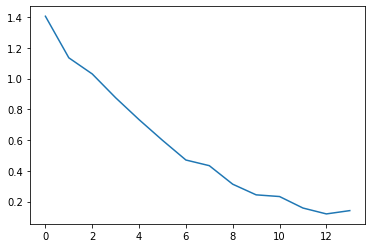

In [ ]:
import matplotlib
matplotlib.pyplot.plot(range(len(losslsit)),losslsit)

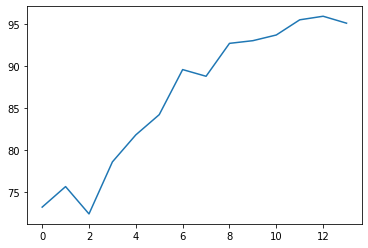

In [ ]:
matplotlib.pyplot.plot(range(len(acclist)),acclist)

In [ ]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score,confusion_matrix, classification_report
def print_metrices(pred,true):
    print(confusion_matrix(true,pred))
    print(classification_report(true,pred,))
    print("Accuracy : ",accuracy_score(pred,true))
    print("Precison : ",precision_score(pred,true, average = 'weighted'))
    print("Recall : ",recall_score(pred,true,  average = 'weighted'))
    print("F1 : ",f1_score(pred,true,  average = 'weighted'))

In [ ]:
import sklearn
def valid(model, testing_loader):
    model.eval()
    n_correct = 0; n_wrong = 0; total = 0; tr_loss=0; nb_tr_steps=0; nb_tr_examples=0
    y_true=torch.tensor([])
    y_pred=torch.tensor([])
    idx = []
    with torch.no_grad():
        for _, data in tqdm(enumerate(testing_loader, 0)):
            ids = data['ids'].to(device, dtype = torch.long)
            mask = data['mask'].to(device, dtype = torch.long)
            token_type_ids = data['token_type_ids'].to(device, dtype=torch.long)
            targets = data['targets'].to(device, dtype = torch.long)
            outputs = model(ids, mask, token_type_ids).squeeze()
            loss = loss_function(outputs, targets)
            tr_loss += loss.item()
            big_val, big_idx = torch.max(outputs.data, dim=1)
            idx.extend(big_idx)
            n_correct += calcuate_accuracy(big_idx, targets)
            y_pred = torch.cat((y_pred, big_idx.detach().cpu()),0)
            y_true = torch.cat((y_true,targets.detach().cpu()),0)
            nb_tr_steps += 1
            nb_tr_examples+=targets.size(0)
            
    epoch_loss = tr_loss/nb_tr_steps
    epoch_accu = (n_correct*100)/nb_tr_examples
    print(f"Validation Loss Epoch: {epoch_loss}")
    print(f"Validation Accuracy Epoch: {epoch_accu}")
    y_true = y_true.detach().cpu().numpy()
    y_pred = y_pred.detach().cpu().numpy()
    # scores = metrics.precision_recall_fscore_support(y_true,y_pred, average=None,
    #                                                    labels = [0,1,2,3,4,5])
    # print(f"Precision: {scores[0]}")
    # print(f"Recall:    {scores[1]}")
    # print(f"f1:        {scores[2]}")
    # print(f"support.   {scores[3]}")
    #print(sklearn.metrics.classification_report(y_true,y_pred))

    print_metrices(y_pred,y_true)
    return epoch_accu

In [ ]:
acc = valid(model, testing_loader)
print(f"Accuracy on test data = {acc}")


0it [00:00, ?it/s]/usr/local/lib/python3.6/dist-packages/transformers/tokenization_utils_base.py:2143: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,

1it [00:00,  7.76it/s]
2it [00:00,  7.94it/s]
3it [00:00,  8.12it/s]
4it [00:00,  8.23it/s]
5it [00:00,  8.36it/s]
6it [00:00,  8.49it/s]
7it [00:00,  8.58it/s]
8it [00:00,  8.64it/s]
9it [00:01,  8.65it/s]
10it [00:01,  8.71it/s]
11it [00:01,  8.73it/s]
12it [00:01,  8.73it/s]
13it [00:01,  8.75it/s]
14it [00:01,  8.77it/s]
15it [00:01,  8.78it/s]
16it [00:01,  8.78it/s]
17it [00:01,  8.80it/s]
18it [00:02,  8.80it/s]
19it [00:02,  8.82it/s]
20it [

Validation Loss Epoch: 0.7795291040875018
Validation Accuracy Epoch: 90.59529764882441
[[1632   65   28   18   36]
 [   9   14    0    0    1]
 [  18    0  145    0    0]
 [   3    0    0    8    2]
 [   5    1    0    2   12]]
              precision    recall  f1-score   support

         0.0       0.98      0.92      0.95      1779
         1.0       0.17      0.58      0.27        24
         2.0       0.84      0.89      0.86       163
         3.0       0.29      0.62      0.39        13
         4.0       0.24      0.60      0.34        20

    accuracy                           0.91      1999
   macro avg       0.50      0.72      0.56      1999
weighted avg       0.95      0.91      0.92      1999

Accuracy :  0.9059529764882441
Precison :  0.8892685236896801
Recall :  0.9059529764882441
F1 :  0.8894336346443689
Accuracy on test data = 90.59529764882441


In [ ]:
torch.save(model.state_dict(),f"/content/drive/MyDrive/Datasets/Eacl_Kannada_model/Kannada_model_{len(acclist)}_epochs.pth")

In [ ]:
model.state_dict